In [ ]:
#### Red Wall Replication II

In [3]:
dataset_name = "W14_comb"
df_list = 'BES_Panel'
#            'BES_reduced_with_na'
#           ]#,"BESnumeric"]

%matplotlib inline 
%run BES_header.py {dataset_name} {df_list}

del BES_Panel

Toggle code

In [293]:
from random import randint
import time
import statsmodels.api as sm

def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes


def sm_and_xgb_plot(var_stub,title,specific_vars,df_simp,geomask=None,window=None,dependence_plots=False):
    from scipy import stats
    Treatment = var_stub
    var_list = [var_stub]
    var_stub_list = [var_stub,]
    df_simp[var_stub] = BES_census_data[var_stub]
    mask = df_simp[var_stub].notnull()
    if geomask is not None:
        mask = mask&geomask
    
    min_features = 30
    colname = var_stub
#     dependence_plots = True

    alg = get_xgboost_alg(classification_problem=False)
    (explainer, shap_values, train_columns, train_index, alg,output_subfolder)=\
        xgboost_run(subdir=colname,dataset=df_simp[mask][specific_vars+[var_stub]],
                var_list=var_list,var_stub_list=var_stub_list,
                use_specific_weights=None,
                min_features = min(df_simp.shape[1]-1,min_features),verbosity=0,
                skip_bar_plot=True,dependence_plots=dependence_plots,alg=alg,eval_metric=eval_metric,                    
                title = title)
    xgboost_pred = pd.Series(alg.predict(df_simp[train_columns]),index=df_simp.index)

    import statsmodels.api as sm
    Y = df_simp[mask][var_stub]
    ## default mean imputation!
    X = df_simp[mask][specific_vars].astype('float').fillna(df_simp[mask][specific_vars].mean())
#     X = sm.add_constant(X)
    X["const"]=1.0
    model = sm.OLS(Y,X)
    results = model.fit()
    Xnew = df_simp[train_columns].astype('float')
#     Xnew = sm.add_constant(Xnew)
    Xnew["const"]=1.0
    statsmodels_pred = model.predict(results.params,Xnew)
    display( results.summary() );
    #########################################################

    ons_ids = BES_census_data.loc[df_simp.index,"ONSConstID"]
#     if geomask is not None:
#         ons_ids = ons_ids[geomask]

    xgb_var = title+"_xgb"+"_und"
    sm_var = title+"_sm"+"_und"

#     print("!!!!!!!!!!!!!!!!!!!!!!")
#     print(xgb_var,sm_var,title)
    merged[title+"_xgb"]=np.nan
    merged.loc[ ons_ids , title+"_xgb" ] = xgboost_pred.values
    merged[xgb_var] = merged[var_stub] - merged[title+"_xgb"]

    merged[title+"_sm"]=np.nan
    merged.loc[ ons_ids , title+"_sm" ] = statsmodels_pred
    merged[sm_var] = merged[var_stub] - merged[title+"_sm"]

    merged_mask = merged.reset_index()['PCON13CD'].isin(ons_ids[mask]).values
    
    

    fig, axes = plt.subplots(nrows=1,ncols=5,figsize=(16.5,4))
    merged[xgb_var][merged_mask].hist(bins=50,ax=axes[0])
#     mask = merged[xgb_var].notnull()
    sns.regplot(merged[title+"_xgb"][merged_mask],merged[var_stub][merged_mask],ax=axes[1])
    r, p, n= corr_simple_pearsonr(merged[title+"_xgb"],merged[var_stub], mask=merged_mask, round_places=2)
    axes[1].text(0.05, .9, 'r={:.2f}, p={:.2g}'.format(r, round(p,4)),verticalalignment='top', transform=axes[1].transAxes);
    add_identity(axes[1], color='r', ls='--')

    merged[sm_var][merged_mask].hist(bins=50,ax=axes[2])
#     mask = merged[sm_var].notnull()
    sns.regplot(merged[title+"_sm"][merged_mask],merged[var_stub][merged_mask],ax=axes[3])
    corr_mask = merged[title+"_sm"][merged_mask].notnull()&merged[var_stub][merged_mask].notnull()
    r, p, n= corr_simple_pearsonr(merged[title+"_sm"],merged[var_stub], mask=merged_mask, round_places=2)
#     r, p = stats.pearsonr(  merged[title+"_sm"][merged_mask][corr_mask]merged[var_stub][merged_mask][corr_mask] )
    axes[3].text(0.05, .9, 'r={:.2f}, p={:.2g}'.format(r, round(p,4)),verticalalignment='top', transform=axes[3].transAxes);
    add_identity(axes[3], color='r', ls='--')

    axes[0].set_ylabel("freq");
    axes[0].set_xlabel("underperf vs model (xgb)");
    axes[1].set_ylabel(var_stub);
    axes[1].set_xlabel(var_stub+" pred (xgb)");
    axes[2].set_ylabel("freq");
    axes[2].set_xlabel("underperf vs model (sm)");
    axes[3].set_ylabel(var_stub);
    axes[3].set_xlabel(var_stub+" pred (sm)");

    
    g = sns.regplot(x=merged[xgb_var][merged_mask], y=merged[sm_var][merged_mask], ax = axes[4])
#     r, p = stats.pearsonr( merged[xgb_var][merged_mask] , merged[sm_var][merged_mask] )
    r, p, n= corr_simple_pearsonr(merged[xgb_var],merged[sm_var], mask=merged_mask, round_places=2)
    axes[4].text(0.05, .9, 'r={:.2f}, p={:.2g}'.format(r, round(p,4)),verticalalignment='top', transform=axes[4].transAxes);
    axes[4].set_ylabel("underperf vs model (sm)");
    axes[4].set_xlabel("underperf vs model (xgb)");
    add_identity(axes[4], color='r', ls='--')
    plt.suptitle("Residual histograms and regression plots for each of Xgboost/Statsmodels models\nFollowed by regression of each models residuals");
    ##########################################################

    top75 = False
    add_colorbar = True

    if top75 == True:
        merged[xgb_var] = merged[xgb_var]<merged[xgb_var].quantile(.25)
        merged[sm_var] = merged[sm_var]<merged[sm_var].quantile(.25)
    else:
        merged[xgb_var] = -merged[xgb_var]
        merged[sm_var] = -merged[sm_var]
    if window is not None:
        merged_window = merged.reset_index()['PCON13CD'].isin(ons_ids[window]).values
        merged.loc[~merged_window,xgb_var]=np.nan
        merged.loc[~merged_window,sm_var]=np.nan
    else:
        merged.loc[~merged_mask,xgb_var]=np.nan
        merged.loc[~merged_mask,sm_var]=np.nan
              

    suptitle = "2017GE: Conservative Performance\nRelative To Demographic Model"
    symmetrical_colour_scale = True
    # set the range for the choropleth
    vmin, vmax = np.floor(merged[[xgb_var,sm_var]].min().min()/10)*10, np.ceil(merged[[xgb_var,sm_var]].max().max()/10)*10
    
    if symmetrical_colour_scale:
        max_abs_scale = max(abs(vmin),abs(vmax))
        vmin = (vmin/abs(vmin))*max_abs_scale
        vmax = (vmax/abs(vmax))*max_abs_scale

    # create figure and axes for Matplotlib
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(16, 10))

    # create map
    merged.plot(column=xgb_var, cmap='seismic', norm=plt.Normalize(vmin=vmin, vmax=vmax), linewidth=0.1, ax=ax[0], edgecolor='0.8',aspect=1)
    # remove the axis
    ax[0].axis('off')
    # add a title
    ax[0].set_title(suptitle+"(xgb)", \
                  fontdict={'fontsize': '18',
                            'fontweight' : '3'})

    # create map
    merged.plot(column=sm_var,  cmap='seismic', norm=plt.Normalize(vmin=vmin, vmax=vmax), linewidth=0.1, ax=ax[1], edgecolor='0.8',aspect=1)
    # remove the axis
    ax[1].axis('off')
    # add a title
    ax[1].set_title(suptitle+"(sm)", \
                  fontdict={'fontsize': '18',
                            'fontweight' : '3'})



    # create an annotation for the  data source
    plt.annotate('Source: https://www.britishelectionstudy.com/data-objects/linked-data/',
               xy=(0.3, .17), xycoords='figure fraction',
               verticalalignment='bottom',
                 #horizontalalignment='middle', 
               fontsize=10, color='#555555')

    if add_colorbar:
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('seismic').reversed(),#'seismic',
                                   norm=plt.Normalize(vmin=vmin, vmax=vmax))
#         sm._A = []
        cbar = fig.colorbar(sm,
#                             pad=-.5,
#                             orientation='horizontal',
                            pad=0,
                            location='top',ax=ax[0:2], shrink=.2,fraction=.3)
        # location='bottom',

    Treatment = "Chloropleth"
    output_subfolder = create_subdir(BES_output_folder,Treatment)
    fname = output_subfolder +suptitle +".png"
    # this will save the figure as a high-res png. you can also save as svg
    plt.savefig( fname, bbox_inches='tight', dpi=1000 )
    return ()

def model_comparison(var_stub,title,specific_vars_list,df_simp,geomask=None,model_type='sm',window=None,dependence_plots=False):
    from scipy import stats
    Treatment = var_stub
    var_list = [var_stub]
    var_stub_list = [var_stub,]
    df_simp[var_stub] = BES_census_data[var_stub]
    mask = df_simp[var_stub].notnull()
    if geomask is not None:
        mask = mask&geomask
    ons_ids = BES_census_data.loc[df_simp.index,"ONSConstID"]    
#     print("MASK DEBUG")
#     print(mask.sum())
    ######
    count=1
#     model_list = []
    for specific_vars in specific_vars_list:
        print("model"+str(count))
        min_features = 30
        colname = var_stub
#         dependence_plots = True
        alg = get_xgboost_alg(classification_problem=False)
        (explainer, shap_values, train_columns, train_index, alg,output_subfolder)=\
            xgboost_run(subdir=colname,dataset=df_simp[mask][specific_vars+[var_stub]],
                    var_list=var_list,var_stub_list=var_stub_list,
                    use_specific_weights=None,
                    min_features = min(df_simp.shape[1]-1,min_features),verbosity=0,
                    skip_bar_plot=True,dependence_plots=dependence_plots,alg=alg,eval_metric=eval_metric,                    
                    title = title)
        xgboost_pred = pd.Series(alg.predict(df_simp[train_columns]),index=df_simp.index)
        ######
        import statsmodels.api as sm
        Y = df_simp[mask][var_stub]
        X = df_simp[mask][specific_vars].astype('float').fillna(df_simp[mask][specific_vars].mean())
#         X = sm.add_constant(X)
        X["const"]=1.0
        model = sm.OLS(Y,X)
        results = model.fit()
        Xnew = df_simp[train_columns].astype('float')
#         Xnew = sm.add_constant(Xnew)
        Xnew["const"]=1.0
        statsmodels_pred = model.predict(results.params,Xnew)
        display( results.summary() );
        ######
        pred_name = title+"_model"+str(count)
        merged[pred_name]=np.nan
        if model_type == "xgb":
            merged.loc[ ons_ids , pred_name ] = xgboost_pred.values
        else:
            merged.loc[ ons_ids , pred_name ] = statsmodels_pred
        merged[pred_name+"_und"] = merged[var_stub] - merged[pred_name]
        
        count=count+1

    
    merged_mask = merged.reset_index()['PCON13CD'].isin(ons_ids[mask]).values
    

    if len(specific_vars_list)==2:
    
        fig, axes = plt.subplots(nrows=1,ncols=5,figsize=(16.5,4))
        merged[title+"_model1"+"_und"][merged_mask].hist(bins=50,ax=axes[0])
    #     mask = merged[xgb_var].notnull()
#         model1 = title+"_model1"
#         model2 = title+"_model2"
        sns.regplot(merged[title+"_model1"][merged_mask],merged[var_stub][merged_mask],ax=axes[1])
#         r, p = stats.pearsonr( merged[title+"_model1"][merged_mask] , merged[var_stub][merged_mask] )
        r, p, n= corr_simple_pearsonr(merged[title+"_model1"],merged[var_stub], mask=merged_mask, round_places=2)
        axes[1].text(0.05, .9, 'r={:.2f}, p={:.2g}'.format(r, round(p,4)),verticalalignment='top', transform=axes[1].transAxes);
        add_identity(axes[1], color='r', ls='--')
        
        merged[title+"_model2"+"_und"][merged_mask].hist(bins=50,ax=axes[2])
    #     mask = merged[sm_var].notnull()
        sns.regplot(merged[title+"_model2"][merged_mask],merged[var_stub][merged_mask],ax=axes[3])
#         r, p = stats.pearsonr( merged[title+"_model2"][merged_mask] , merged[var_stub][merged_mask] )
        r, p, n= corr_simple_pearsonr(merged[title+"_model2"],merged[var_stub], mask=merged_mask, round_places=2)
        axes[3].text(0.05, .9, 'r={:.2f}, p={:.2g}'.format(r, round(p,4)),verticalalignment='top', transform=axes[3].transAxes);
        add_identity(axes[3], color='r', ls='--')

        axes[0].set_ylabel("freq");
        axes[0].set_xlabel("model 1 residuals");
        axes[1].set_ylabel(var_stub);
        axes[1].set_xlabel(var_stub+" model 1 pred");
        axes[2].set_ylabel("freq");
        axes[2].set_xlabel("model 2 residuals");
        axes[3].set_ylabel(var_stub);
        axes[3].set_xlabel(var_stub+" model 2 pred");

        g = sns.regplot(x=merged[title+"_model1"+"_und"][merged_mask],
                        y=merged[title+"_model2"+"_und"][merged_mask], ax = axes[4])
#         r, p = stats.pearsonr( merged[title+"_model1"+"_und"][merged_mask],
#                                merged[title+"_model2"+"_und"][merged_mask] )
        r, p, n= corr_simple_pearsonr(merged[title+"_model1"],merged[title+"_model2"+"_und"], mask=merged_mask, round_places=2)
        axes[4].set_ylabel("model 1 residuals");
        axes[4].set_xlabel("model 2 residuals");
        axes[4].text(0.05, .9, 'r={:.2f}, p={:.2g}'.format(r, round(p,4)),verticalalignment='top', transform=axes[4].transAxes);
        add_identity(axes[4], color='r', ls='--')
        
        fig.tight_layout()
#         plt.suptitle("Residual histograms and regression plots for each of Xgboost/Statsmodels models\nFollowed by regression of each models residuals");
    ##########################################################

    top75 = False
    fraction = .25
    add_colorbar = True
#     plt_title = "2017GE: Conservative Performance\nRelative To Demographic Model"
    symmetrical_colour_scale = True    
    
    var_list = [title+"_model"+str(x)+"_und" for x in range(1,len(specific_vars_list)+1)]
    
    for resid in var_list:
        if top75 == True:
            merged[resid] = merged[resid]<merged[resid].quantile(fraction)
        else:
            merged[resid] = -merged[resid]
        if window is not None:
            merged_window = merged.reset_index()['PCON13CD'].isin(ons_ids[window]).values
            merged.loc[~merged_window,resid]=np.nan
        else:
            merged.loc[~merged_mask,resid]=np.nan



    # set the range for the choropleth
    vmin, vmax = np.floor(merged[var_list].min().min()/10)*10, np.ceil(merged[var_list].max().max()/10)*10
    if symmetrical_colour_scale:
        max_abs_scale = max(abs(vmin),abs(vmax))
        vmin = (vmin/abs(vmin))*max_abs_scale
        vmax = (vmax/abs(vmax))*max_abs_scale

    # create figure and axes for Matplotlib
    fig, ax = plt.subplots(nrows=1,ncols=len(specific_vars_list),
                           figsize=(16, 10))
    
    for var_no in range(len(var_list)):
        # create map
        merged.plot(column=var_list[var_no], cmap='seismic', norm=plt.Normalize(vmin=vmin, vmax=vmax), linewidth=0.1,
                    ax=ax[var_no], edgecolor='0.8',aspect=1)

        # remove the axis
        ax[var_no].axis('off')
        # add a title
        ax[var_no].set_title("model"+str(var_no+1), \
                      fontdict={'fontsize': '18',
                                'fontweight' : '3'})
    
#     # create map
#     merged.plot(column=sm_var,  cmap='seismic', norm=plt.Normalize(vmin=vmin, vmax=vmax), linewidth=0.1, ax=ax[1], edgecolor='0.8',aspect=1)
#     # remove the axis
#     ax[1].axis('off')
#     # add a title
#     ax[1].set_title(title+"(sm)", \
#                   fontdict={'fontsize': '18',
#                             'fontweight' : '3'})



    # create an annotation for the  data source
    plt.annotate('Source: https://www.britishelectionstudy.com/data-objects/linked-data/',
               xy=(0.3, .17), xycoords='figure fraction',
               verticalalignment='bottom',
                 #horizontalalignment='middle', 
               fontsize=10, color='#555555')

    if add_colorbar:
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('seismic').reversed(),#'seismic',
                                   norm=plt.Normalize(vmin=vmin, vmax=vmax))
#         sm._A = []
        if len(specific_vars_list)==2:
            location = 'top'
        else:
            location = 'bottom'
        cbar = fig.colorbar(sm,
#                             pad=-.5,
#                             orientation='horizontal',
                            pad=0,
                            location=location,ax=ax[0:len(specific_vars_list)], shrink=.2,fraction=.3)
        # location='bottom',

#     plt.suptitle(title)
        
    Treatment = "Chloropleth"
    output_subfolder = create_subdir(BES_output_folder,Treatment)
    fname = output_subfolder +title +".png"
    # this will save the figure as a high-res png. you can also save as svg
    plt.savefig( fname, bbox_inches='tight', dpi=1000 )
    return ()

import pickle
def dim_red(df,n_components=None,red_type="Factor Analysis",show_first_x_comps=4,display_comp=True):

    Treatment = "Census Data Decomposition"
    output_folder = "E:\\BES_analysis_data\\output\\CensusDataDecomposition\\"
    output_subfolder = output_folder + Treatment + os.sep
    if not os.path.exists( output_subfolder ):
        os.makedirs( output_subfolder )

    decomp_index = df.index
    decomp_columns = df.columns
    clean_feature_set_std = StandardScaler().fit_transform(df.values)
    decomp_std = pd.DataFrame(   clean_feature_set_std,
                                 columns = decomp_columns,
                                 index   = decomp_index      )
    if n_components is None:
        n_components = decomp_std.shape[1]
    
    # n_components = 4
    # (svd_solver='full', n_components='mle',whiten=True)
    
    if red_type == "Factor Analysis":
        decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hr
    elif red_type == "PCA":
        decomp = PCA(n_components = n_components,svd_solver='full')    
    decomp_method = str(decomp).split("(")[0] 
    X_r = decomp.fit_transform(decomp_std)
    
    n_components = min(n_components,X_r.shape[1])
    BES_decomp = pd.DataFrame(   X_r,
                                 columns = range(0,n_components),
                                 index   = decomp_index)

#     save = True # False => Load
#     if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
#         decomp_method = str(decomp).split("(")[0] 
#         subdir = output_subfolder + decomp_method
#         fname = subdir+ os.sep + decomp_method
    subdir = output_subfolder + decomp_method
    if display_comp:
        (BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                              decomp_columns, BES_decomp, manifest=None, 
                                                              save_folder = subdir,  
                                                              show_first_x_comps= show_first_x_comps, show_histogram = False)    
        return (BES_decomp, comp_labels, comp_dict)
    else:
        return BES_decomp

In [6]:
BES_census_data_2019 = pd.read_stata( BES_small_data_files + "BES-2019-General-Election-results-file-v1.0.dta" )
print("BES_census_data 2019", BES_census_data_2019.shape )

BES_census_data_2017 = pd.read_stata( BES_small_data_files + "BES-2017-General-Election-results-file-v1.0.dta" )
print("BES_census_data", BES_census_data_2017.shape )

BES_census_data_2015 = pd.read_stata( BES_small_data_files + "BES-2015-General-Election-results-file-v2.21.dta" )
print("BES_census_data 2015", BES_census_data_2015.shape )

BES_census_data = BES_census_data_2019.copy()

BES_census_data 2019 (632, 385)
BES_census_data (632, 308)
BES_census_data 2015 (632, 277)


In [7]:
#### BUG! -> check if in latest release, if yes, then tell them! ###########
BES_census_data.loc[BES_census_data["Country"].isin(["Scotland"]),"c11Households"] =\
    BES_census_data.loc[BES_census_data["Country"].isin(["Scotland"]),"c11Households"]*100
BES_census_data["ConstituencyName"] = BES_census_data["ConstituencyName"].replace("Ynys Môn","Ynys Mon")
BES_census_data["Winner15"] = BES_census_data["Winner15"].replace("Speaker.","Speaker")

BES_census_data[search(BES_census_data_2015,"SpendPercent").index] = BES_census_data_2015[search(BES_census_data_2015,"SpendPercent").index]

BES_census_data[['SNPLongSpendPercent', 'SNPShortSpendPercent',
       'PCLongSpendPercent', 'PCShortSpendPercent']] = BES_census_data[['SNPLongSpendPercent', 'SNPShortSpendPercent',
       'PCLongSpendPercent', 'PCShortSpendPercent']].replace(".",np.nan).astype('float')

In [8]:
party_19_list = search(BES_census_data,"^(Con|Lab|Brexit|LD|UKIP|SNP|PC|Green)19$").index
BES_census_data[[x+"_elec" for x in party_19_list]] = BES_census_data[party_19_list].apply(lambda x: x*BES_census_data["Turnout19"]/100).fillna(0)
BES_census_data["DNV19_elec"] = 100-BES_census_data["Turnout19"]
BES_census_data["DNV&OTH19_elec"] = 100-BES_census_data["Turnout19"]-BES_census_data["Other19"].fillna(0)
BES_census_data["Auth_Right19_elec"] = BES_census_data["Con19_elec"]+BES_census_data["UKIP19_elec"]+BES_census_data["Brexit19_elec"]
BES_census_data["Lib_Left19_elec"] = BES_census_data["Lab19_elec"]+BES_census_data["LD19_elec"]+BES_census_data["PC19_elec"]+BES_census_data["SNP19_elec"]+BES_census_data["Green19_elec"]

party_17_list = search(BES_census_data,"^(Con|Lab|Brexit|LD|UKIP|SNP|PC|Green)17$").index
BES_census_data[[x+"_elec" for x in party_17_list]] = BES_census_data[party_17_list].apply(lambda x: x*BES_census_data["Turnout17"]/100).fillna(0)
BES_census_data["DNV17_elec"] = 100-BES_census_data["Turnout17"]
BES_census_data["DNV&OTH17_elec"] = 100-BES_census_data["Turnout17"]-BES_census_data["Other17"].fillna(0)
BES_census_data["Auth_Right17_elec"] = BES_census_data["Con17_elec"]+BES_census_data["UKIP17_elec"]#+BES_census_data["Brexit17_elec"]
BES_census_data["Lib_Left17_elec"] = BES_census_data["Lab17_elec"]+BES_census_data["LD17_elec"]+BES_census_data["PC17_elec"]\
                                    +BES_census_data["SNP17_elec"]+BES_census_data["Green17_elec"]

party_15_list = search(BES_census_data,"^(Con|Lab|Brexit|LD|UKIP|SNP|PC|Green)15$").index
BES_census_data[[x+"_elec" for x in party_15_list]] = BES_census_data[party_15_list]\
                                    .apply(lambda x: x*BES_census_data["Turnout15"]/100).fillna(0)
BES_census_data["DNV15_elec"] = 100-BES_census_data["Turnout15"]
BES_census_data["DNV&OTH15_elec"] = 100-BES_census_data["Turnout15"]-BES_census_data["Other15"].fillna(0)
BES_census_data["Auth_Right15_elec"] = BES_census_data["Con15_elec"]+BES_census_data["UKIP15_elec"]#+BES_census_data["Brexit17_elec"]
BES_census_data["Lib_Left15_elec"] = BES_census_data["Lab15_elec"]+BES_census_data["LD15_elec"]+BES_census_data["PC15_elec"]\
                                    +BES_census_data["SNP15_elec"]+BES_census_data["Green15_elec"]

party_10_list = search(BES_census_data,"^(Con|Lab|BNP|LD|UKIP|SNP|PC|Green)10$").index
BES_census_data[[x+"_elec" for x in party_10_list]] = BES_census_data[party_10_list].apply(lambda x: x*BES_census_data["Turnout10"]/100).fillna(0)
BES_census_data["DNV10_elec"] = 100-BES_census_data["Turnout10"]
BES_census_data["DNV&OTH10_elec"] = 100-(BES_census_data[party_10_list].apply(lambda x: x*BES_census_data["Turnout10"]/100).sum(axis=1))
BES_census_data["Auth_Right10_elec"] = BES_census_data["Con10_elec"]+BES_census_data["UKIP10_elec"]+BES_census_data["BNP10_elec"]
BES_census_data["Lib_Left10_elec"] = BES_census_data["Lab10_elec"]+BES_census_data["LD10_elec"]+BES_census_data["PC10_elec"]\
                                    +BES_census_data["SNP10_elec"]+BES_census_data["Green10_elec"]

party_05_list = search(BES_census_data,"^(Con|Lab|BNP|LD|UKIP|SNP|PC|Green)05$").index
BES_census_data[[x+"_elec" for x in party_05_list]] = BES_census_data[party_05_list].apply(lambda x: x*BES_census_data["Turnout05"]/100).fillna(0)
BES_census_data["DNV05_elec"] = 100-BES_census_data["Turnout05"]
BES_census_data["DNV&OTH05_elec"] = 100-BES_census_data["Turnout05"]-BES_census_data["Other05"].fillna(0)
BES_census_data["Auth_Right05_elec"] = BES_census_data["Con05_elec"]+BES_census_data["UKIP05_elec"]+BES_census_data["BNP05_elec"]
BES_census_data["Lib_Left05_elec"] = BES_census_data["Lab05_elec"]+BES_census_data["LD05_elec"]+BES_census_data["PC05_elec"]\
                                    +BES_census_data["SNP05_elec"]+BES_census_data["Green05_elec"]


In [9]:
occ_df = pd.read_excel( open(BES_small_data_files+'Census2011-ConstituencyProfile-uk.xlsx','rb'), sheet_name='KS608D' )
occ_df.columns = occ_df.loc[3]
occ_df = occ_df.drop([0,1,2,3,654,])
# occ_df

var_list = ["CON%ELEM","CON%OPS","CON%SAL_SERV","CON%CAR_LEI_","CON%SKILL","CON%ADMIN_SEC","CON%ASSOC_PROF_TECH",
 "CON%PROF","CON%MAN_DIR_SEN"]

# occ_df = occ_df.set_index("ONSConstID").loc[merged.index]
# var_list = ["CON%ELEM","CON%OPS","CON%SAL_SERV","CON%CAR_LEI_","CON%SKILL","CON%ADMIN_SEC","CON%ASSOC_PROF_TECH",
#  "CON%PROF","CON%MAN_DIR_SEN"]

BES_census_data[var_list] = occ_df.set_index("ONSConstID").loc[BES_census_data["ONSConstID"]][var_list].values

merseyside = ["Birkenhead","Bootle","Garston and Halewood","Knowsley",
             "Liverpool, Riverside","Liverpool, Walton","Liverpool, Wavertree","Liverpool, West Derby",
             "Sefton Central","Southport","St Helens North","St Helens South and Whiston",
             "Wallasey","Wirral South","Wirral West"]

BES_census_data["Merseyside"] = BES_census_data["ConstituencyName"].isin(merseyside).astype('float')

In [10]:
welsh_df = pd.read_excel( open(BES_small_data_files+'welsh_constituency_data.xls','rb'), sheet_name='WelshLanguage' )
welsh_df.columns = welsh_df.loc[4]
welsh_df = welsh_df.drop([0,1,2,3,4,50,51,52])
welsh_df = welsh_df.replace("Ynys Môn","Ynys Mon")
welsh_df = welsh_df.set_index("Assembly Constituency Area")
BES_census_data["speakWelsh"] = [welsh_df.loc[x,"Percentage aged 3+ who can speak Welsh"] if x in welsh_df.index else 0 for x in BES_census_data["ConstituencyName"]  ]

In [11]:
BES_census_data["c11DeprivedMean"] = (BES_census_data["c11Deprived1"]+(BES_census_data["c11Deprived2"]*2)+(BES_census_data["c11Deprived3"]*3)+(BES_census_data["c11Deprived4"]*4))/100
BES_census_data["c11CarsMean"] = (BES_census_data["c11CarsOne"]+(BES_census_data["c11CarsTwo"]*2)+(BES_census_data["c11CarsThree"]*3)+(BES_census_data["c11CarsFour"]*4))/100
BES_census_data["c11AgeMean"] = (
                                 BES_census_data["c11Age18to19"]*18.5+\
                                 BES_census_data["c11Age20to24"]*22+\
                                 BES_census_data["c11Age25to29"]*27+\
                                 BES_census_data["c11Age30to44"]*37+\
                                 BES_census_data["c11Age45to59"]*52+\
                                 BES_census_data["c11Age60to64"]*62+\
                                 BES_census_data["c11Age65to74"]*69.5+\
                                 BES_census_data["c11Age75to84"]*79.5+\
                                 BES_census_data["c11Age85to89"]*87+\
                                 BES_census_data["c11Age90plus"]*95  )/100
BES_census_data["c11DeprivedHigh"] =BES_census_data["c11Deprived3"]+BES_census_data["c11Deprived4"]
BES_census_data["c11DeprivedLow"] =BES_census_data["c11Deprived2"]+BES_census_data["c11Deprived1"]+BES_census_data["c11DeprivedNone"]
## kids
BES_census_data["c11Kids"] =BES_census_data["c11Age0to4"]+\
                            BES_census_data["c11Age5to7"]+\
                            BES_census_data["c11Age8to9"]+\
                            BES_census_data["c11Age10to14"]+\
                            BES_census_data["c11Age15"]+\
                            BES_census_data["c11Age16to17"]
# 'c11Age0to4', 'c11Age5to7', 'c11Age8to9', 'c11Age10to14', 'c11Age15',  'c11Age16to17',
## young adults
BES_census_data["c11YoungAdults"] =BES_census_data["c11Age18to19"]+\
                            BES_census_data["c11Age20to24"]+\
                            BES_census_data["c11Age25to29"]
# 'c11Age18to19', 'c11Age20to24', 'c11Age25to29',
## adult
BES_census_data["c11Adults"] =BES_census_data["c11Age30to44"]+\
                              BES_census_data["c11Age45to59"]
# 'c11Age30to44', 'c11Age45to59',
## elderly
BES_census_data["c11Elderly"] =BES_census_data["c11Age60to64"]+\
                            BES_census_data["c11Age65to74"]+\
                            BES_census_data["c11Age75to84"]+\
                            BES_census_data["c11Age85to89"]+\
                            BES_census_data["c11Age90plus"]
# 'c11Age60to64', 'c11Age65to74', 'c11Age75to84', 'c11Age85to89', 'c11Age90plus'
BES_census_data["c11HealthMean"] = (BES_census_data["c11HealthVeryBad"]+\
                                    BES_census_data["c11HealthBad"])-\
                                    (BES_census_data["c11HealthFair"]+\
                                    BES_census_data["c11HealthGood"])
                                    ## still not very good
BES_census_data["c11HealthVeryBad&Bad"] = BES_census_data["c11HealthVeryBad"]+BES_census_data["c11HealthBad"]
BES_census_data["c11HealthFair&Good"] = BES_census_data["c11HealthFair"]+BES_census_data["c11HealthGood"]
BES_census_data["c11CarsMoreThanNone"] = BES_census_data["c11CarsOne"]+BES_census_data["c11CarsTwo"]+BES_census_data["c11CarsThree"]+BES_census_data["c11CarsFour"]


In [12]:
df = pd.read_csv(BES_small_data_files+"CentreForTowns"+os.sep+"pcon-classification-csv.csv")

# https://www.centrefortowns.org/our-towns
    
# Type	Definition	Number
# Villages (less than 5,000)	Places with less than 5,000 residents	5,568
# Communities (5-10k)	Places with between 5,000 and 10,000 residents	567
# Small towns (10k-30k)	Towns with between 10,000 and 30,000 residents	550
# Medium towns (30k – 75k)	Towns with between 30,000 and 75,000 residents	242
# Large towns (over 75k)	Towns with over 75,000 residents	102
# Core Cities	Core cities as defined by Pike et al (2016)	12

## doesn't seem so consisent - where is 'communities!'
replace_dict = {"Village or Smaller":"Village or smaller",}
df["classification"] = df["classification"].replace(replace_dict)
centre_for_towns = df.pivot(index='constituency_code', columns='classification', values='percent_of_constituency').fillna(0)
BES_census_data[centre_for_towns.columns] = centre_for_towns.loc[BES_census_data["ONSConstID"]].values

In [13]:
parl_con_aggs = pd.read_csv(BES_small_data_files+"parliamentary constituency data"+os.sep+"Lots of aggregated parliamentary data.csv")

parl_con_aggs = parl_con_aggs.set_index("ONSConstID").drop(['Unnamed: 0', 'pano',
 'RESULTS2019_OTHER', 'RESULTS2019_Registered Voters', 'YOUGOVMRP_DEC_Con', 'YOUGOVMRP_DEC_Lab', 'YOUGOVMRP_DEC_LD',
       'YOUGOVMRP_DEC_Brexit', 'YOUGOVMRP_DEC_Green', 'YOUGOVMRP_DEC_SNP',
       'YOUGOVMRP_DEC_PC', 'YOUGOVMRP_DEC_Other', 'YOUGOVMRP_NOV_Con',
       'YOUGOVMRP_NOV_Lab', 'YOUGOVMRP_NOV_LD', 'YOUGOVMRP_NOV_Brexit',
       'YOUGOVMRP_NOV_Green', 'YOUGOVMRP_NOV_SNP', 'YOUGOVMRP_NOV_PC',
       'YOUGOVMRP_NOV_Other', 'ConVote17', 'TotalVote17', 'RejectedVote17',
       'Electorate17', 'ConVote15', 'TotalVote15', 'RejectedVote15',
       'Electorate15', 'ConVote10', 'TotalVote10', 'Electorate10',
       'c11Population','RESULTS2019_CON', 'RESULTS2019_LAB',
       'RESULTS2019_LIBDEM', 'RESULTS2019_GRN', 'RESULTS2019_SNP',
       'RESULTS2019_PC', 'RESULTS2019_BXP', 'RESULTS2019_UKIP',
       'RESULTS2019_Turnout','Turn10'],axis=1).select_dtypes(['float64','int64'])
parl_con_aggs = parl_con_aggs.drop(set(parl_con_aggs.columns).intersection(set(BES_census_data.columns)),axis=1)
parl_con_aggs = parl_con_aggs.loc[BES_census_data["ONSConstID"]]

BES_census_data[parl_con_aggs.columns] = parl_con_aggs.values
BES_census_data.columns = [x.replace("<","LT") for x in BES_census_data.columns]

In [14]:
BES_constituency_aggregates = pd.read_csv(BES_small_data_files+"parliamentary constituency data"+os.sep+"BES_constituency_aggregates.csv")
BES_constituency_aggregates = BES_constituency_aggregates.set_index("ons_const_id").drop(["Unnamed: 0","constituency_name","pano"],axis=1).loc[BES_census_data["ONSConstID"]]
# (632, 6868)

## a lot - won't add before testing!

In [15]:
nomis_dump = pd.read_csv(BES_data_folder+"Nomis"+os.sep+"2011ONS_England&Wales_by_parlcon.csv")
nomis_dump = nomis_dump.set_index("Unnamed: 0").loc[BES_census_data["ONSConstID"][~BES_census_data["Country"].isin(["Scotland"])]]
## England&Wales

In [16]:
BES_census_data.shape

(632, 692)

In [17]:
import geopandas as gpd
# set the filepath and load in a shapefile
fp = BES_small_data_files+"wpc.json"
map_df = gpd.read_file(fp)
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
# map_df.head()
# now let's preview what our map looks like with no data in it
# map_df.plot();
# join the geodataframe with the cleaned up csv dataframe
merged = map_df.set_index("PCON13CD").join(BES_census_data.set_index("ONSConstID"))
merged = merged.loc[BES_census_data["ONSConstID"]]
merged.head()

PCON13CDO                           PCON13NM  \
PCON13CD                                                 
W07000049       W09                           Aberavon   
W07000058       W18                          Aberconwy   
S14000001       801                     Aberdeen North   
S14000002       802                     Aberdeen South   
S14000058       858  West Aberdeenshire and Kincardine   

                                                    geometry  pano  \
PCON13CD                                                             
W07000049  MULTIPOLYGON (((-3.83591 51.65169, -3.83335 51...     1   
W07000058  POLYGON ((-4.01359 53.08969, -4.01411 53.09075...     2   
S14000001  MULTIPOLYGON (((-2.08979 57.14050, -2.09245 57...     3   
S14000002  MULTIPOLYGON (((-2.07875 57.09302, -2.07942 57...     4   
S14000058  MULTIPOLYGON (((-2.31325 56.79981, -2.31325 56...     5   

                            ConstituencyName   Country    Region  \
PCON13CD                                                           
W07000049                           Aberavon     Wales     Wales   
W07000058                          Aberconwy     Wales     Wales   
S14000001                     Aberdeen North  Scotland  Scotland   
S14000002                     Aberdeen South  Scotland  Scotland   
S14000058  West Aberdeenshire and Kincardine  Scotland  Scotland   

          ConstituencyType                 Winner19      Con19  ...  \
PCON13CD                                                        ...   
W07000049           County                   Labour  20.627888  ...   
W07000058           County             Conservative  46.091324  ...   
S14000001          Borough  Scottish National Party  20.140059  ...   
S14000002          Borough  Scottish National Party  35.930584  ...   
S14000058           County             Conservative  42.650669  ...   

           ECOOBLIGATIONS_Affordable Warmth (HHCRO)  \
PCON13CD                                              
W07000049                                    1288.0   
W07000058                                     672.0   
S14000001                                     142.0   
S14000002                                     115.0   
S14000058                                      80.0   

           ECOOBLIGATIONS_Total number of ECO measures delivered  \
PCON13CD                                                           
W07000049                                             2469.0       
W07000058                                             1527.0       
S14000001                                             1830.0       
S14000002                                              802.0       
S14000058                                             1312.0       

           ECOOBLIGATIONS_ECO measures per 1,000 households  \
PCON13CD                                                      
W07000049                                              86.4   
W07000058                                              60.3   
S14000001                                              39.6   
S14000002                                              18.1   
S14000058                                              35.3   

           CLOCKFACEREP_diversity  CLOCKFACEREP_security  \
PCON13CD                                                   
W07000049                5.721792              -8.940468   
W07000058                5.955541              -0.716732   
S14000001               -5.738514              -1.560033   
S14000002               -2.323818               5.374963   
S14000058                4.985086               7.326884   

           CLOCKFACEREP_fecundity  CLOCKFACEREP_diversity_flatter  \
PCON13CD                                                            
W07000049               -2.864361                           155.0   
W07000058               -5.075229                           160.0   
S14000001              -10.261257                            34.0   
S14000002               -7.093062                            53.0 

In [285]:
drop_cols = ['Winner17', 'Winner15', 'Winner10','pano',#category
            'ConVote17', 'TotalVote17', 'Electorate17', 'ConVote15', 'TotalVote15',
       'Electorate15', 'ConVote10', 'TotalVote10', 'Electorate10', #int
             'LabVote19', 'Electorate19','RejectedVote19','LabVote05',
              'Lab17', 'LD17', 'SNP17', 'PC17', 'UKIP17', 'Green17',
             'Con0510', 'Lab0510', 'LD0510', 'SNP0510', 'PC0510',
       'BNP0510', 'UKIP0510', 'Green0510',
             'Con19', 'Lab19', 'LD19', 'SNP19', 'PC19', 'UKIP19', 'Green19',
       'Brexit19', 'Other19', 'Majority19', 'Turnout19', 'TotalVote19',
       'Con1719', 'Lab1719', 'LD1719', 'SNP1719', 'PC1719', 'UKIP1719',
       'Green1719',
             'ConVote19', 'LDVote19', 'SNPVote19', 'PCVote19', 'UKIPVote19',
       'GreenVote19', 'BrexitVote19',
             'leaveHanretty', 'remainHanretty',
             'Con05', 'Lab05', 'LD05', 'SNP05', 'PC05', 'UKIP05',
       'Green05', 'BNP05', 'Other05', 'Majority05', 'Turnout05', 'ConVote05',
       'LDVote05', 'SNPVote05', 'PCVote05', 'UKIPVote05', 'GreenVote05',
       'BNPVote05',
             'Winner05', 'ConPPCsex19', 'LabPPCsex19',
       'LDPPCsex19', 'SNPPPCsex19', 'PCPPCsex19', 'UKIPPPCsex19',
       'GreenPPCsex19', 'BrexitPPCsex19',
             # 'Con17',
       'Other17', 'Majority17', 'Turnout17', 'LabVote17', 'LDVote17',
       'SNPVote17', 'PCVote17', 'UKIPVote17', 'GreenVote17', 'Con1517',
       'Lab1517', 'LD1517', 'SNP1517', 'PC1517', 'UKIP1517', 'Green1517',
       'Con15', 'Lab15', 'LD15', 'SNP15', 'PC15', 'UKIP15', 'Green15',
       'Other15', 'Majority15', 'Turnout15', 'LabVote15', 'LDVote15',
       'SNPVote15', 'PCVote15', 'UKIPVote15', 'GreenVote15', 'BNPVote15',
       'Con1015', 'Lab1015', 'LD1015', 'SNP1015', 'PC1015', 'UKIP1015',
       'Green1015', 'Con10', 'Lab10', 'LD10', 'SNP10', 'PC10', 'UKIP10',
       'Green10', 'BNP10', 'Majority10', 'LabVote10', 'LDVote10',
       'SNPVote10', 'PCVote10', 'UKIPVote10', 'GreenVote10', 'BNPVote10',## float
       'ONSConstID', 'ConstituencyName', 'SeatChange1517', 'SeatChange1015',
       'ConPPC17', 'LabPPC17', 'LDPPC17', 'SNPPPC17', 'PCPPC17', 'UKIPPPC17',
       'GreenPPC17', 'ConPPC15', 'LabPPC15', 'LDPPC15', 'SNPPPC15', 'PCPPC15',
       'UKIPPPC15', 'GreenPPC15',     # object
       'ONSConstID', 'ConstituencyName', 'SeatChange1719', 'SeatChange1517',
       'SeatChange1015', 'ConPPC19', 'LabPPC19', 'LDPPC19', 'SNPPPC19',
       'PCPPC19', 'UKIPPPC19', 'GreenPPC19', 'BrexitPPC19', 'ConPPC17',
       'LabPPC17', 'LDPPC17', 'SNPPPC17', 'PCPPC17', 'UKIPPPC17', 'GreenPPC17',
       'ConPPC15', 'LabPPC15', 'LDPPC15', 'SNPPPC15', 'PCPPC15', 'UKIPPPC15',
       'GreenPPC15',
             'ConLongSpendPercent',
       'ConShortSpendPercent', 'LabLongSpendPercent', 'LabShortSpendPercent',
       'LDLongSpendPercent', 'LDShortSpendPercent', 'SNPLongSpendPercent',
       'SNPShortSpendPercent', 'PCLongSpendPercent', 'PCShortSpendPercent',
       'UKIPLongSpendPercent', 'UKIPShortSpendPercent',
       'GreenLongSpendPercent', 'GreenShortSpendPercent',
             'FOCALDATAMRP_DEC_Conservative',
 'FOCALDATAMRP_DEC_Labour',
 'FOCALDATAMRP_DEC_Liberal Democrats',
 'FOCALDATAMRP_DEC_SNP',
 'FOCALDATAMRP_DEC_Other',
 'FOCALDATAMRP_DEC_Green',
 'FOCALDATAMRP_DEC_Brexit Party',
 'FOCALDATAMRP_DEC_Plaid Cymru',
        'Winner19',
             'POLCOMP_Ec-Left-Right', 'POLCOMP_Soc-Lib-Con',
             'Turnout10',
            ]+['Con19_elec', 'Lab19_elec',
       'LD19_elec', 'SNP19_elec', 'PC19_elec', 'UKIP19_elec', 'Green19_elec',
       'Brexit19_elec', 'DNV19_elec', 'DNV&OTH19_elec', 'Auth_Right19_elec',
       'Lib_Left19_elec', 'Con17_elec', 'Lab17_elec', 'LD17_elec',
       'SNP17_elec', 'PC17_elec', 'UKIP17_elec', 'Green17_elec', 'DNV17_elec',
       'DNV&OTH17_elec', 'Auth_Right17_elec', 'Lib_Left17_elec', 'Con15_elec',
       'Lab15_elec', 'LD15_elec', 'SNP15_elec', 'PC15_elec', 'UKIP15_elec',
       'Green15_elec', 'DNV15_elec', 'DNV&OTH15_elec', 'Auth_Right15_elec',
       'Lib_Left15_elec', 'Con10_elec', 'Lab10_elec', 'LD10_elec',
       'SNP10_elec', 'PC10_elec', 'UKIP10_elec', 'Green10_elec', 'BNP10_elec',
       'DNV10_elec', 'DNV&OTH10_elec', 'Auth_Right10_elec', 'Lib_Left10_elec',
       'Con05_elec', 'Lab05_elec', 'LD05_elec', 'SNP05_elec', 'PC05_elec',
       'UKIP05_elec', 'Green05_elec', 'BNP05_elec', 'DNV05_elec',
       'DNV&OTH05_elec', 'Auth_Right05_elec', 'Lib_Left05_elec']+['TotalVote19',
                                                                  'TotalVote17', 'TotalVote15', 'TotalVote10',
       'TotalVote05','CLOCKFACEREP_diversity', 'CLOCKFACEREP_security',
       'CLOCKFACEREP_fecundity', 'CLOCKFACEREP_diversity_flatter',
       'CLOCKFACEREP_security_flatter',
        'LL17_elec', 'G-L-L17_elec','G-L17_elec',
        "LL15_elec","LL10_elec","LL05_elec",
        "G-L15_elec","G-L10_elec","G-L05_elec",
        "Con17",
                                                ]

# 'c11Population'

# df_simp = pd.get_dummies(BES_census_data.drop(drop_cols,axis=1))

In [142]:
results_df = pd.DataFrame(columns=["threshold","repeats","results"])

In [ ]:
### we want an okayish baseline for parameters

### we want a mixture of combos for Coalitions and Countries
# thresh =.1, n_components =10

# Countries -> Britain/England&Wales/Scotland/England/Wales/regional combos??
# Con/Auth-Right/Lab/Lib-Left/Lab+LD/Lab+LD+Green

# ~10 -> say we want an hour/hour-and-a-half
# 6-9 mins each

In [88]:
BES_census_data["LL17_elec"] = BES_census_data["Lab17_elec"]+BES_census_data["LD17_elec"]

BES_census_data["G-L-L17_elec"] = BES_census_data["Lab17_elec"]+BES_census_data["LD17_elec"]+BES_census_data["Green17_elec"]


In [217]:
BES_census_data["G-L17_elec"] = BES_census_data["Lab17_elec"]+BES_census_data["Green17_elec"]
# BES_census_data["G-L17_elec"] = BES_census_data["Lab17_elec"]+BES_census_data["Green17_elec"]
BES_census_data["LL15_elec"] = BES_census_data["Lab15_elec"]+BES_census_data["LD15_elec"]
BES_census_data["LL10_elec"] = BES_census_data["Lab10_elec"]+BES_census_data["LD10_elec"]
BES_census_data["LL05_elec"] = BES_census_data["Lab05_elec"]+BES_census_data["LD05_elec"]

BES_census_data["G-L15_elec"] = BES_census_data["Lab15_elec"]+BES_census_data["Green15_elec"]
BES_census_data["G-L10_elec"] = BES_census_data["Lab10_elec"]+BES_census_data["Green10_elec"]
BES_census_data["G-L05_elec"] = BES_census_data["Lab05_elec"]+BES_census_data["Green05_elec"]

In [184]:
BES_census_data["Region"].value_counts()



{'North East': 'North East',
 'North West': 'North West',
 'Yorkshire and The Humber': 'Yorkshire and The Humber',
 'East Midlands': 'East Midlands',
 'West Midlands': 'West Midlands',
 'East of England': 'East of England',
 'London': 'London',
 'South East': 'South East',
 'South West': 'South West'}

In [253]:
country_dict

{'North East': ['North East'],
 'North West': ['North West'],
 'Yorkshire and The Humber': ['Yorkshire and The Humber'],
 'East Midlands': ['East Midlands'],
 'West Midlands': ['West Midlands'],
 'East of England': ['East of England'],
 'London': ['London'],
 'South East': ['South East'],
 'South West': ['South West']}

In [260]:
%%time

# geomask = (BES_census_data["Country"]!="Scotland")&(BES_census_data["Winner17"]!="Speaker")
df_simp_base = pd.get_dummies(BES_census_data.drop(drop_cols+['Con17','LL17_elec', 'G-L-L17_elec','G-L17_elec',
                                                             "LL15_elec","LL10_elec","LL05_elec",
                                                             "G-L15_elec","G-L10_elec","G-L05_elec"],axis=1))
# df_simp[var_stub] = BES_census_data[var_stub][geomask].values
# var_stub = "Con17_elec"

# country_dict = {"England":["England"],"Wales":["Wales"],"Scotland":["Scotland"],"England&Wales":["England","Wales"],
#                "Scotland&Wales":["Scotland","Wales"],"England&Scotland":["England","Scotland"],
#                 "Britain":["England","Scotland","Wales"]} #7

country_dict = {'The Norf': ['North East','North West','Yorkshire and The Humber'],
 'Middle Earth': ['East Midlands','West Midlands'],
 'Great Sarfeast': ['South East','London'],
 'Southlands': ['East of England','London','South East','South West'],
}

target_pol_var_list = ["Lab05_elec","Lab10_elec","Lab15_elec","Lab17_elec","Lab19_elec","Con05_elec","Con10_elec","Con15_elec","Con17_elec","Con19_elec",]
    #"Con05_elec","Con10_elec","Con15_elec","Con19_elec"]
# ["Con17_elec","Auth_Right17_elec","Lab17_elec","Lib_Left17_elec","LD17_elec",
#                        'DNV17_elec','LL17_elec','G-L-L17_elec']
                      
n_comp=10
threshold=.1
repeat_no =20
# for n_comp in [5,10]:
# for threshold in [0,.1,.2,.3,.4,.5,.6,.7]:
for country_label in country_dict.keys():
    country = country_dict[country_label]
    print(country)
    for var_stub in target_pol_var_list:
        geomask = (BES_census_data["Region"].isin(country))&(BES_census_data["Winner17"]!="Speaker")
        df_simp = df_simp_base[geomask].copy()
        df_simp[var_stub] = BES_census_data[geomask][var_stub]
        print(var_stub)
        #,0.01,.02,.05,.1
        for repeat in range(repeat_no):
            start = time.time()

            Treatment = var_stub

            var_list = [var_stub]
            var_stub_list = [var_stub,]
            mask = df_simp[var_stub].notnull()
            wt_cols = []
            min_features = 30
            colname = var_stub
            dependence_plots = False

            alg = get_xgboost_alg(classification_problem=False)
            alg.random_state = randint(0, 1000)
            # alg.n_estimators=1000
            title = var_stub

            (explainer, shap_values, train_columns, train_index, alg,output_subfolder)=\
                xgboost_run(subdir=colname,dataset=df_simp[mask].drop(wt_cols,axis=1),
                        var_list=var_list,var_stub_list=var_stub_list,
                        use_specific_weights=None,
                        min_features = min(df_simp.shape[1]-1,min_features),verbosity=0,
                        skip_bar_plot=True,dependence_plots=dependence_plots,alg=alg,eval_metric=eval_metric,                    
                        title = title,print_shap_chart=False,minimum_sample=28)

            predictions = alg.predict(df_simp.drop(var_stub,axis=1))
            MSE = mean_squared_error(df_simp[var_stub], predictions)
            MAE = mean_absolute_error(df_simp[var_stub], predictions)
            EV = explained_variance_score(df_simp[var_stub], predictions)
            R2 = r2_score(df_simp[var_stub], predictions)

            dist = pd.DataFrame(shap_values).abs().mean(axis=0).sort_values(ascending=False)
            print( train_columns[dist[dist>=threshold].index].shape,df_simp.shape )

            df = df_simp[train_columns[dist[dist>=threshold].index]][geomask]
            df = df.fillna(df.mean())

            BES_decomp = dim_red(df, n_components=n_comp,
                                                           red_type="Factor Analysis",show_first_x_comps=14,display_comp=False)
            n_components = min(n_comp,BES_decomp.shape[1])
            Y = df_simp[var_stub]
            X = BES_decomp.loc[:,0:n_components]
            X = sm.add_constant(X)
            model = sm.OLS(Y,X)
            results = model.fit()
#             display(results.summary())

            ind = results_df.index.max()
            if pd.isnull(ind):
                ind = 0
            else:
                ind = ind+1
            end = time.time()
            results_df.loc[ind,["duration","n_components","n_components_act",
                                "variables","country","var_stub",
                                "threshold","repeats","results","xgb_r2"]] = [end-start,n_comp,n_components,
                                                                                                           df.columns,
                                                                                                    country_label,var_stub,
                                                                                                    threshold,repeat,results,R2]

['North East', 'North West', 'Yorkshire and The Humber']
Lab05_elec
MSE: 17.62, MAE: 2.74, EV: 0.61, R2: 0.61
(23,) (158, 467)
MSE: 17.20, MAE: 2.77, EV: 0.62, R2: 0.62
(24,) (158, 467)
MSE: 18.08, MAE: 2.79, EV: 0.61, R2: 0.60
(24,) (158, 467)
MSE: 18.22, MAE: 2.77, EV: 0.60, R2: 0.60
(20,) (158, 467)
MSE: 18.76, MAE: 2.77, EV: 0.59, R2: 0.59
(25,) (158, 467)
MSE: 17.25, MAE: 2.72, EV: 0.62, R2: 0.62
(23,) (158, 467)
MSE: 18.79, MAE: 2.84, EV: 0.59, R2: 0.59
(20,) (158, 467)
MSE: 16.99, MAE: 2.68, EV: 0.63, R2: 0.63
(14,) (158, 467)
MSE: 17.62, MAE: 2.78, EV: 0.62, R2: 0.61
(22,) (158, 467)
MSE: 18.08, MAE: 2.75, EV: 0.60, R2: 0.60
(23,) (158, 467)
MSE: 17.52, MAE: 2.86, EV: 0.62, R2: 0.62
(16,) (158, 467)
MSE: 19.85, MAE: 2.82, EV: 0.57, R2: 0.56
(23,) (158, 467)
MSE: 17.04, MAE: 2.77, EV: 0.63, R2: 0.63
(23,) (158, 467)
MSE: 17.73, MAE: 2.68, EV: 0.61, R2: 0.61
(21,) (158, 467)
MSE: 19.16, MAE: 2.81, EV: 0.58, R2: 0.58
(20,) (158, 467)
MSE: 17.42, MAE: 2.72, EV: 0.62, R2: 0.62
(20,)

(24,) (158, 467)
MSE: 12.84, MAE: 2.93, EV: 0.85, R2: 0.84
(30,) (158, 467)
MSE: 11.74, MAE: 2.71, EV: 0.86, R2: 0.86
(21,) (158, 467)
MSE: 11.71, MAE: 2.71, EV: 0.86, R2: 0.86
(23,) (158, 467)
Con15_elec
MSE: 15.31, MAE: 2.89, EV: 0.86, R2: 0.86
(33,) (158, 467)
MSE: 15.07, MAE: 3.03, EV: 0.86, R2: 0.86
(28,) (158, 467)
MSE: 13.60, MAE: 2.72, EV: 0.88, R2: 0.88
(29,) (158, 467)
MSE: 15.78, MAE: 3.06, EV: 0.86, R2: 0.86
(29,) (158, 467)
MSE: 15.57, MAE: 3.04, EV: 0.86, R2: 0.86
(28,) (158, 467)
MSE: 13.75, MAE: 2.83, EV: 0.88, R2: 0.88
(32,) (158, 467)
MSE: 15.01, MAE: 2.98, EV: 0.86, R2: 0.86
(26,) (158, 467)
MSE: 15.84, MAE: 3.01, EV: 0.86, R2: 0.86
(30,) (158, 467)
MSE: 17.36, MAE: 3.22, EV: 0.84, R2: 0.84
(27,) (158, 467)
MSE: 14.91, MAE: 2.95, EV: 0.86, R2: 0.86
(30,) (158, 467)
MSE: 14.99, MAE: 3.03, EV: 0.86, R2: 0.86
(33,) (158, 467)
MSE: 14.96, MAE: 2.90, EV: 0.86, R2: 0.86
(29,) (158, 467)
MSE: 14.23, MAE: 2.93, EV: 0.87, R2: 0.87
(29,) (158, 467)
MSE: 16.09, MAE: 3.15, EV: 0

(33,) (105, 467)
MSE: 17.40, MAE: 3.15, EV: 0.80, R2: 0.79
(37,) (105, 467)
MSE: 15.76, MAE: 3.06, EV: 0.82, R2: 0.81
(31,) (105, 467)
MSE: 19.08, MAE: 3.43, EV: 0.79, R2: 0.77
(35,) (105, 467)
MSE: 15.78, MAE: 2.95, EV: 0.82, R2: 0.81
(34,) (105, 467)
MSE: 16.84, MAE: 3.12, EV: 0.81, R2: 0.80
(34,) (105, 467)
MSE: 16.58, MAE: 3.09, EV: 0.81, R2: 0.80
(36,) (105, 467)
Lab19_elec
MSE: 12.13, MAE: 2.58, EV: 0.84, R2: 0.84
(37,) (105, 467)
MSE: 10.43, MAE: 2.39, EV: 0.86, R2: 0.86
(29,) (105, 467)
MSE: 9.99, MAE: 2.30, EV: 0.87, R2: 0.87
(31,) (105, 467)
MSE: 12.33, MAE: 2.60, EV: 0.84, R2: 0.84
(26,) (105, 467)
MSE: 10.63, MAE: 2.42, EV: 0.86, R2: 0.86
(31,) (105, 467)
MSE: 11.38, MAE: 2.62, EV: 0.85, R2: 0.85
(28,) (105, 467)
MSE: 11.28, MAE: 2.54, EV: 0.85, R2: 0.85
(28,) (105, 467)
MSE: 10.53, MAE: 2.32, EV: 0.86, R2: 0.86
(32,) (105, 467)
MSE: 12.63, MAE: 2.72, EV: 0.84, R2: 0.83
(28,) (105, 467)
MSE: 11.57, MAE: 2.53, EV: 0.85, R2: 0.85
(27,) (105, 467)
MSE: 10.39, MAE: 2.47, EV: 0.

MSE: 16.43, MAE: 3.07, EV: 0.69, R2: 0.69
(24,) (156, 467)
MSE: 18.02, MAE: 3.25, EV: 0.66, R2: 0.66
(24,) (156, 467)
MSE: 16.92, MAE: 3.13, EV: 0.68, R2: 0.68
(24,) (156, 467)
MSE: 16.65, MAE: 3.21, EV: 0.69, R2: 0.69
(21,) (156, 467)
MSE: 18.53, MAE: 3.25, EV: 0.65, R2: 0.65
(24,) (156, 467)
MSE: 15.71, MAE: 2.96, EV: 0.70, R2: 0.70
(19,) (156, 467)
MSE: 17.07, MAE: 3.22, EV: 0.68, R2: 0.68
(21,) (156, 467)
MSE: 16.02, MAE: 3.05, EV: 0.70, R2: 0.70
(21,) (156, 467)
MSE: 17.24, MAE: 3.19, EV: 0.68, R2: 0.67
(21,) (156, 467)
Lab10_elec
MSE: 23.40, MAE: 3.49, EV: 0.77, R2: 0.77
(28,) (156, 467)
MSE: 23.79, MAE: 3.68, EV: 0.77, R2: 0.77
(23,) (156, 467)
MSE: 23.22, MAE: 3.50, EV: 0.77, R2: 0.77
(28,) (156, 467)
MSE: 25.22, MAE: 3.68, EV: 0.75, R2: 0.75
(26,) (156, 467)
MSE: 22.95, MAE: 3.50, EV: 0.78, R2: 0.77
(28,) (156, 467)
MSE: 22.57, MAE: 3.52, EV: 0.78, R2: 0.78
(26,) (156, 467)
MSE: 24.90, MAE: 3.83, EV: 0.76, R2: 0.76
(25,) (156, 467)
MSE: 23.22, MAE: 3.59, EV: 0.77, R2: 0.77
(29

(34,) (156, 467)
MSE: 13.32, MAE: 2.49, EV: 0.89, R2: 0.89
(27,) (156, 467)
MSE: 12.95, MAE: 2.61, EV: 0.89, R2: 0.89
(26,) (156, 467)
MSE: 13.81, MAE: 2.54, EV: 0.89, R2: 0.89
(30,) (156, 467)
MSE: 13.09, MAE: 2.54, EV: 0.89, R2: 0.89
(35,) (156, 467)
MSE: 12.77, MAE: 2.44, EV: 0.90, R2: 0.89
(29,) (156, 467)
MSE: 11.41, MAE: 2.37, EV: 0.91, R2: 0.91
(33,) (156, 467)
MSE: 12.66, MAE: 2.54, EV: 0.90, R2: 0.89
(31,) (156, 467)
MSE: 13.66, MAE: 2.61, EV: 0.89, R2: 0.89
(35,) (156, 467)
MSE: 13.08, MAE: 2.53, EV: 0.89, R2: 0.89
(31,) (156, 467)
MSE: 12.83, MAE: 2.44, EV: 0.90, R2: 0.89
(35,) (156, 467)
MSE: 12.41, MAE: 2.46, EV: 0.90, R2: 0.90
(28,) (156, 467)
Con17_elec
MSE: 11.72, MAE: 2.74, EV: 0.92, R2: 0.92
(36,) (156, 467)
MSE: 12.17, MAE: 2.73, EV: 0.91, R2: 0.91
(28,) (156, 467)
MSE: 12.55, MAE: 2.78, EV: 0.91, R2: 0.91
(36,) (156, 467)
MSE: 12.31, MAE: 2.76, EV: 0.91, R2: 0.91
(34,) (156, 467)
MSE: 12.11, MAE: 2.81, EV: 0.91, R2: 0.91
(30,) (156, 467)
MSE: 13.20, MAE: 2.86, EV: 0

(30,) (269, 467)
MSE: 21.77, MAE: 3.58, EV: 0.85, R2: 0.85
(37,) (269, 467)
MSE: 24.87, MAE: 3.70, EV: 0.82, R2: 0.82
(34,) (269, 467)
MSE: 22.39, MAE: 3.55, EV: 0.84, R2: 0.84
(34,) (269, 467)
MSE: 22.18, MAE: 3.69, EV: 0.84, R2: 0.84
(28,) (269, 467)
MSE: 21.99, MAE: 3.55, EV: 0.84, R2: 0.84
(32,) (269, 467)
MSE: 21.69, MAE: 3.58, EV: 0.85, R2: 0.85
(29,) (269, 467)
MSE: 23.63, MAE: 3.82, EV: 0.83, R2: 0.83
(33,) (269, 467)
MSE: 23.64, MAE: 3.67, EV: 0.83, R2: 0.83
(48,) (269, 467)
MSE: 22.69, MAE: 3.72, EV: 0.84, R2: 0.84
(38,) (269, 467)
MSE: 22.23, MAE: 3.66, EV: 0.84, R2: 0.84
(36,) (269, 467)
MSE: 21.92, MAE: 3.58, EV: 0.84, R2: 0.84
(28,) (269, 467)
MSE: 22.60, MAE: 3.65, EV: 0.84, R2: 0.84
(30,) (269, 467)
MSE: 22.91, MAE: 3.70, EV: 0.84, R2: 0.84
(36,) (269, 467)
MSE: 23.82, MAE: 3.65, EV: 0.83, R2: 0.83
(34,) (269, 467)
Con05_elec
MSE: 12.00, MAE: 2.64, EV: 0.82, R2: 0.82
(29,) (269, 467)
MSE: 12.34, MAE: 2.66, EV: 0.82, R2: 0.82
(27,) (269, 467)
MSE: 12.25, MAE: 2.70, EV: 0

In [178]:
df_simp[var_stub].notnull().sum(),var_stub

(631, 'DNV10_elec')

In [89]:
# predictions = alg.predict(df_simp.drop(var_stub,axis=1).values)

In [107]:
# %debug

In [85]:
set(df_simp.columns) - set(train_columns)

{'Lab17_elec', 'Lib_Lab17_elec'}

In [79]:
df_simp.drop(var_stub,axis=1).shape,df_simp_base.shape

((532, 468), (632, 468))

In [145]:
results_df["country"].value_counts()



Wales               900
England&Wales       900
England&Scotland    900
Britain             900
Scotland&Wales      900
England             900
Scotland            900
Name: country, dtype: int64

In [268]:
results_df["rsquared"] = results_df["results"].apply(lambda x: x.rsquared)

In [203]:
# results_df.groupby('country')["rsquared"].mean()

In [262]:
results_df.groupby('country')["rsquared"].apply(lambda x: (round(x.mean(),2),round(x.std(),2),"N="+str(len(x))))

country
Britain                      (0.7, 0.16, N=1080)
East Midlands                (0.83, 0.08, N=760)
East of England              (0.82, 0.07, N=760)
England                     (0.72, 0.15, N=1080)
England&Scotland             (0.7, 0.16, N=1080)
England&Wales               (0.71, 0.16, N=1080)
Great Sarfeast               (0.86, 0.07, N=200)
London                       (0.85, 0.09, N=760)
Middle Earth                 (0.84, 0.09, N=200)
North East                    (0.83, 0.1, N=774)
North West                   (0.77, 0.12, N=760)
Scotland                    (0.73, 0.14, N=1080)
Scotland&Wales              (0.71, 0.16, N=1080)
South East                    (0.8, 0.11, N=760)
South West                   (0.77, 0.11, N=760)
Southlands                   (0.81, 0.09, N=200)
The Norf                     (0.77, 0.08, N=200)
Wales                       (0.82, 0.07, N=1080)
West Midlands                (0.85, 0.14, N=760)
Yorkshire and The Humber     (0.83, 0.09, N=760)
Name: rsquar

In [263]:
results_df.groupby('var_stub')["rsquared"].apply(lambda x: (round(x.mean(),2),round(x.std(),2),"N="+str(len(x))))

var_stub
Auth_Right05_elec     (0.87, 0.04, N=360)
Auth_Right10_elec     (0.87, 0.05, N=360)
Auth_Right15_elec     (0.88, 0.04, N=360)
Auth_Right17_elec    (0.87, 0.05, N=1060)
Auth_Right19_elec     (0.91, 0.05, N=360)
Con05_elec            (0.84, 0.05, N=400)
Con10_elec            (0.86, 0.05, N=400)
Con15_elec            (0.86, 0.06, N=400)
Con17                 (0.81, 0.05, N=140)
Con17_elec            (0.87, 0.05, N=964)
Con19_elec            (0.87, 0.06, N=400)
DNV&OTH17_elec        (0.71, 0.11, N=700)
DNV05_elec            (0.75, 0.04, N=140)
DNV10_elec            (0.77, 0.04, N=140)
DNV15_elec            (0.77, 0.06, N=140)
DNV17_elec            (0.79, 0.06, N=700)
DNV19_elec            (0.83, 0.06, N=140)
G-L-L17_elec           (0.7, 0.05, N=700)
G-L05_elec             (0.7, 0.07, N=180)
G-L10_elec            (0.75, 0.08, N=180)
G-L15_elec            (0.81, 0.06, N=180)
G-L17_elec             (0.8, 0.07, N=180)
LD17_elec             (0.36, 0.14, N=700)
LL05_elec              (0

In [ ]:
# ConX_elec - mostly only has problems in Scotland

In [267]:
results_df.groupby(['var_stub','country'])["rsquared"].apply(lambda x: (round(x.mean(),2),round(x.std(),2),"N="+str(len(x)))).loc["Lib_Left15_elec"]

country
East Midlands               (0.77, 0.03, N=40)
East of England             (0.82, 0.03, N=40)
London                      (0.84, 0.02, N=40)
North East                  (0.72, 0.04, N=40)
North West                  (0.76, 0.02, N=40)
South East                  (0.81, 0.02, N=40)
South West                  (0.75, 0.03, N=40)
West Midlands               (0.86, 0.01, N=40)
Yorkshire and The Humber    (0.76, 0.02, N=40)
Name: rsquared, dtype: object

In [196]:
results_df.groupby(['var_stub','country'])["rsquared"].apply(lambda x: (round(x.mean(),2),round(x.std(),2),"N="+str(len(x)))).loc["Auth_Right17_elec"]

country
Britain                     (0.87, 0.01, N=100)
East Midlands                (0.92, 0.01, N=20)
East of England              (0.88, 0.01, N=20)
England                     (0.88, 0.01, N=100)
England&Scotland            (0.87, 0.01, N=100)
England&Wales               (0.87, 0.01, N=100)
London                       (0.92, 0.01, N=20)
North East                   (0.92, 0.01, N=20)
North West                    (0.9, 0.01, N=20)
Scotland                    (0.81, 0.02, N=100)
Scotland&Wales              (0.75, 0.02, N=100)
South East                   (0.93, 0.01, N=20)
South West                   (0.92, 0.01, N=20)
Wales                       (0.87, 0.02, N=100)
West Midlands                 (0.97, 0.0, N=20)
Yorkshire and The Humber     (0.92, 0.02, N=20)
Name: rsquared, dtype: object

In [193]:
results_df.groupby(['var_stub','country'])["rsquared"].apply(lambda x: (round(x.mean(),2),round(x.std(),2),"N="+str(len(x)))).loc["Lab17_elec"]

country
Britain                      (0.7, 0.03, N=100)
East Midlands                (0.84, 0.02, N=20)
East of England              (0.83, 0.02, N=20)
England                     (0.72, 0.01, N=100)
England&Scotland            (0.72, 0.02, N=100)
England&Wales               (0.72, 0.01, N=100)
London                       (0.86, 0.02, N=20)
North East                   (0.85, 0.04, N=20)
North West                    (0.8, 0.02, N=20)
Scotland                    (0.66, 0.03, N=100)
Scotland&Wales              (0.85, 0.01, N=100)
South East                   (0.67, 0.01, N=20)
South West                   (0.66, 0.02, N=20)
Wales                       (0.91, 0.01, N=100)
West Midlands                (0.89, 0.01, N=20)
Yorkshire and The Humber     (0.76, 0.02, N=20)
Name: rsquared, dtype: object

In [194]:
results_df.groupby(['var_stub','country'])["rsquared"].apply(lambda x: (round(x.mean(),2),round(x.std(),2),"N="+str(len(x)))).loc["Lib_Left17_elec"]

country
Britain                     (0.72, 0.03, N=100)
East Midlands                (0.83, 0.02, N=20)
East of England              (0.85, 0.02, N=20)
England                     (0.72, 0.03, N=100)
England&Scotland            (0.71, 0.03, N=100)
England&Wales               (0.71, 0.04, N=100)
London                       (0.87, 0.02, N=20)
North East                    (0.9, 0.03, N=20)
North West                   (0.83, 0.01, N=20)
Scotland                     (0.7, 0.04, N=100)
Scotland&Wales              (0.55, 0.03, N=100)
South East                   (0.87, 0.02, N=20)
South West                   (0.83, 0.01, N=20)
Wales                       (0.81, 0.04, N=100)
West Midlands                (0.88, 0.01, N=20)
Yorkshire and The Humber     (0.85, 0.02, N=20)
Name: rsquared, dtype: object

In [195]:
results_df.groupby(['var_stub','country'])["rsquared"].apply(lambda x: (round(x.mean(),2),round(x.std(),2),"N="+str(len(x)))).loc["LL17_elec"]

country
Britain                     (0.64, 0.04, N=100)
East Midlands                (0.82, 0.02, N=20)
East of England              (0.83, 0.03, N=20)
England                      (0.7, 0.03, N=100)
England&Scotland            (0.64, 0.04, N=100)
England&Wales               (0.68, 0.02, N=100)
London                       (0.87, 0.03, N=20)
North East                   (0.91, 0.02, N=20)
North West                   (0.81, 0.03, N=20)
Scotland                    (0.64, 0.04, N=100)
Scotland&Wales              (0.73, 0.02, N=100)
South East                   (0.66, 0.03, N=20)
South West                   (0.79, 0.02, N=20)
Wales                       (0.79, 0.04, N=100)
West Midlands                (0.89, 0.01, N=20)
Yorkshire and The Humber     (0.82, 0.02, N=20)
Name: rsquared, dtype: object

In [271]:
results_df.groupby(['country','var_stub',])["rsquared"].apply(lambda x: (round(x.mean(),2),round(x.std(),2),"N="+str(len(x)))).loc[:,"Con05_elec"]

country
Britain                     (0.84, 0.01, N=20)
East Midlands                (0.9, 0.02, N=20)
East of England             (0.85, 0.02, N=20)
England                     (0.84, 0.01, N=20)
England&Scotland            (0.84, 0.01, N=20)
England&Wales                (0.83, 0.0, N=20)
Great Sarfeast              (0.89, 0.01, N=20)
London                       (0.9, 0.01, N=20)
Middle Earth                (0.87, 0.01, N=20)
North East                  (0.78, 0.03, N=20)
North West                  (0.88, 0.01, N=20)
Scotland                    (0.73, 0.02, N=20)
Scotland&Wales              (0.71, 0.02, N=20)
South East                  (0.84, 0.01, N=20)
South West                  (0.87, 0.01, N=20)
Southlands                  (0.84, 0.01, N=20)
The Norf                    (0.85, 0.01, N=20)
Wales                       (0.82, 0.02, N=20)
West Midlands               (0.91, 0.01, N=20)
Yorkshire and The Humber    (0.91, 0.01, N=20)
Name: rsquared, dtype: object

In [223]:
results_df.groupby(['country','var_stub',])["rsquared"].apply(lambda x: (round(x.mean(),2),round(x.std(),2),"N="+str(len(x)))).tail(60)

country                   var_stub         
Wales                     LD17_elec            (0.66, 0.06, N=100)
                          LL17_elec            (0.79, 0.04, N=100)
                          Lab17_elec           (0.91, 0.01, N=100)
                          Lib_Left17_elec      (0.81, 0.04, N=100)
West Midlands             Auth_Right05_elec     (0.91, 0.01, N=20)
                          Auth_Right10_elec     (0.93, 0.01, N=20)
                          Auth_Right15_elec     (0.95, 0.01, N=20)
                          Auth_Right17_elec      (0.97, 0.0, N=20)
                          Auth_Right19_elec      (0.97, 0.0, N=20)
                          Con05_elec            (0.91, 0.01, N=20)
                          Con10_elec            (0.92, 0.01, N=20)
                          Con15_elec             (0.95, 0.0, N=20)
                          Con17_elec             (0.97, 0.0, N=20)
                          Con19_elec             (0.97, 0.0, N=20)
                  

In [234]:
results_df.groupby(['country','var_stub',])["rsquared"].mean().reset_index().groupby('var_stub').std().sort_values(by='rsquared')

rsquared
var_stub                   
Auth_Right15_elec  0.035627
DNV05_elec         0.038059
Auth_Right05_elec  0.041521
G-L-L17_elec       0.043917
DNV10_elec         0.043936
Lib_Left15_elec    0.045133
Con10_elec         0.047311
Auth_Right10_elec  0.048978
Auth_Right17_elec  0.050812
Con17_elec         0.051301
Con17              0.053286
G-L15_elec         0.054311
Auth_Right19_elec  0.055126
Lib_Left19_elec    0.057017
Lab15_elec         0.057305
Con05_elec         0.057806
Con19_elec         0.061637
DNV15_elec         0.062034
Con15_elec         0.062971
DNV17_elec         0.066882
DNV19_elec         0.066939
Lab05_elec         0.071387
G-L17_elec         0.072792
G-L05_elec         0.073340
Lab10_elec         0.079874
Lab19_elec         0.080349
G-L10_elec         0.085525
Lab17_elec         0.085738
Lib_Left10_elec    0.085744
LL15_elec          0.085765
Lib_Left17_elec    0.094491
LL17_elec          0.094642
Lib_Left05_elec    0.099728
LL05_elec          0.102055
LL10_elec          0.104139
DNV&OTH17_elec     0.118141
LD17_elec          0.141272

In [161]:
results_df.groupby(['country','var_stub',])["xgb_r2"].apply(lambda x: (round(x.mean(),2),round(x.std(),2),"N="+str(len(x)))).head(60)

country           var_stub         
Britain           Auth_Right17_elec      (1.0, 0.0, N=100)
                  Con17_elec             (1.0, 0.0, N=100)
                  DNV&OTH17_elec       (0.98, 0.02, N=100)
                  DNV17_elec             (1.0, 0.0, N=100)
                  G-L-L17_elec           (1.0, 0.0, N=100)
                  LD17_elec            (0.96, 0.04, N=100)
                  LL17_elec              (1.0, 0.0, N=100)
                  Lab17_elec             (1.0, 0.0, N=100)
                  Lib_Left17_elec        (1.0, 0.0, N=100)
England           Auth_Right17_elec      (1.0, 0.0, N=100)
                  Con17_elec             (1.0, 0.0, N=100)
                  DNV&OTH17_elec       (0.97, 0.01, N=100)
                  DNV17_elec             (1.0, 0.0, N=100)
                  G-L-L17_elec           (1.0, 0.0, N=100)
                  LD17_elec            (0.97, 0.02, N=100)
                  LL17_elec              (1.0, 0.0, N=100)
                  La

In [241]:
pd.Series(flatten(results_df[(results_df["country"]=="West Midlands")&(results_df["var_stub"]=="Auth_Right19_elec")]["variables"].values)).value_counts().head(20)

# Auth_Right19_elec      (0.97, 0.0, N=20)

c11CarsThree                       20
c11PopulationDensity               20
c11Age45to59                       20
c11HouseholdOneFamily65plus        20
c11HouseholdMarriedNoChildren      20
c11Age60to64                       19
c11Age65to74                       19
c11HouseholdOnePersonOther         19
c11HouseholdMarried                19
c11CarsFour                        18
c11CarsTwo                         17
DISEASES_Serious Mental Illness    16
c11Christian                       16
c11CarsMean                        15
c11CarsNone                        15
c11Neverworked                     14
c11QualApprentice                  14
c11Age25to29                       14
c11EthnicityOtherAsian             12
c11Elderly                         12
dtype: int64

In [248]:
results_df[(results_df["country"]=="West Midlands")&(results_df["var_stub"]=="Auth_Right19_elec")]["results"].values[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Auth_Right19_elec   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     140.3
Date:                Fri, 28 Jan 2022   Prob (F-statistic):           5.30e-32
Time:                        16:14:26   Log-Likelihood:                -118.97
No. Observations:                  59   AIC:                             259.9
Df Residuals:                      48   BIC:                             282.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.4681      0.262    135.204      0.000      34.941      35.996
0             -9.2016      0.262    -35.076      0.000      -9.729      -8.674
1              1.4204      0.262      5.412      0.000       0.893       1.948
2             -0.3958      0.263     -1.507      0.138      -0.924       0.132
3              2.2954      0.263      8.721      0.000       1.766       2.825
4             -0.2125      0.264     -0.804      0.425      -0.744       0.319
5             -1.8783      0.265     -7.092      0.000      -2.411      -1.346
6             -0.4396      0.270     -1.630      0.110      -0.982       0.103
7             -0.7176      0.272     -2.634      0.011      -1.265      -0.170
8             -0.5432      0.282     -1.925      0.060      -1.110       0.024
9              0.2761      0.290      0.951      0.347      -0.308       0.860
==============================================================================
Omnibus:                        2.398   Durbin-Watson:                   1.783
Prob(Omnibus):                  0.302   Jarque-Bera (JB):                1.742
Skew:                          -0.099   Prob(JB):                        0.419
Kurtosis:                       3.818   Cond. No.                         1.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [134]:
# BES_census_data[['Lib_Lab17_elec','Lib_Lab_Grn17_elec']]
# df_simp_base[['Lib_Lab17_elec']]

In [139]:
list( pd.Series([x for x in flatten([x for x in results_df["variables"].values]) if "_elec" in x]).value_counts().index )

['LL17_elec', 'G-L-L17_elec', 'Lib_Lab17_elec', 'Lib_Lab_Grn17_elec']

In [141]:
[x for x  in BES_census_data.columns if x in ['LL17_elec', 'G-L-L17_elec', 'Lib_Lab17_elec', 'Lib_Lab_Grn17_elec']]

['LL17_elec', 'G-L-L17_elec']

In [160]:
results_df

threshold repeats                                            results  \
0          0.1       0  <statsmodels.regression.linear_model.Regressio...   
1          0.1       1  <statsmodels.regression.linear_model.Regressio...   
2          0.1       2  <statsmodels.regression.linear_model.Regressio...   
3          0.1       3  <statsmodels.regression.linear_model.Regressio...   
4          0.1       4  <statsmodels.regression.linear_model.Regressio...   
...        ...     ...                                                ...   
6295       0.1      95  <statsmodels.regression.linear_model.Regressio...   
6296       0.1      96  <statsmodels.regression.linear_model.Regressio...   
6297       0.1      97  <statsmodels.regression.linear_model.Regressio...   
6298       0.1      98  <statsmodels.regression.linear_model.Regressio...   
6299       0.1      99  <statsmodels.regression.linear_model.Regressio...   

      duration  n_components  n_components_act  \
0     5.119684          10.0              10.0   
1     5.429712          10.0              10.0   
2     5.375152          10.0              10.0   
3     5.160880          10.0              10.0   
4     5.148976          10.0              10.0   
...        ...           ...               ...   
6295  5.497968          10.0              10.0   
6296  5.431011          10.0              10.0   
6297  5.712729          10.0              10.0   
6298  4.828392          10.0              10.0   
6299  6.874321          10.0              10.0   

                                              variables  country  \
0     Index(['c11CarsFour', 'c11CarsNone', 'c11CarsM...  England   
1     Index(['c11CarsNone', 'c11CarsFour', 'c11CarsT...  England   
2     Index(['c11CarsNone', 'c11CarsFour', 'c11CarsT...  England   
3     Index(['c11CarsNone', 'c11CarsFour', 'c11CarsM...  England   
4     Index(['c11CarsNone', 'c11CarsFour', 'c11CarsT...  England   
...                                                 ...      ...   
6295  Index(['DISEASES_Serious Mental Illness', 'c11...  Britain   
6296  Index(['c11HouseholdMarriedNoChildren', 'DISEA...  Britain   
6297  Index(['DISEASES_Serious Mental Illness', 'c11...  Britain   
6298  Index(['DISEASES_Serious Mental Illness', 'c11...  Britain   
6299  Index(['DISEASES_Serious Mental Illness', 'c11...  Britain   

          var_stub    xgb_r2  rsquared  
0       Con17_elec  0.999981  0.889100  
1       Con17_elec  0.999978  0.886660  
2       Con17_elec  0.999980  0.891233  
3       Con17_elec  0.999981  0.896898  
4       Con17_elec  0.999981  0.890468  
...            ...       ...       ...  
6295  G-L-L17_elec  0.999890  0.656474  
6296  G-L-L17_elec  0.999871  0.662039  
6297  G-L-L17_elec  0.999934  0.670589  
6298  G-L-L17_elec  0.999841  0.678690  
6299  G-L-L17_elec  0.999965  0.669146  

[6300 rows x 11 columns]

In [273]:
results_df.to_pickle(BES_small_data_files+"results_df.pkl")

In [286]:
%%time
var_stub = "Con17_elec"
geomask = (BES_census_data["Country"]!="Scotland")&(BES_census_data["Winner17"]!="Speaker")
df_simp = pd.get_dummies(BES_census_data.drop(drop_cols,axis=1))
df_simp[var_stub] = BES_census_data[var_stub]

BES_agg_cols = BES_constituency_aggregates.drop(search(BES_constituency_aggregates,"|".join(["winConstituency","profile_past","ashcroft","partyContact",
                                                       "partyId","localElection","localTurnout","^map",
                                                       "generalElectionVote","euroElectionVote",
                                                       "^prefer[^M]","ptv"])).index,axis=1).columns
df_simp[BES_agg_cols] = BES_constituency_aggregates[BES_agg_cols]

df_simp.loc[BES_census_data["Country"]!="Scotland",nomis_dump.columns] = nomis_dump.values

df_simp = df_simp[geomask]


Wall time: 20.6 s


MSE: 14.95, MAE: 3.00, EV: 0.88, R2: 0.88


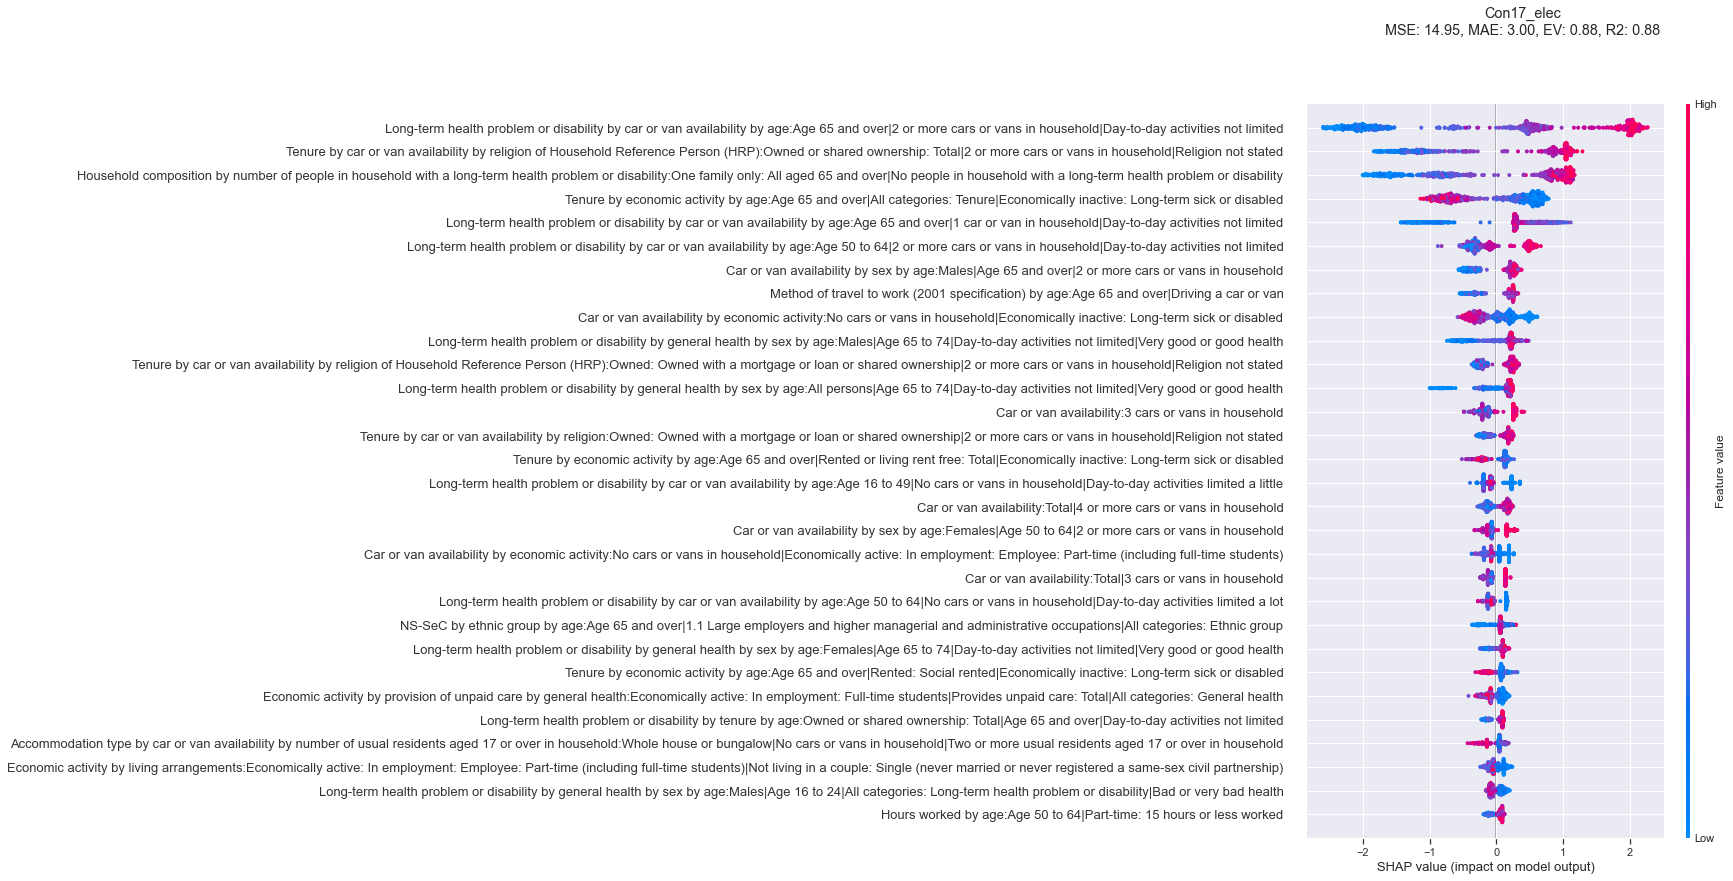

Wall time: 5min 24s


In [287]:
%%time
Treatment = var_stub

var_list = [var_stub]
var_stub_list = [var_stub,]
mask = df_simp[var_stub].notnull()
wt_cols = []
min_features = 30
colname = var_stub
dependence_plots = False

alg = get_xgboost_alg(classification_problem=False)
title = var_stub

(explainer, shap_values, train_columns, train_index, alg,output_subfolder)=\
    xgboost_run(subdir=colname,dataset=df_simp[mask].drop(wt_cols,axis=1),
            var_list=var_list,var_stub_list=var_stub_list,
            use_specific_weights=None,
            min_features = min(df_simp.shape[1]-1,min_features),verbosity=0,
            skip_bar_plot=True,dependence_plots=dependence_plots,alg=alg,eval_metric=eval_metric,                    
            title = title)

(26,) (572, 60906)


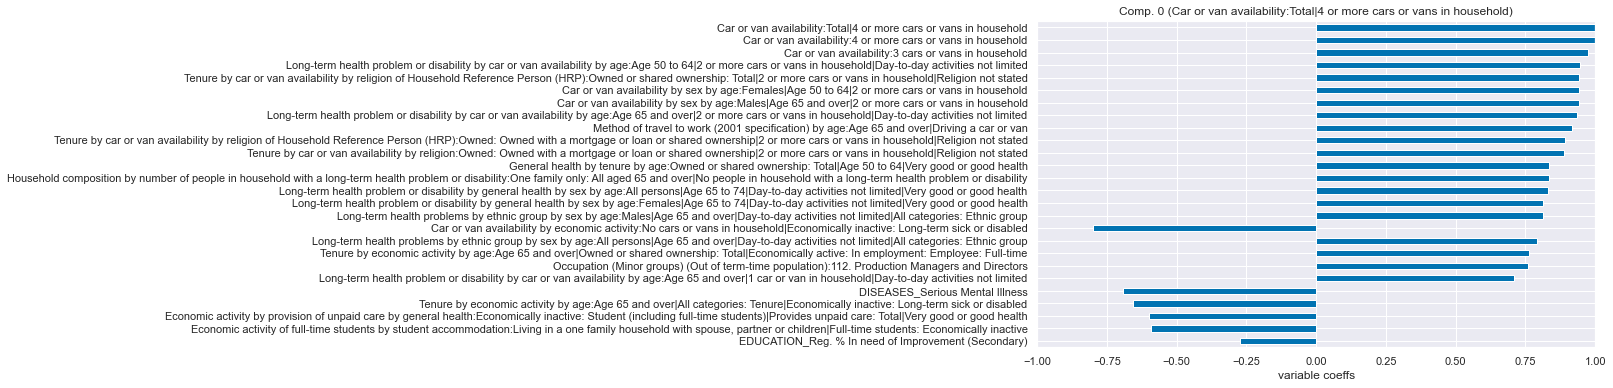

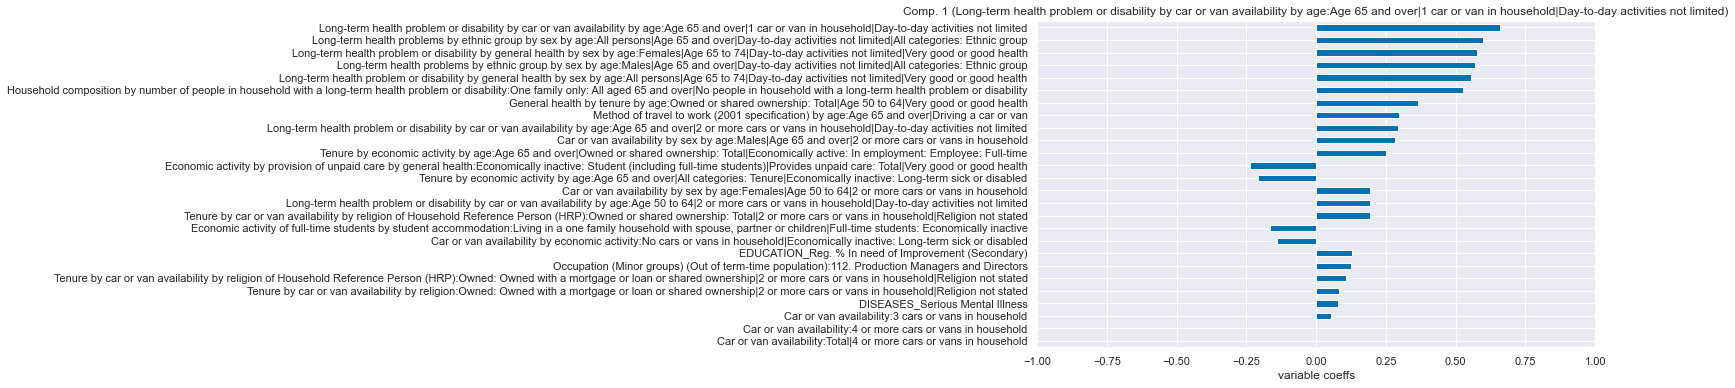

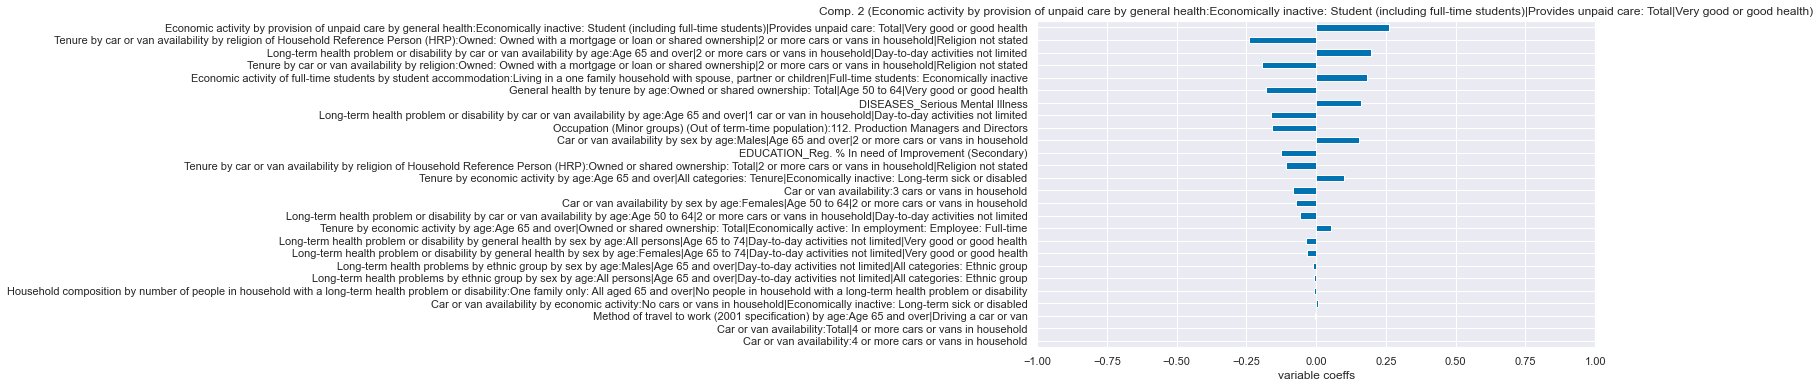

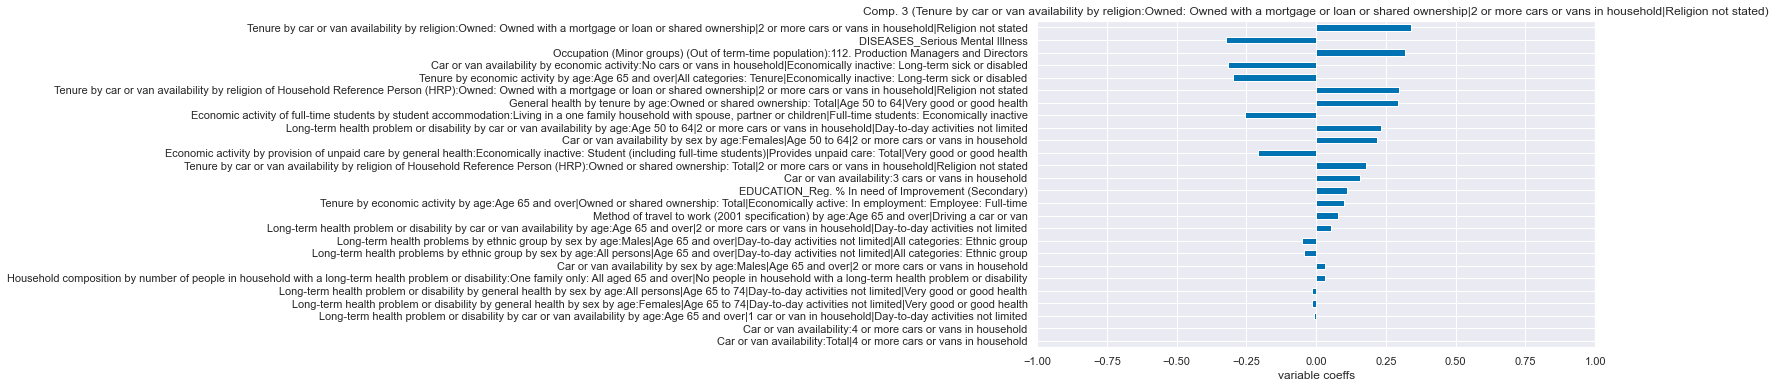

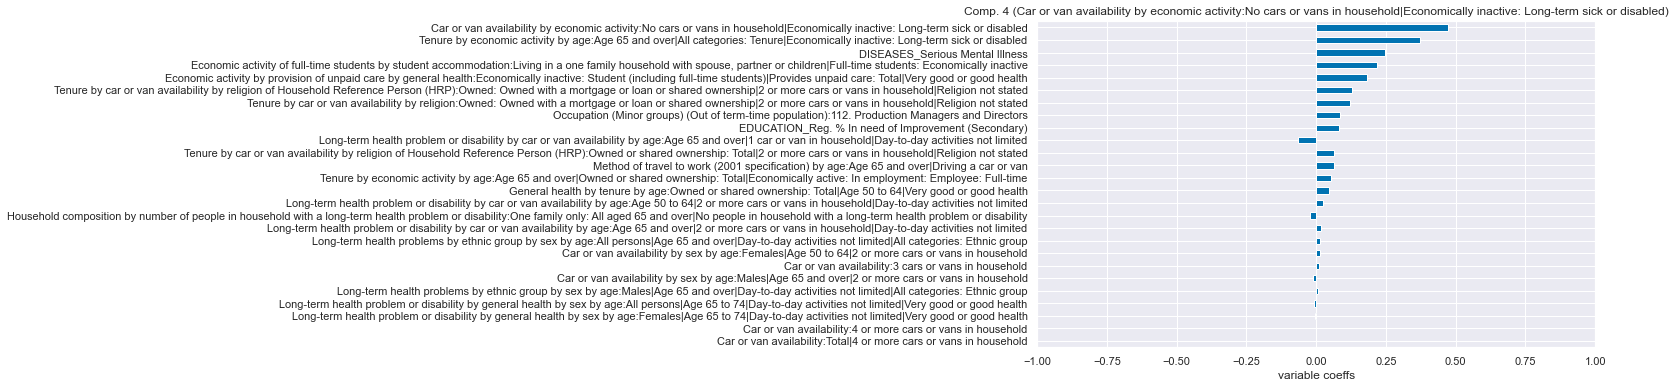

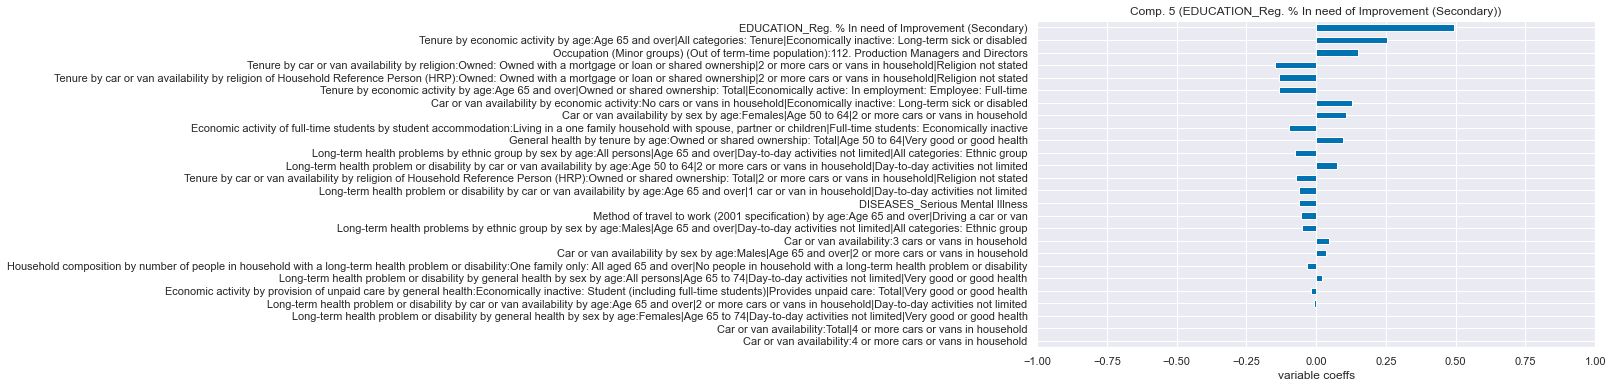

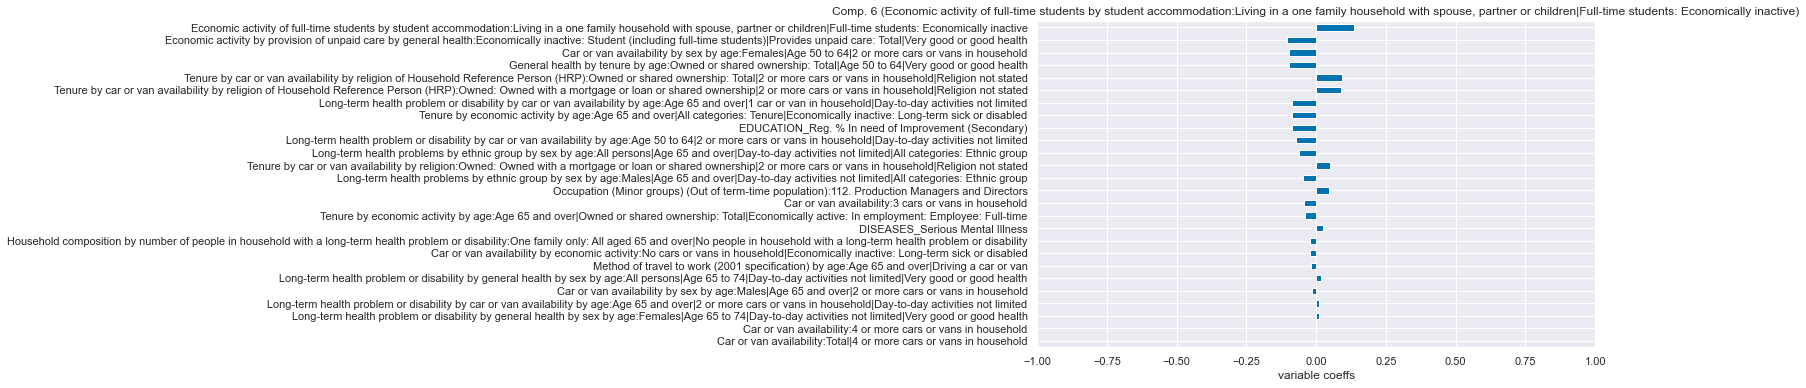

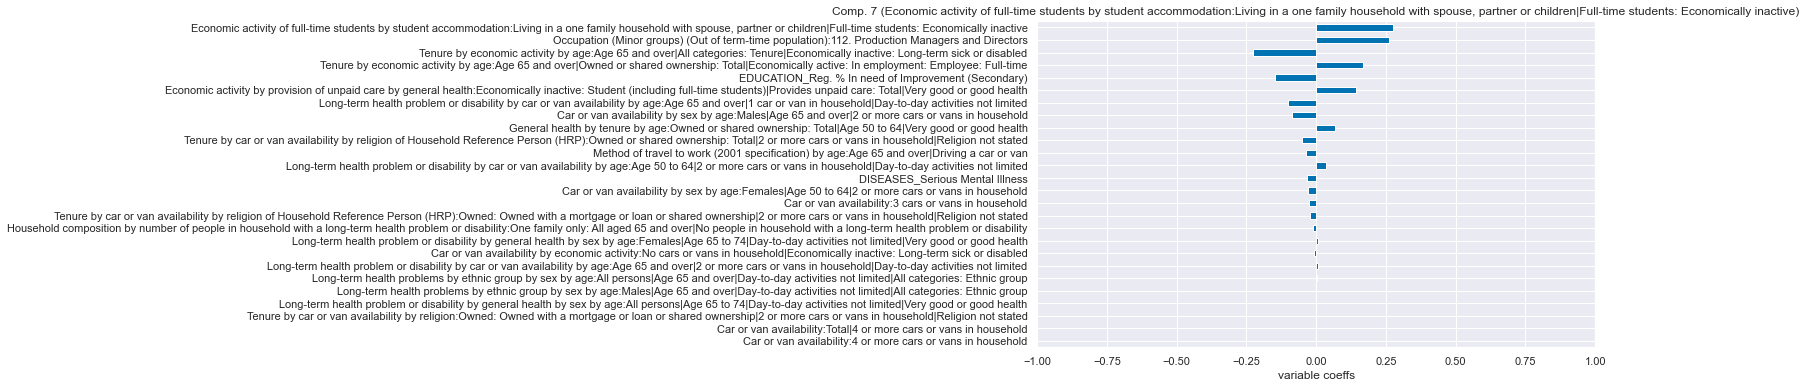

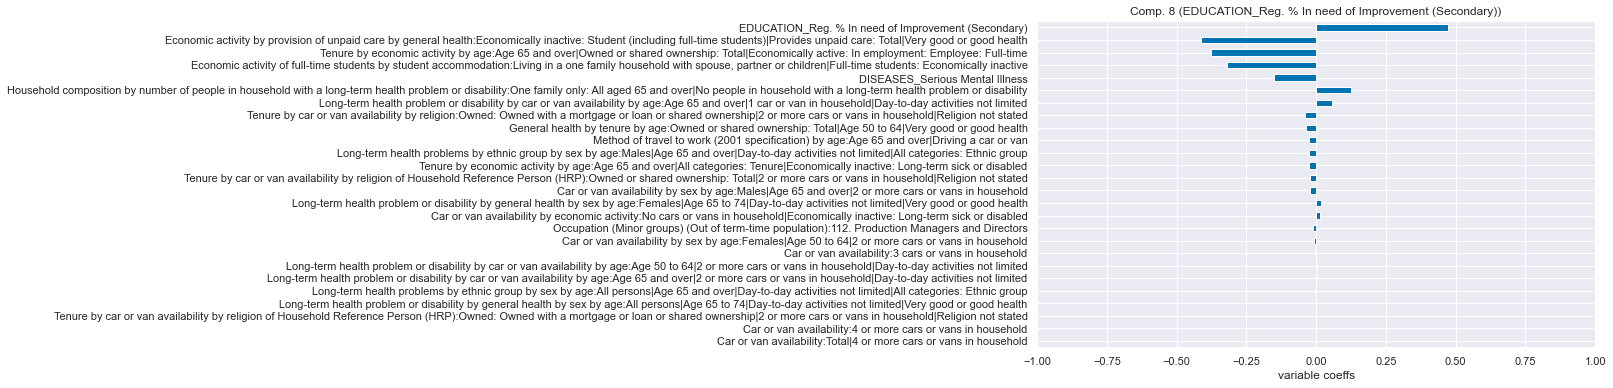

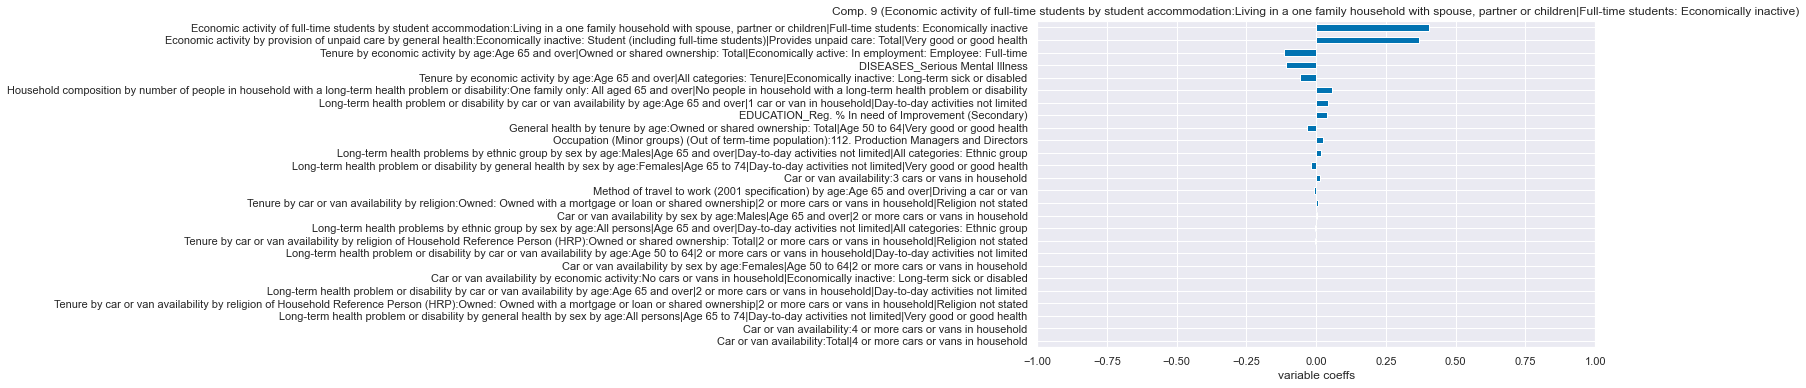

In [296]:
predictions = alg.predict(df_simp.drop(var_stub,axis=1))
MSE = mean_squared_error(df_simp[var_stub], predictions)
MAE = mean_absolute_error(df_simp[var_stub], predictions)
EV = explained_variance_score(df_simp[var_stub], predictions)
R2 = r2_score(df_simp[var_stub], predictions)

dist = pd.DataFrame(shap_values).abs().mean(axis=0).sort_values(ascending=False)
print( train_columns[dist[dist>=threshold].index].shape,df_simp.shape )

df = df_simp[train_columns[dist[dist>=threshold].index]][geomask]
df = df.fillna(df.mean())

BES_decomp, comp_labels, comp_dict = dim_red(df, n_components=n_comp,
                                               red_type="Factor Analysis",show_first_x_comps=14,display_comp=True)
n_components = min(n_comp,BES_decomp.shape[1])
Y = df_simp[var_stub]
X = BES_decomp.loc[:,0:n_components]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

MSE: 10.66, MAE: 2.59, EV: 0.91, R2: 0.91


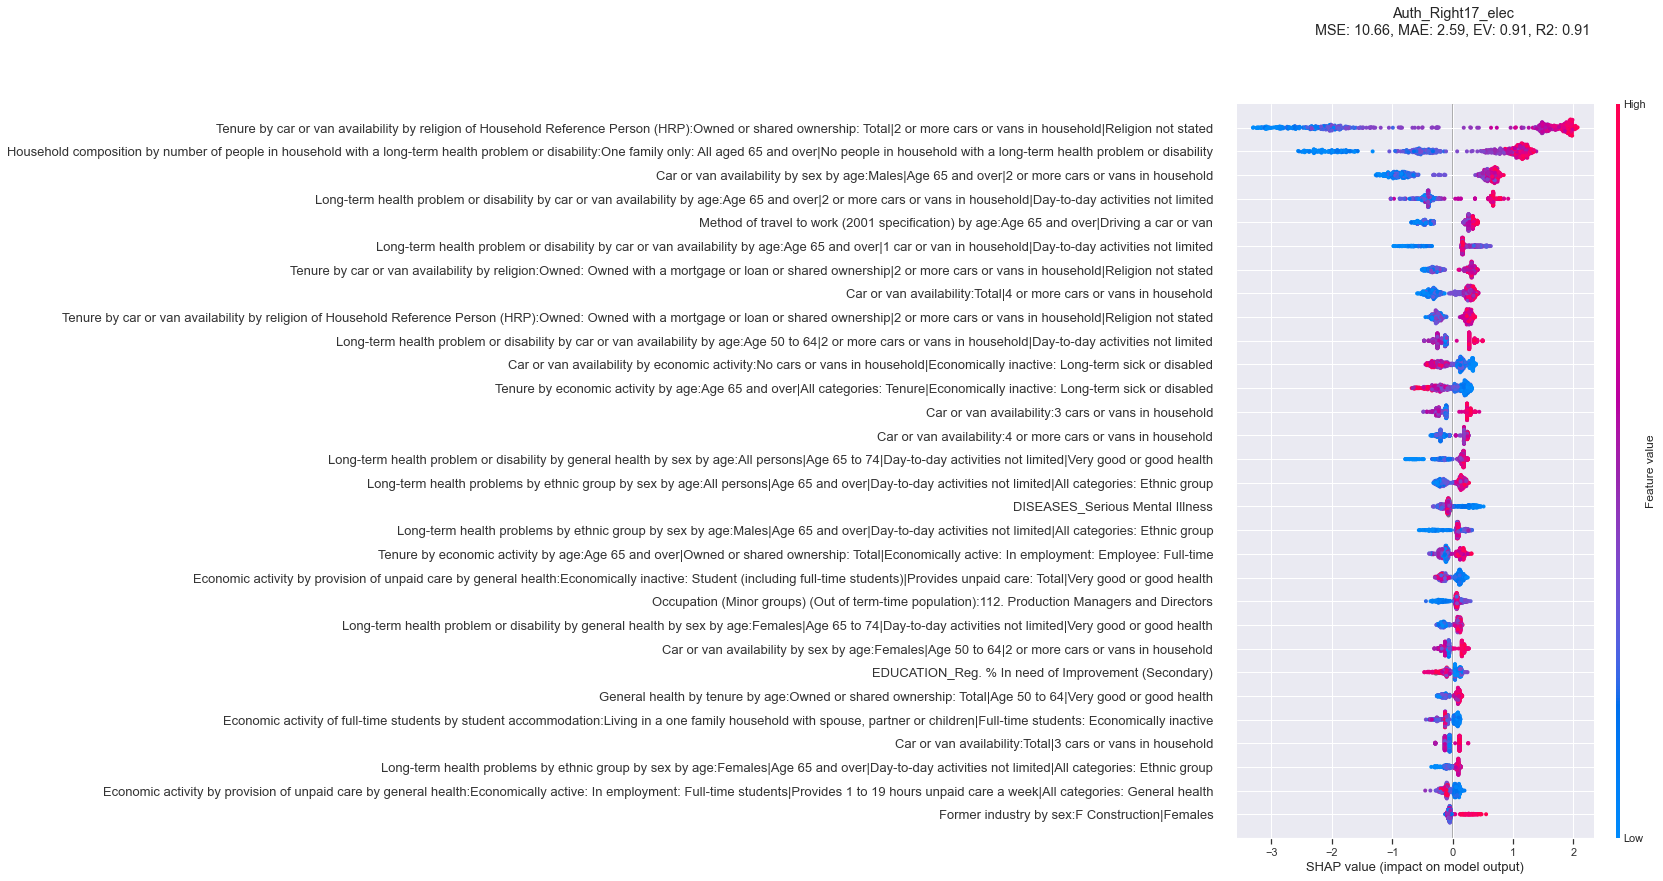

<Figure size 1152x720 with 0 Axes>

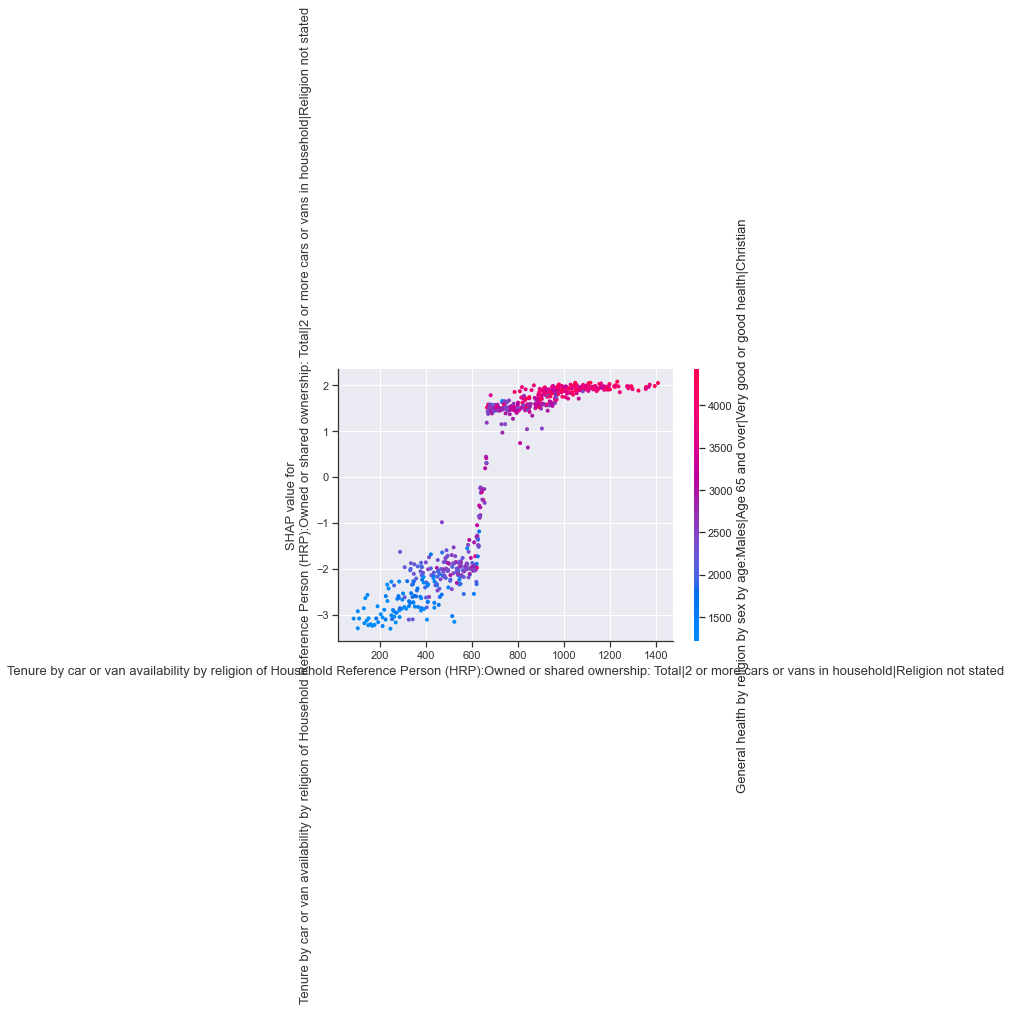

<Figure size 1152x720 with 0 Axes>

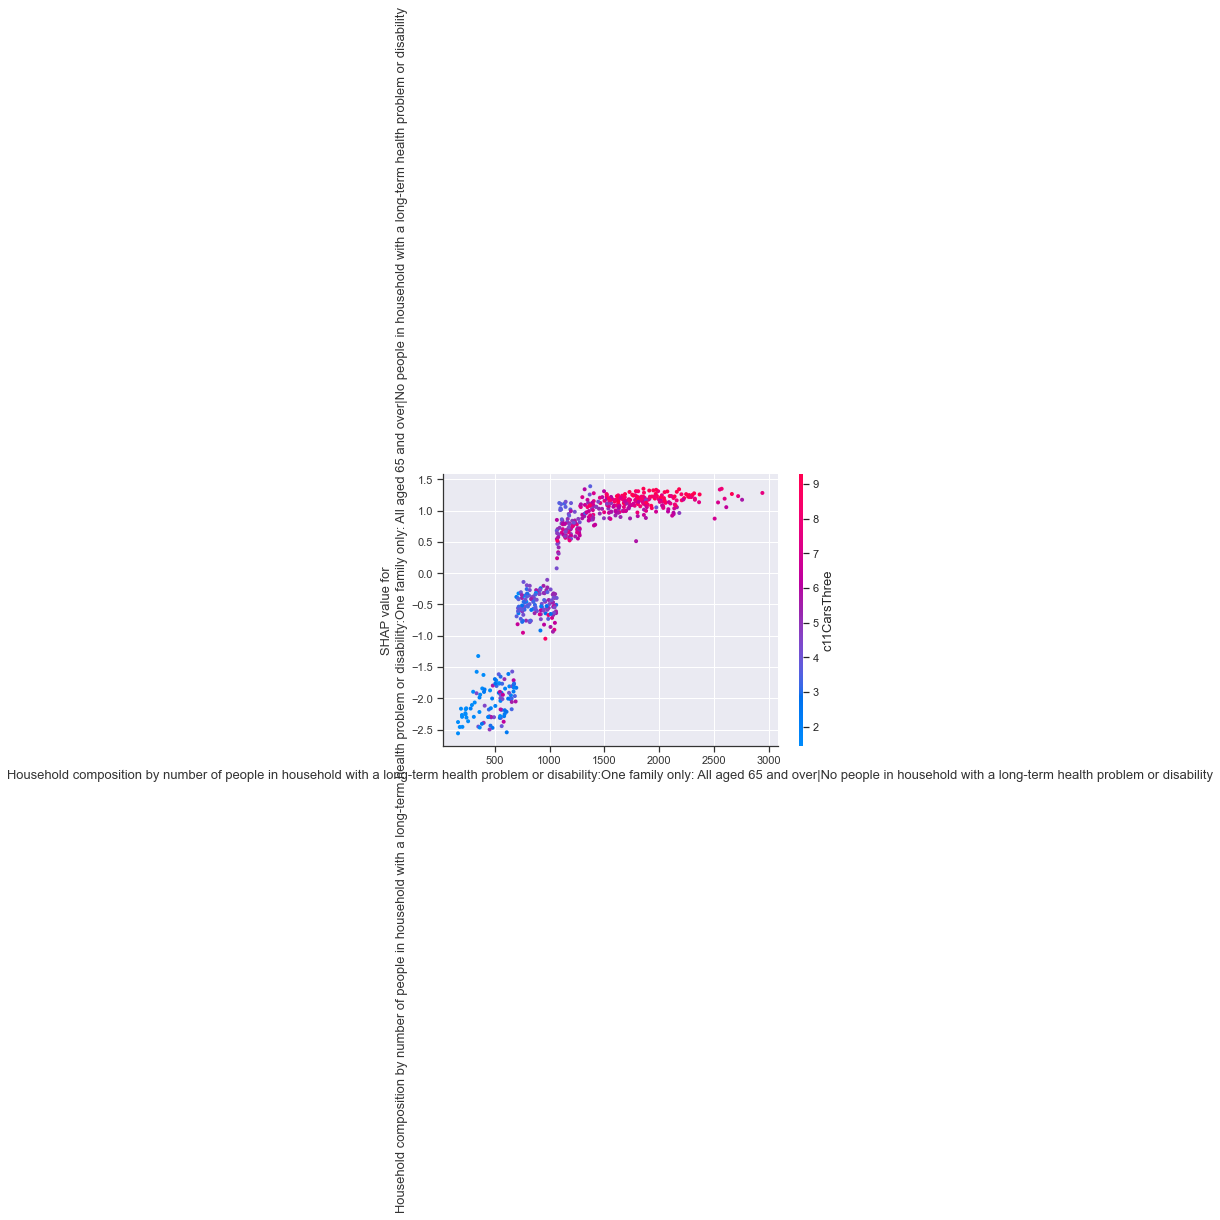

<Figure size 1152x720 with 0 Axes>

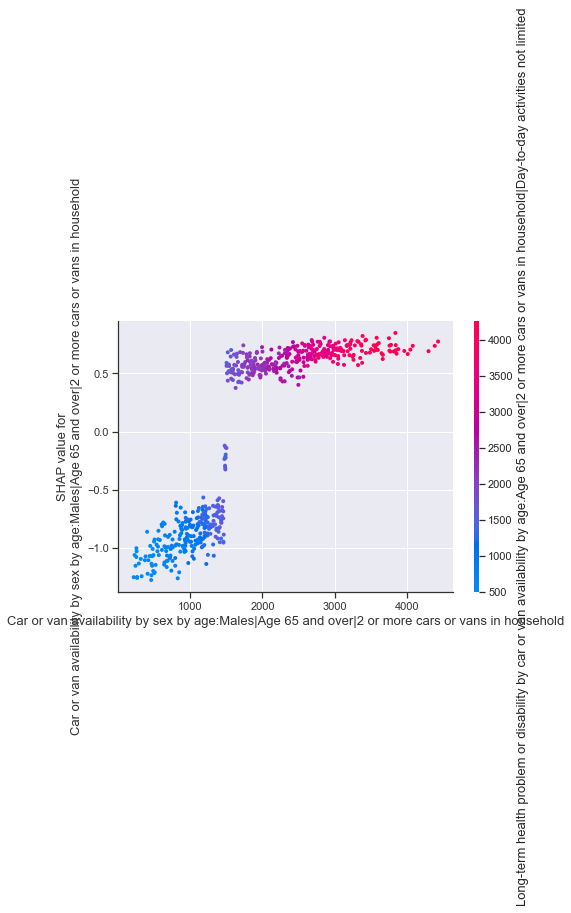

<Figure size 1152x720 with 0 Axes>

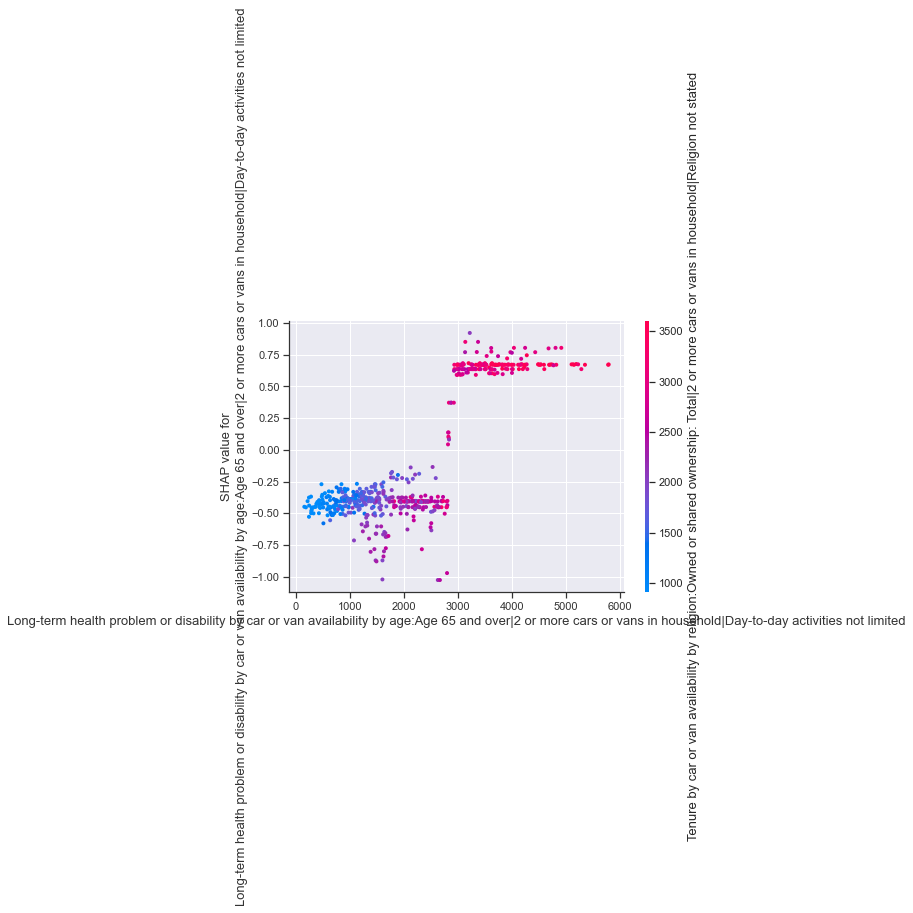

<Figure size 1152x720 with 0 Axes>

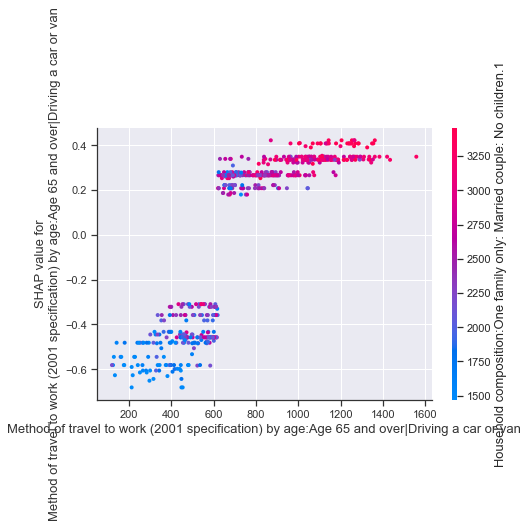

<Figure size 1152x720 with 0 Axes>

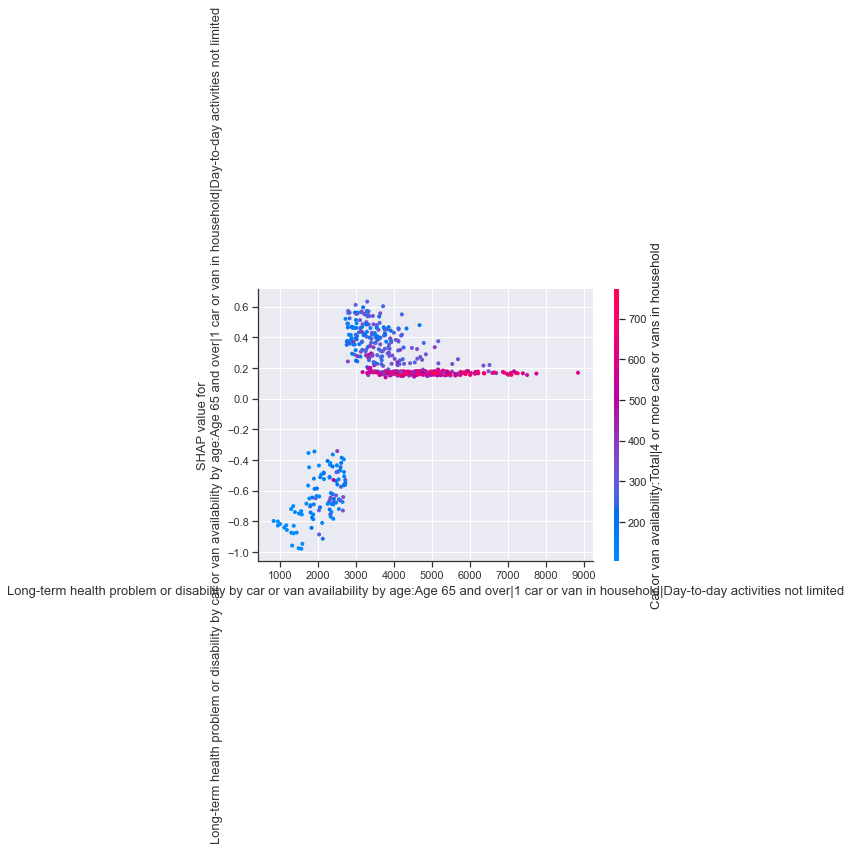

<Figure size 1152x720 with 0 Axes>

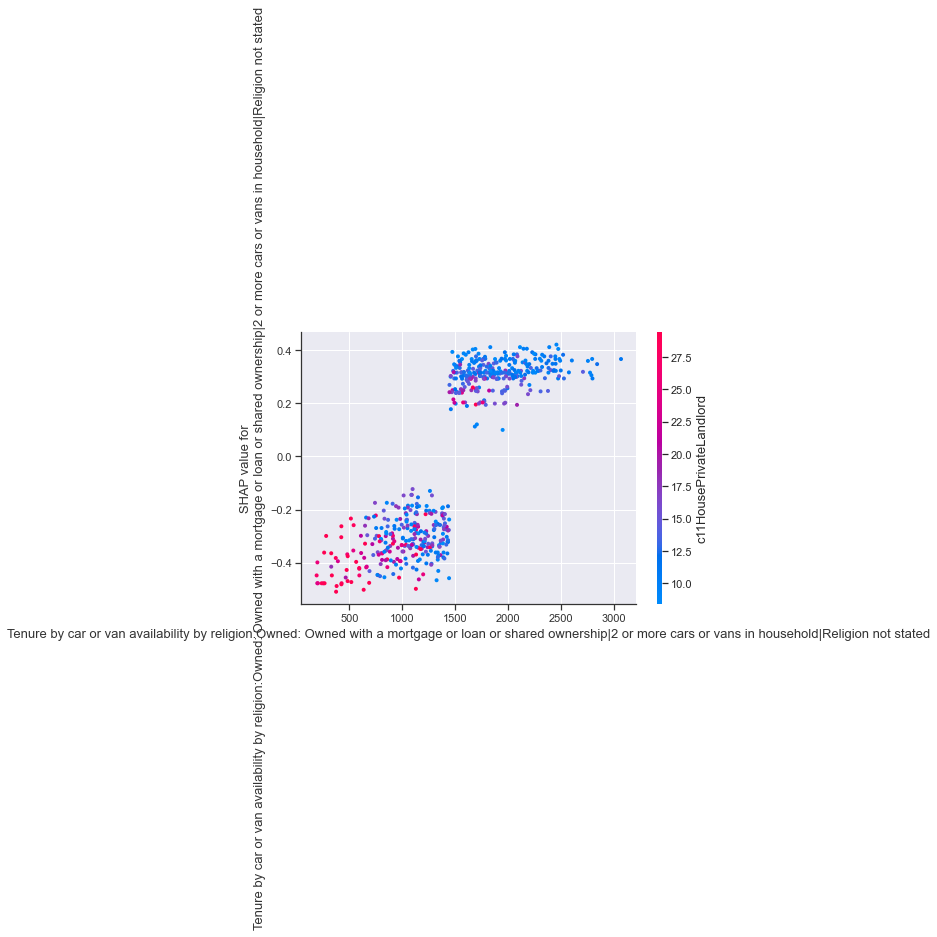

<Figure size 1152x720 with 0 Axes>

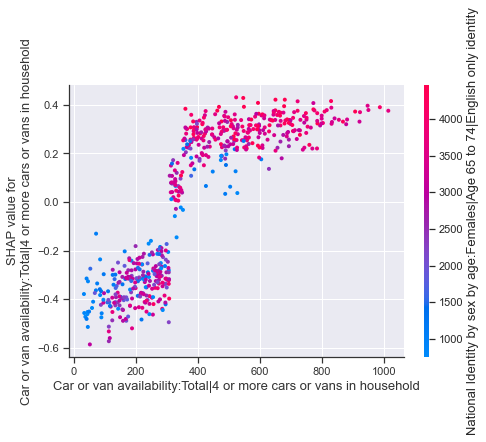

<Figure size 1152x720 with 0 Axes>

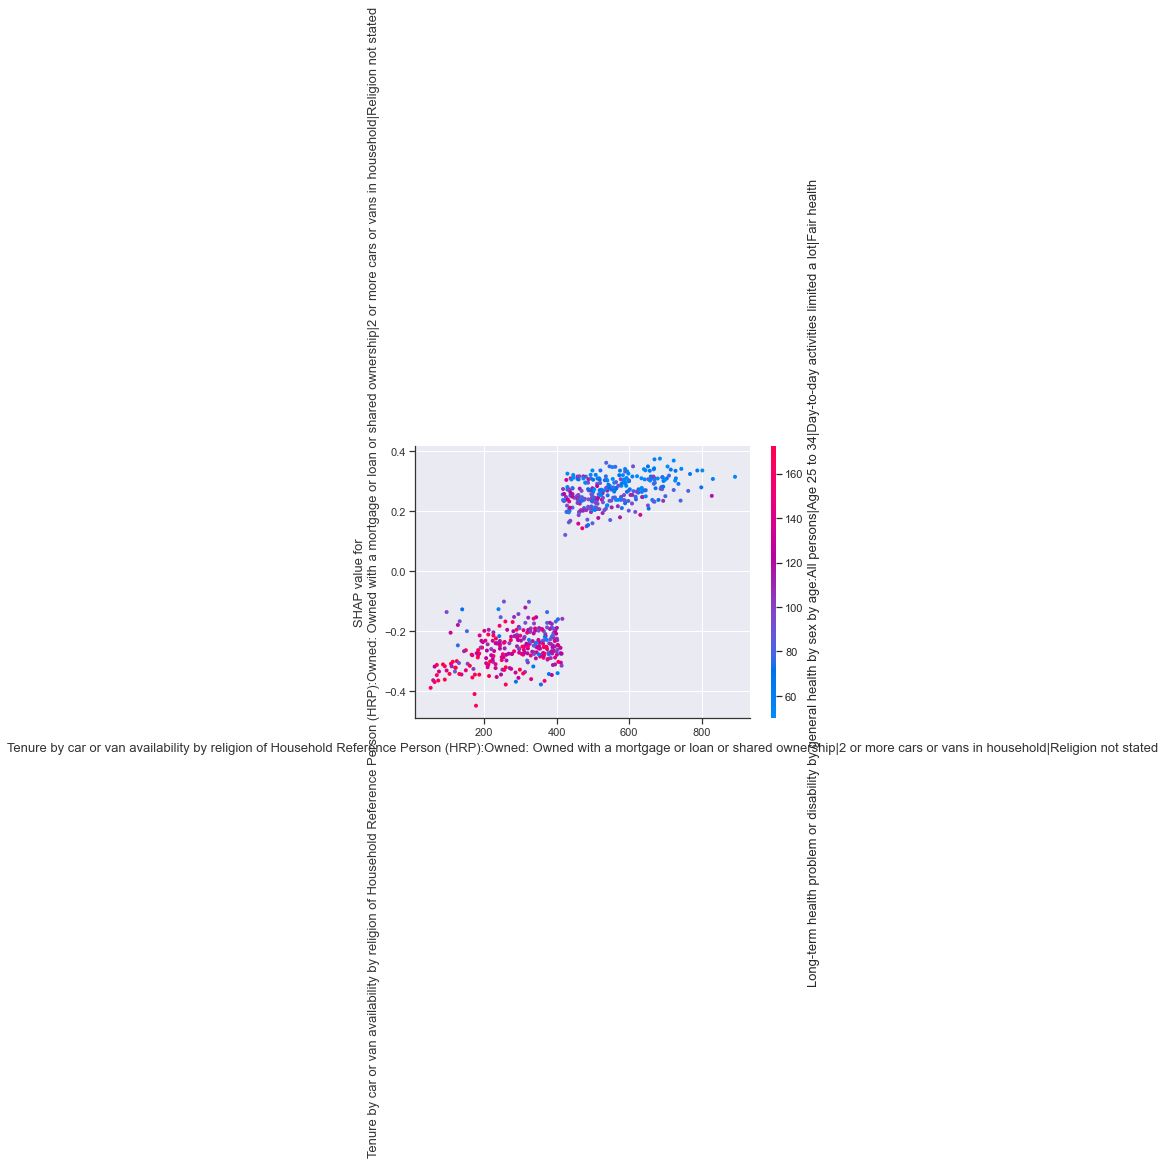

<Figure size 1152x720 with 0 Axes>

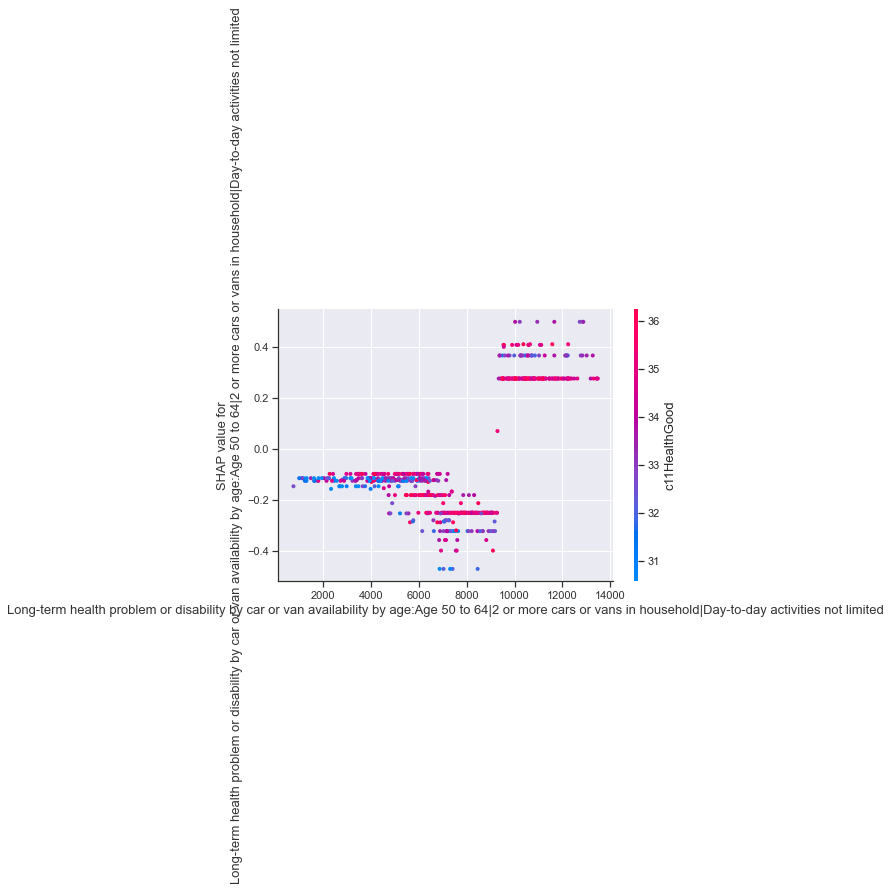

<Figure size 1152x720 with 0 Axes>

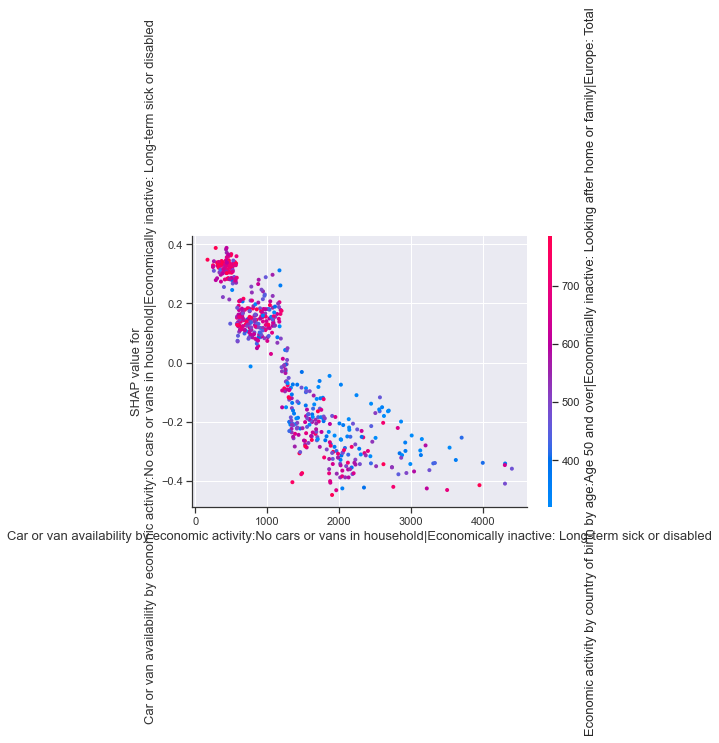

<Figure size 1152x720 with 0 Axes>

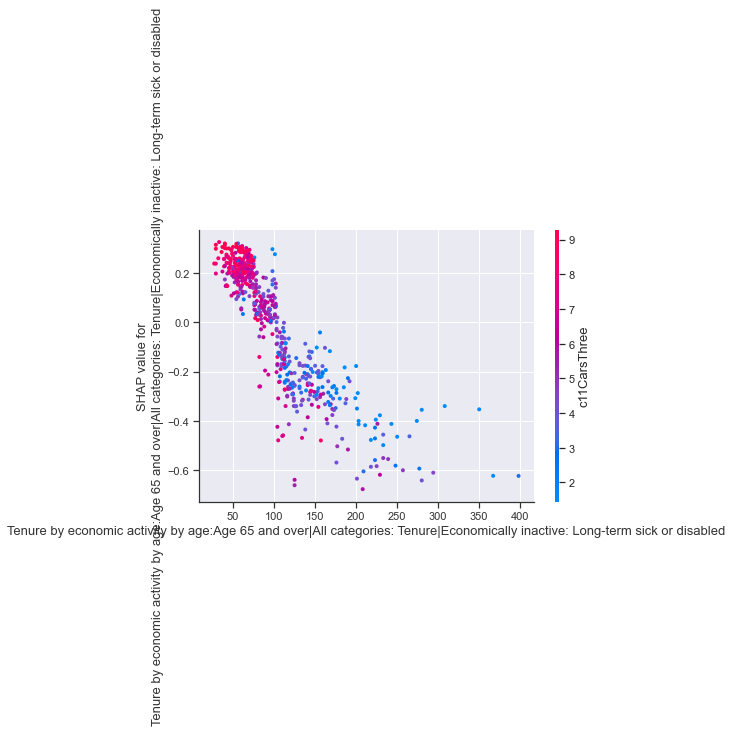

<Figure size 1152x720 with 0 Axes>

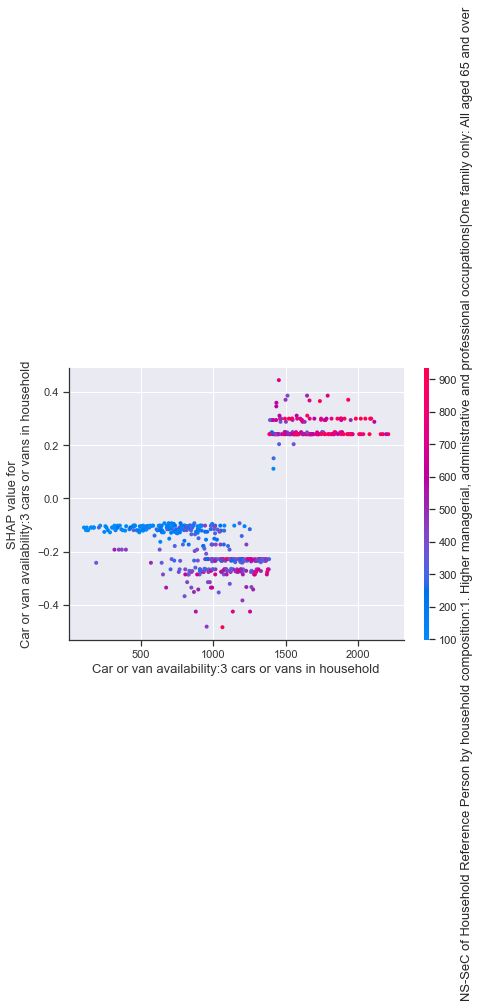

<Figure size 1152x720 with 0 Axes>

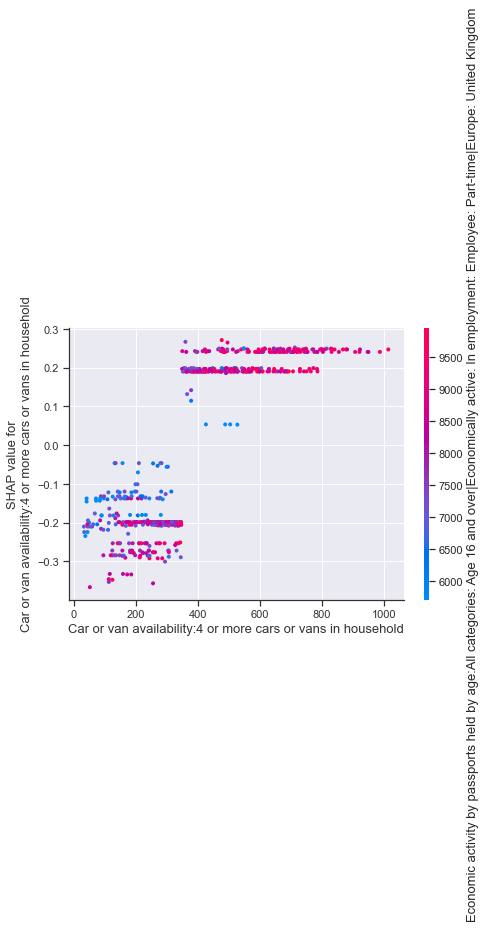

<Figure size 1152x720 with 0 Axes>

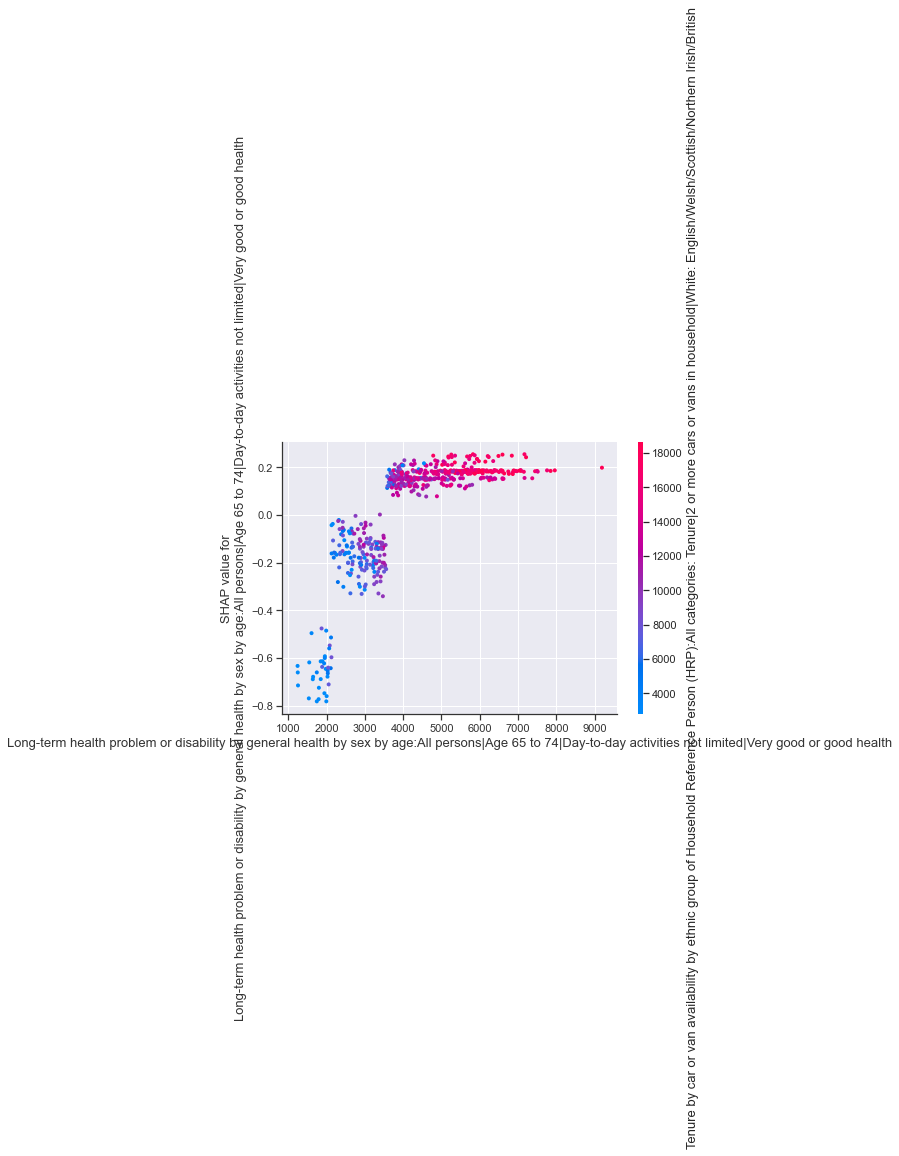

<Figure size 1152x720 with 0 Axes>

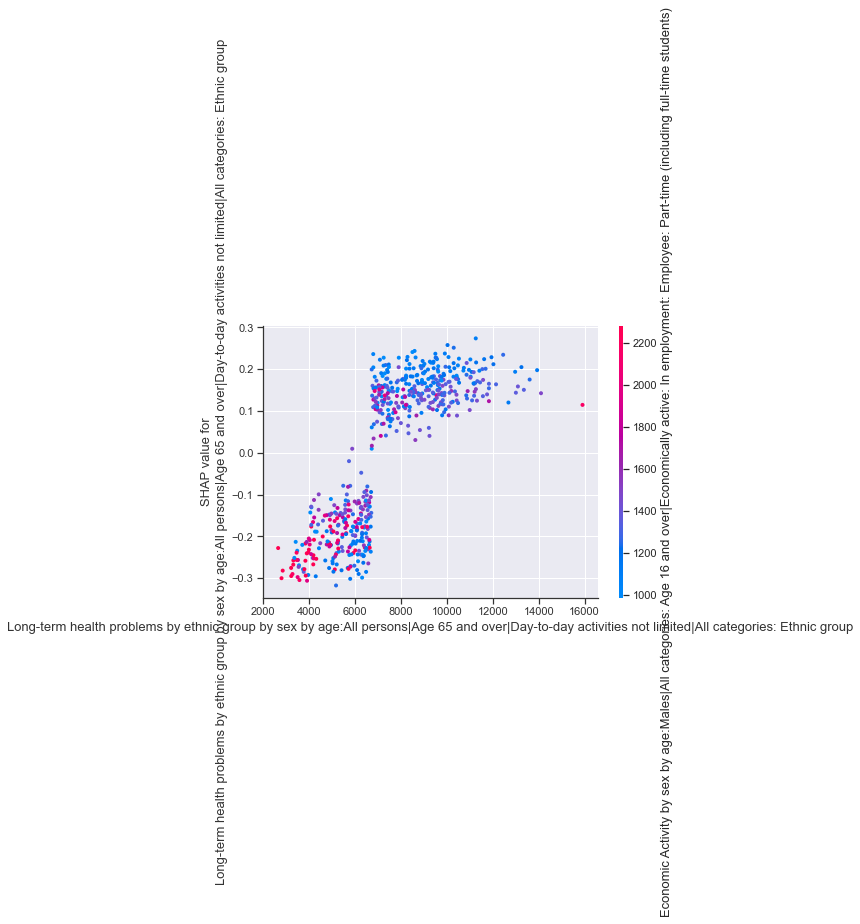

<Figure size 1152x720 with 0 Axes>

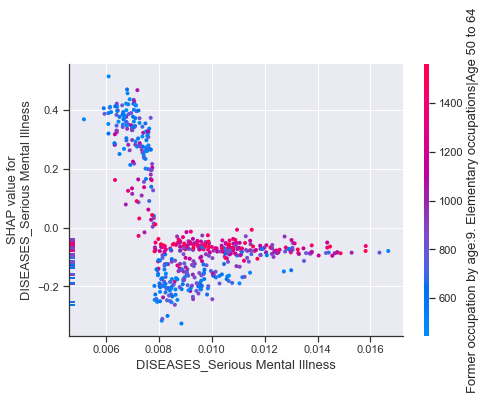

<Figure size 1152x720 with 0 Axes>

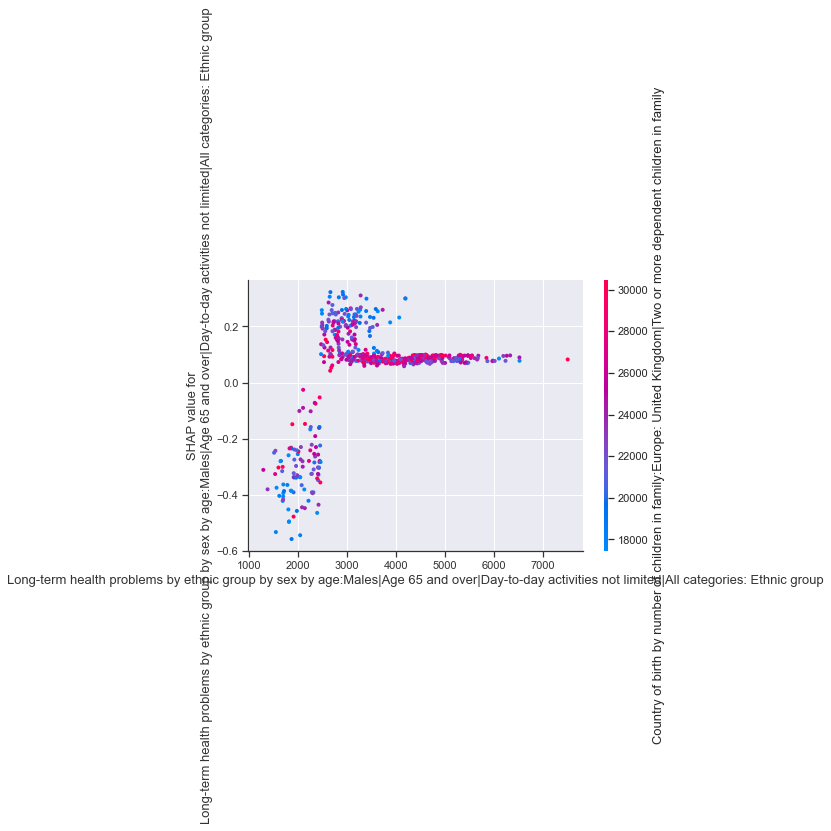

<Figure size 1152x720 with 0 Axes>

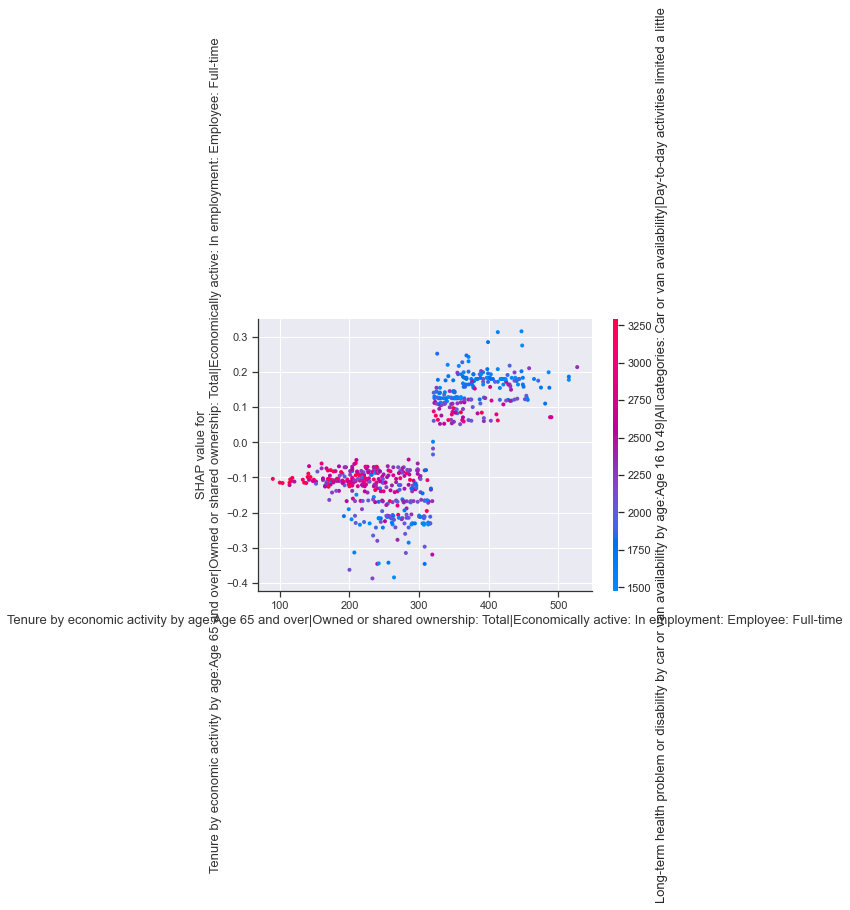

<Figure size 1152x720 with 0 Axes>

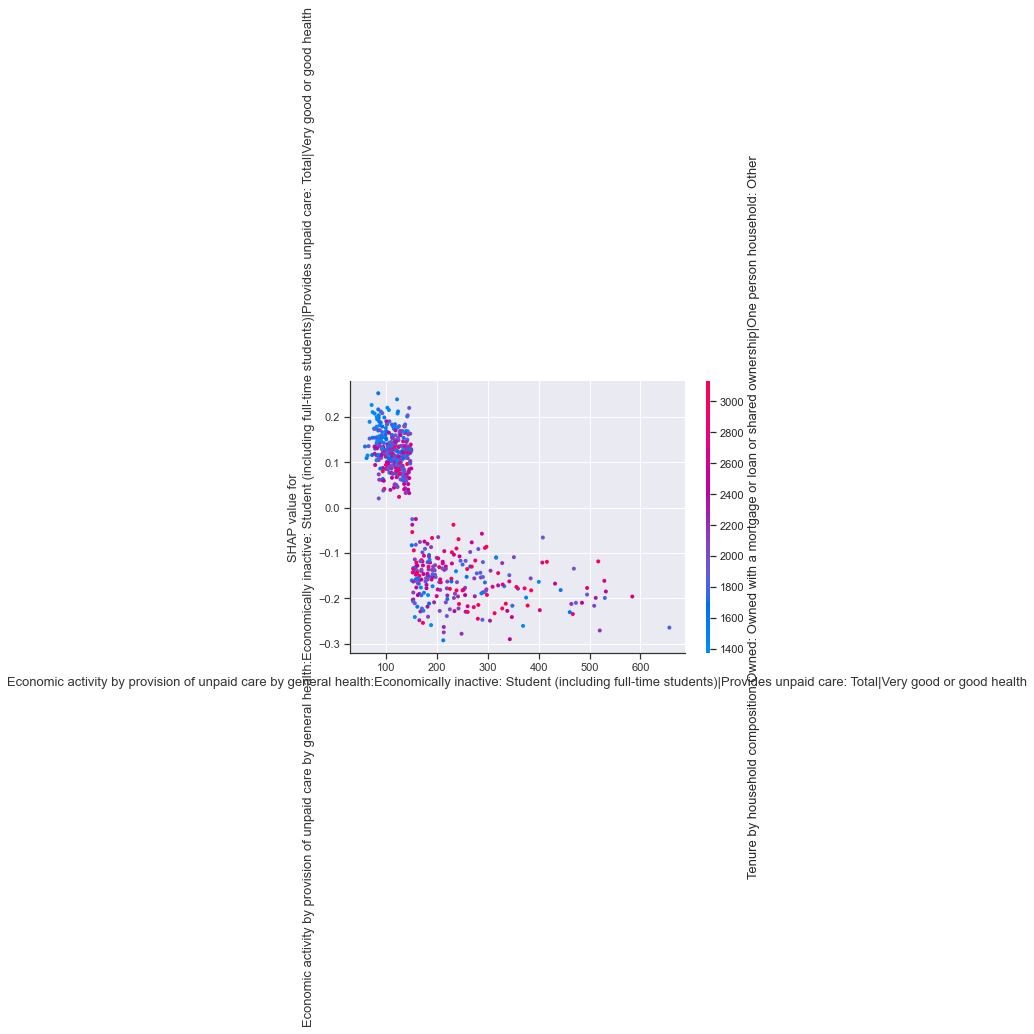

<Figure size 1152x720 with 0 Axes>

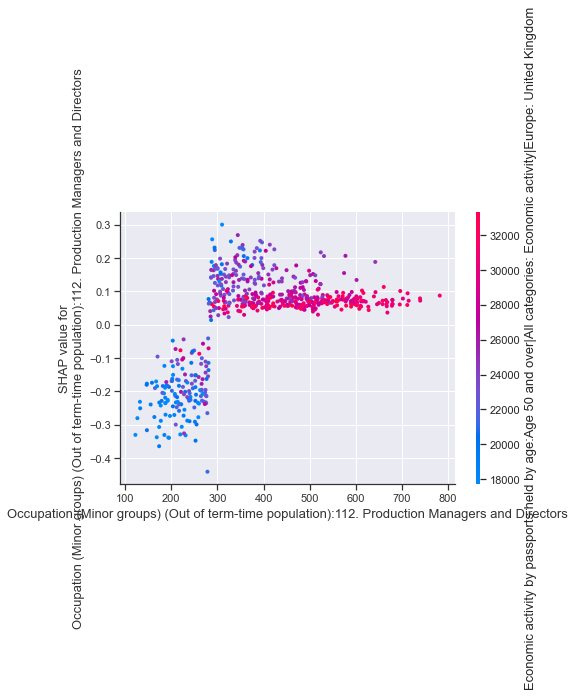

<Figure size 1152x720 with 0 Axes>

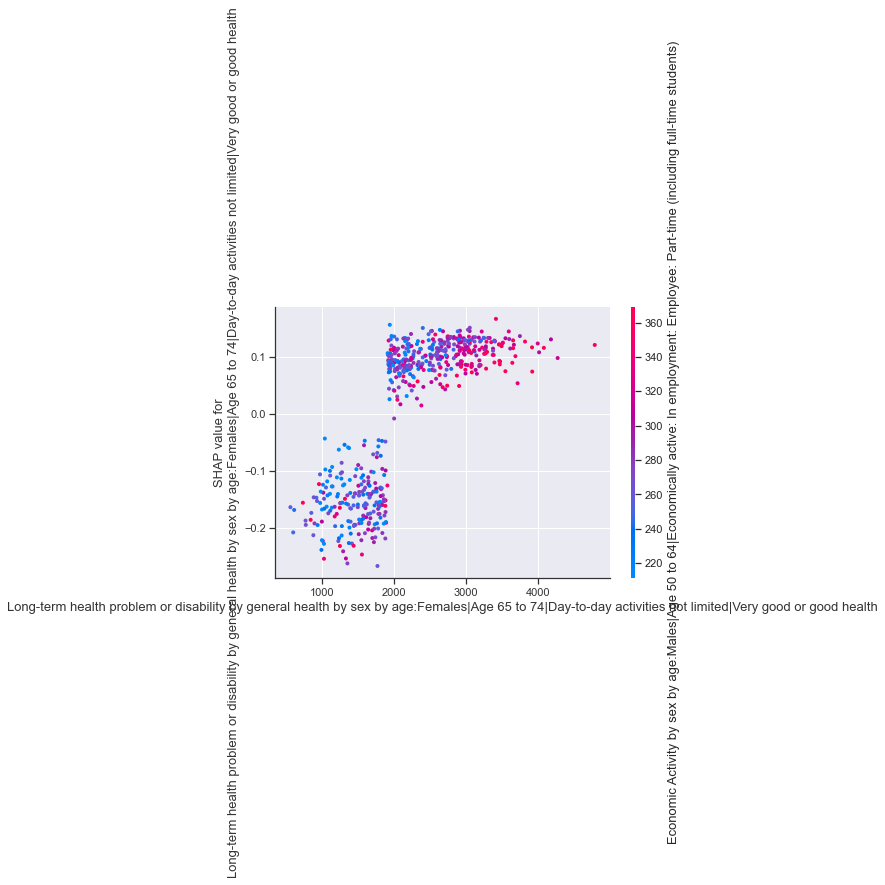

<Figure size 1152x720 with 0 Axes>

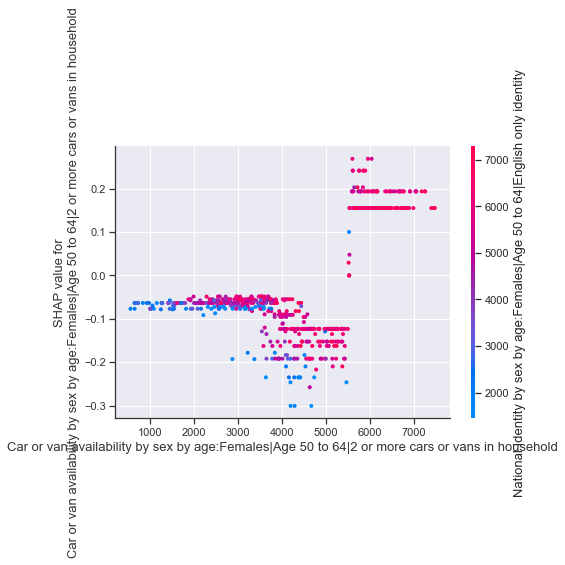

<Figure size 1152x720 with 0 Axes>

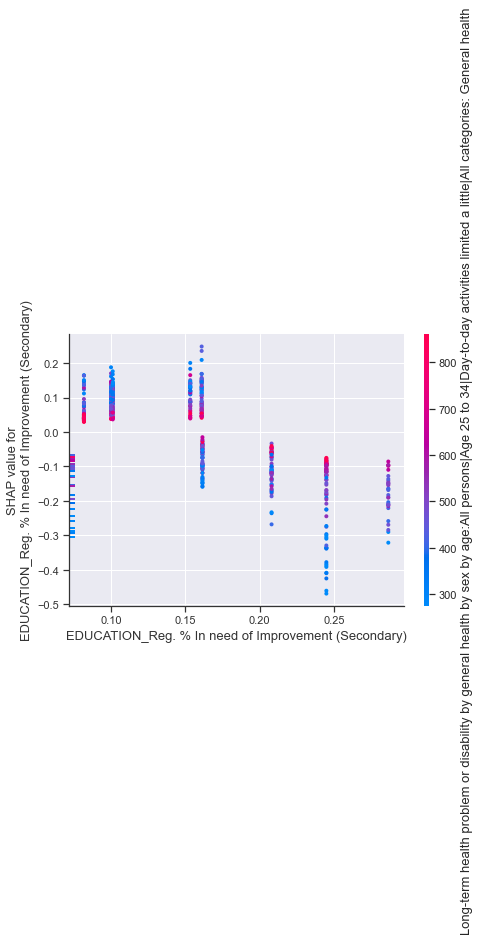

<Figure size 1152x720 with 0 Axes>

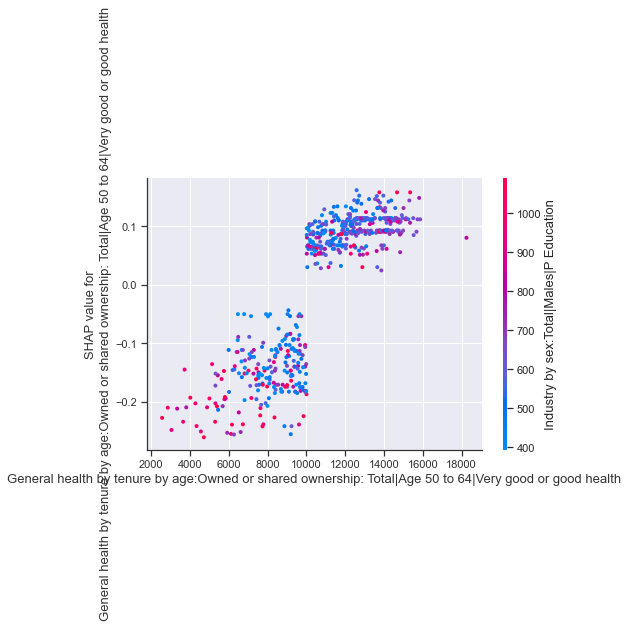

<Figure size 1152x720 with 0 Axes>

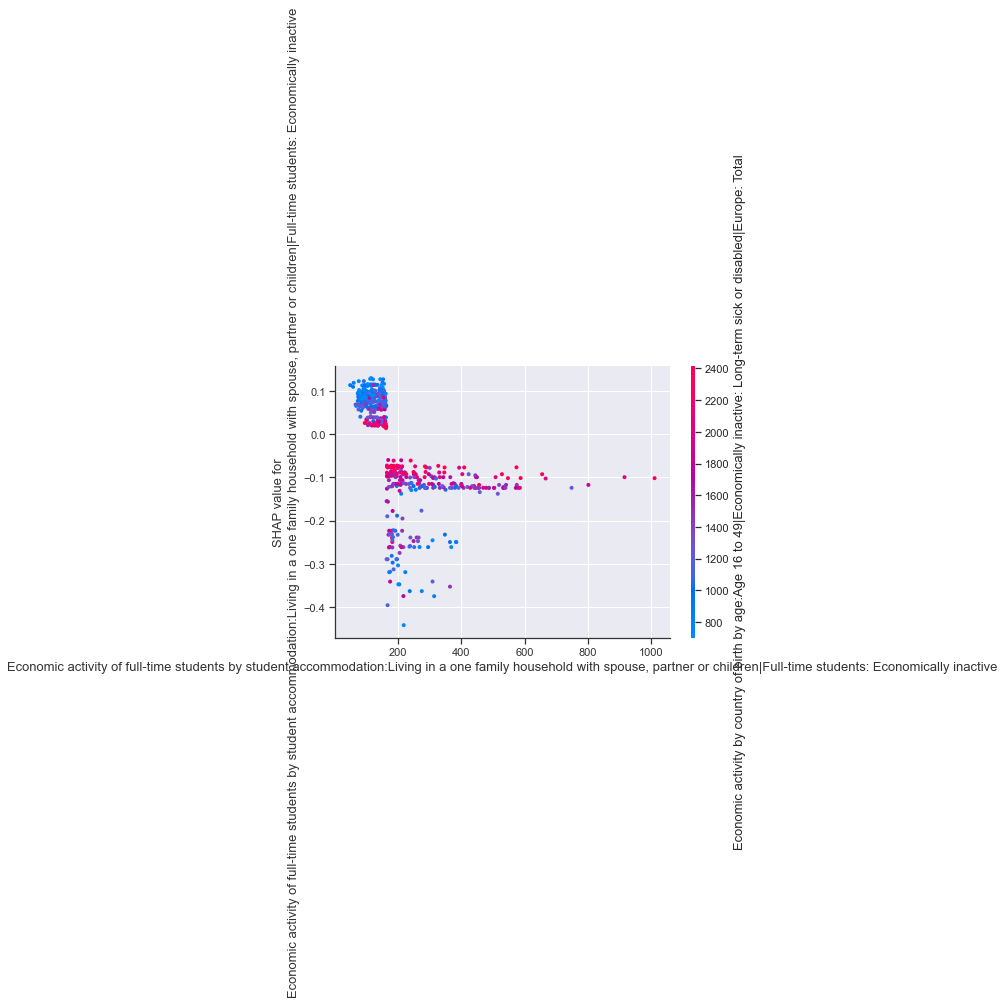

<Figure size 1152x720 with 0 Axes>

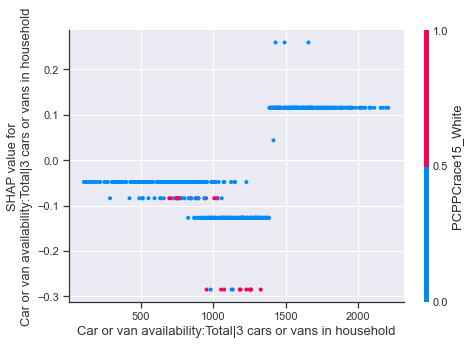

<Figure size 1152x720 with 0 Axes>

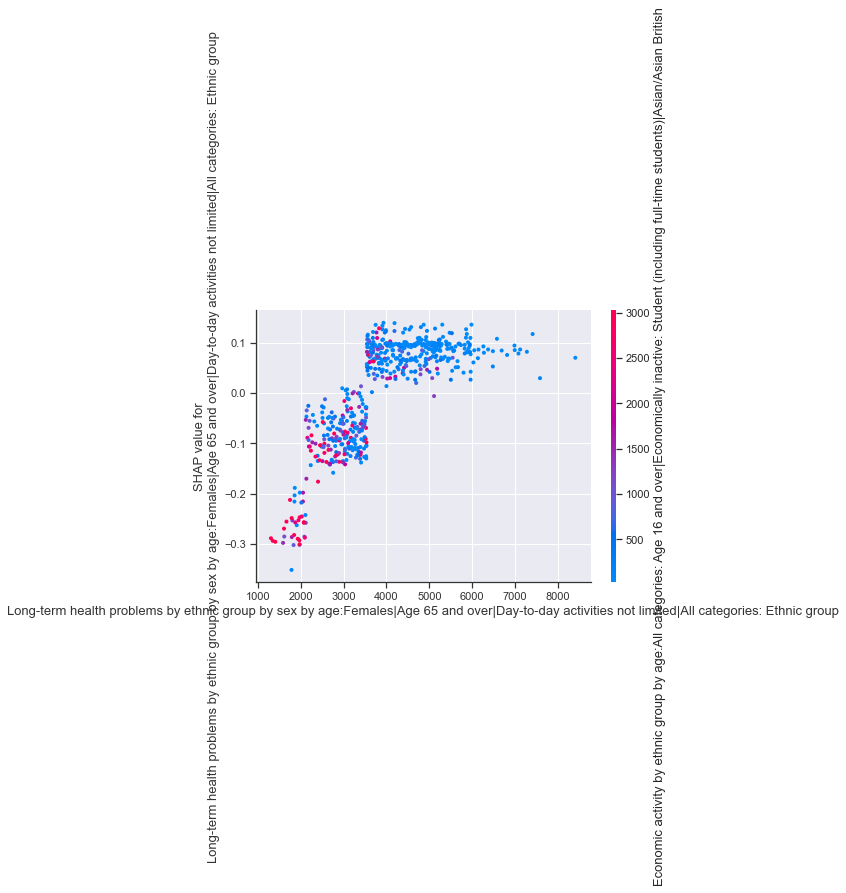

<Figure size 1152x720 with 0 Axes>

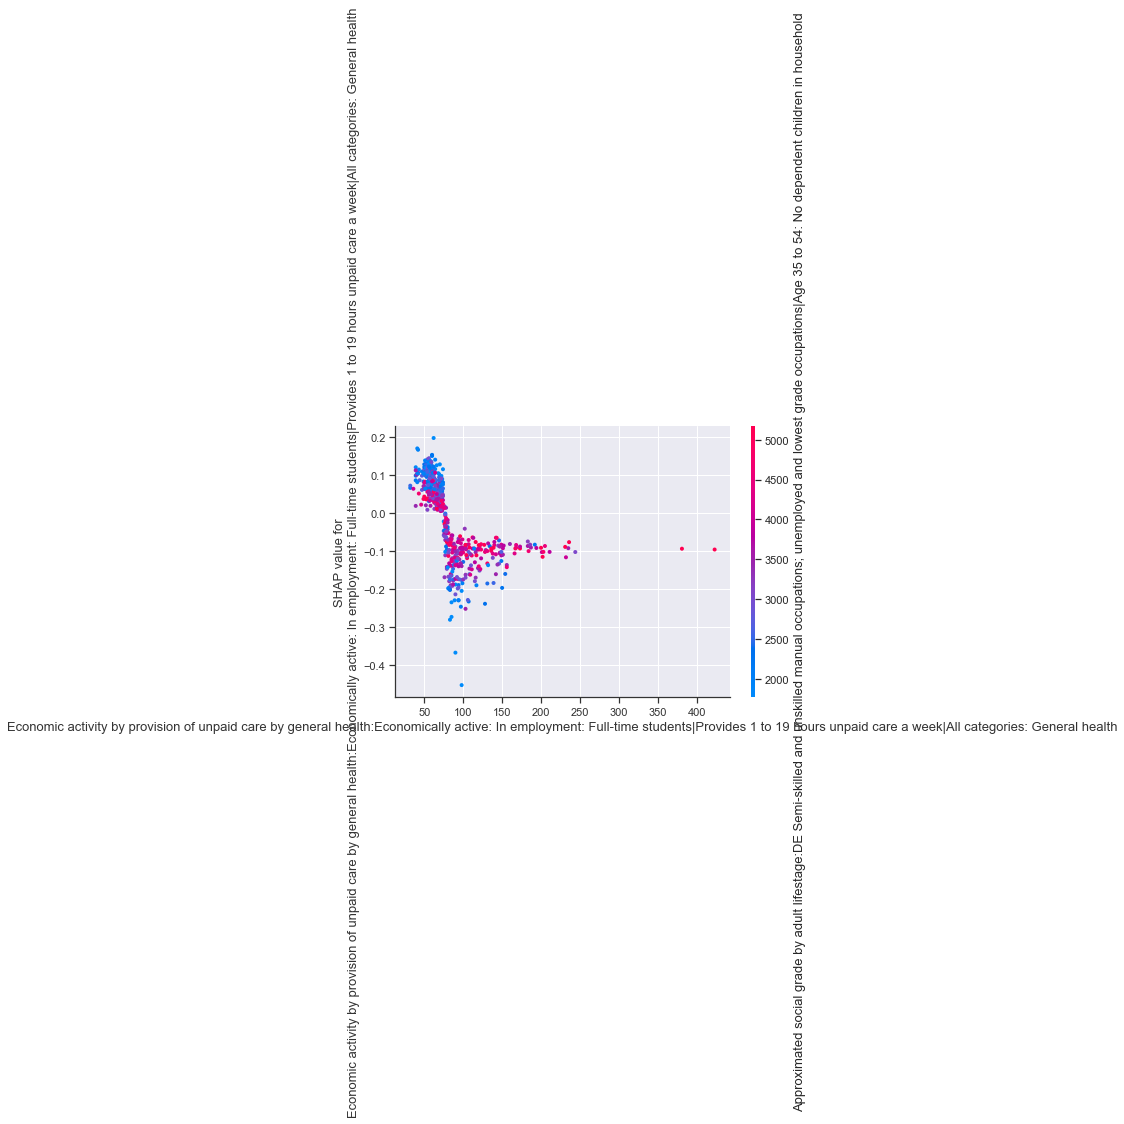

<Figure size 1152x720 with 0 Axes>

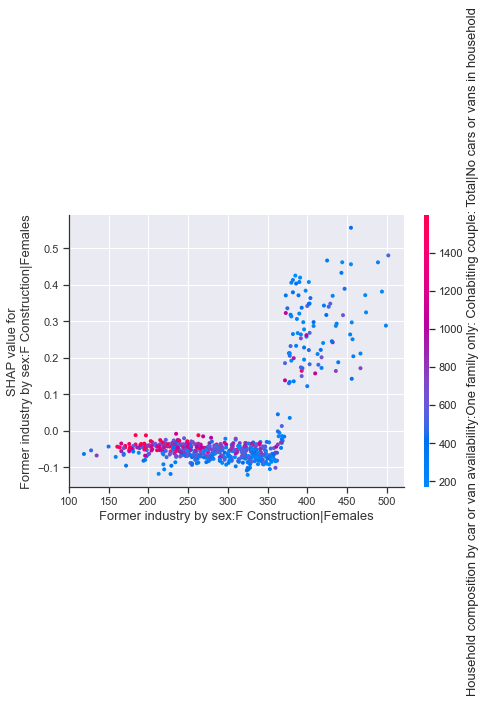

Wall time: 44min 16s


In [290]:
%%time
Treatment = var_stub

var_list = [var_stub]
var_stub_list = [var_stub,]
mask = df_simp[var_stub].notnull()
wt_cols = []
min_features = 30
colname = var_stub
dependence_plots = True

alg = get_xgboost_alg(classification_problem=False)
title = var_stub

(explainer, shap_values, train_columns, train_index, alg,output_subfolder)=\
    xgboost_run(subdir=colname,dataset=df_simp[mask].drop(wt_cols,axis=1),
            var_list=var_list,var_stub_list=var_stub_list,
            use_specific_weights=None,
            min_features = min(df_simp.shape[1]-1,min_features),verbosity=0,
            skip_bar_plot=True,dependence_plots=dependence_plots,alg=alg,eval_metric=eval_metric,                    
            title = title)

In [457]:
%%time
# var_stub = "Auth_Right17_elec"
geomask = (BES_census_data["Country"]!="Scotland")&(BES_census_data["Winner17"]!="Speaker")
df_simp = pd.get_dummies(BES_census_data.drop(drop_cols,axis=1))
# df_simp[var_stub] = BES_census_data[var_stub]

# BES_agg_cols = BES_constituency_aggregates.drop(search(BES_constituency_aggregates,"|".join(["winConstituency","profile_past","ashcroft","partyContact",
#                                                        "partyId","localElection","localTurnout","^map",
#                                                        "generalElectionVote","euroElectionVote",
#                                                        "^prefer[^M]","ptv"])).index,axis=1).columns
# df_simp[BES_agg_cols] = BES_constituency_aggregates[BES_agg_cols].values

# df_simp.loc[BES_census_data["Country"]!="Scotland",nomis_dump.columns] = nomis_dump.values

df_simp = df_simp[geomask]


Wall time: 94.8 ms


In [336]:
alg.max_depth=10
alg.min_child_weight=1
alg.learning_rate=0.05

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
             colsample_bynode=0.85, colsample_bytree=0.7, gamma=0.000650000002,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=6, min_split_loss=0.00065, missing=nan,
             monotone_constraints='()', n_estimators=1638, n_jobs=8, nthread=8,
             num_parallel_tree=1, random_state=729, refresh_leaf=0,
             reg_alpha=1.075, reg_lambda=1.011, scale_pos_weight=1.09,
             sketch_eps=0.0, subsample=0.8, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [347]:
alg = get_xgboost_alg(classification_problem=False)
alg

XGBRegressor(base_score=None, booster=None, colsample_bylevel=0.9,
             colsample_bynode=0.85, colsample_bytree=0.7, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=None, max_depth=6,
             min_child_weight=6, min_split_loss=0.00065, missing=nan,
             monotone_constraints=None, n_estimators=500, n_jobs=8, nthread=8,
             num_parallel_tree=None, random_state=729, refresh_leaf=0,
             reg_alpha=1.075, reg_lambda=1.011, scale_pos_weight=1.09,
             sketch_eps=0.0, subsample=0.8, tree_method=None,
             validate_parameters=None, verbosity=None)

In [366]:
alg

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=34, n_jobs=6, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

MSE: 13.38, MAE: 2.82, EV: 0.89, R2: 0.89


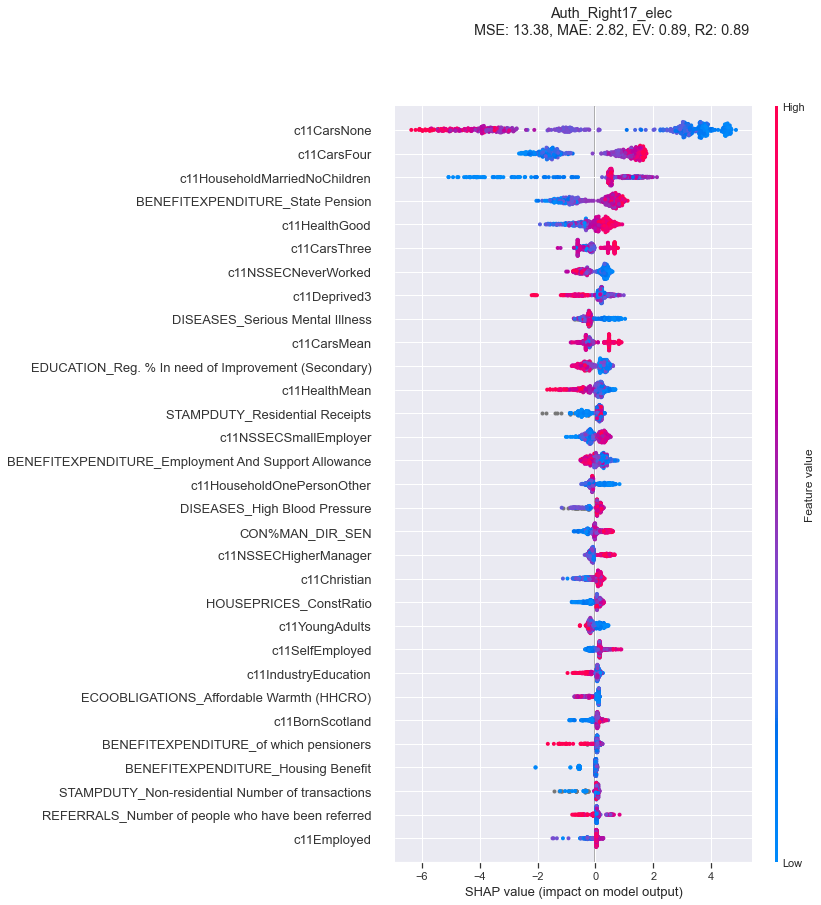

Wall time: 41.2 s


In [367]:
%%time
Treatment = var_stub

var_list = [var_stub]
var_stub_list = [var_stub,]
mask = df_simp[var_stub].notnull()
wt_cols = []
min_features = 30
colname = var_stub
dependence_plots = False

alg = get_xgboost_alg(classification_problem=False)
# alg.n_estimators =alg.n_estimators*10
# alg.max_depth=10
# alg.min_child_weight=1
alg = XGBRegressor(n_estimators=500)
alg.learning_rate=0.05
title = var_stub

(explainer, shap_values, train_columns, train_index, alg,output_subfolder)=\
    xgboost_run(subdir=colname,dataset=df_simp[mask].drop(wt_cols,axis=1),
            var_list=var_list,var_stub_list=var_stub_list,
            use_specific_weights=None,
            min_features = min(df_simp.shape[1]-1,min_features),verbosity=0,
            skip_bar_plot=True,dependence_plots=dependence_plots,alg=alg,eval_metric=eval_metric,                    
            title = title)

(267,) (572, 6425)
1.2523764462624039e-05 0.0026571908391448827 0.9999999001589573 0.9999999001588651


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Auth_Right17_elec   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     333.4
Date:                Sat, 29 Jan 2022   Prob (F-statistic):          1.25e-228
Time:                        17:26:59   Log-Likelihood:                -1639.3
No. Observations:                 572   AIC:                             3301.
Df Residuals:                     561   BIC:                             3348.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================================
                                                                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
const                                                                     32.1303      0.179    179.048      0.000      31.778      32.483
Comp. 0 (c11Elderly)                                                       7.8958      0.179     43.988      0.000       7.543       8.248
Comp. 1 (c11NSSECLowerManager)                                             5.2438      0.180     29.201      0.000       4.891       5.596
Comp. 2 (c11QualLevel3)                                                   -1.6367      0.180     -9.107      0.000      -1.990      -1.284
Comp. 3 (c11HouseMortgage)                                                 1.5669      0.180      8.708      0.000       1.213       1.920
Comp. 4 (c11HealthGood)                                                    2.5454      0.180     14.130      0.000       2.192       2.899
Comp. 5 (HOUSEHOLDECOS_Households with at least one usual resident1,2)     0.7271      0.180      4.030      0.000       0.373       1.081
Comp. 6 (c11Deprived1)                                                     1.6016      0.181      8.828      0.000       1.245       1.958
Comp. 7 (STAMPDUTY_Residential Receipts)                                   1.2064      0.182      6.640      0.000       0.850       1.563
Comp. 8 (c11IndustryAgriculture)                                          -1.2888      0.182     -7.065      0.000      -1.647      -0.930
Comp. 9 (EDUCATION_Reg. % In need of Improvement (Secondary))             -0.0132      0.183     -0.072      0.943      -0.373       0.347
==============================================================================
Omnibus:                       24.944   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.114
Skew:                          -0.502   Prob(JB):                     1.30e-06
Kurtosis:                       3.360   Cond. No.                         1.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

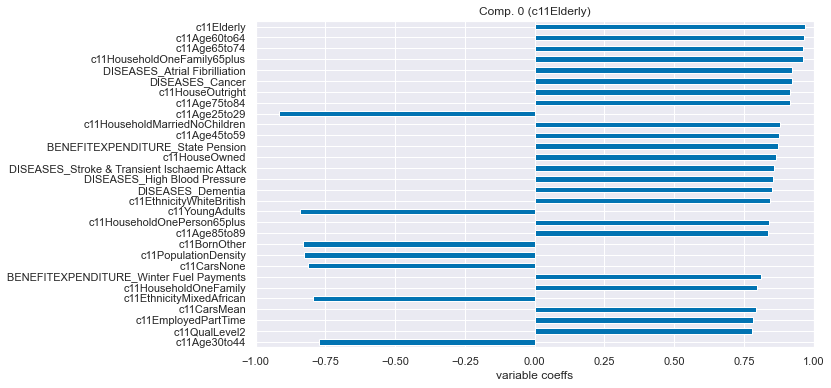

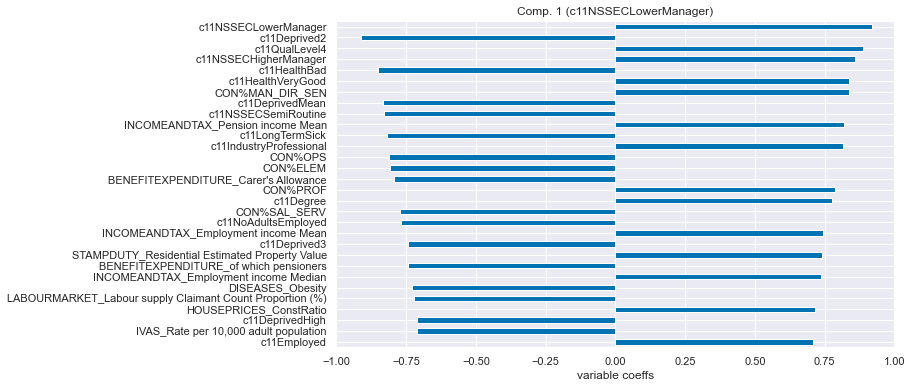

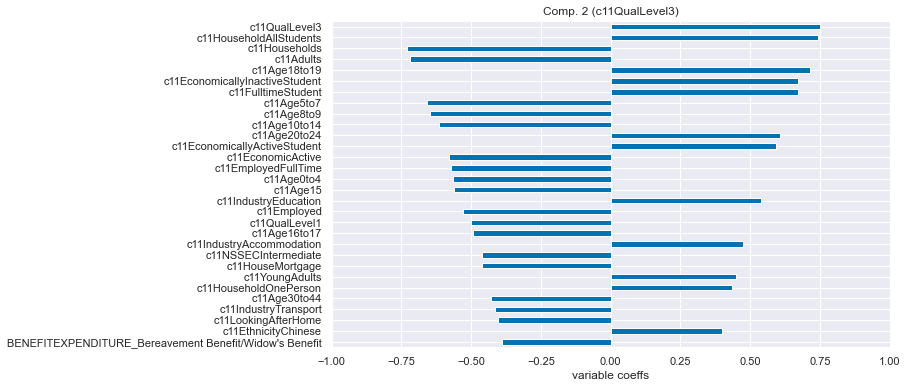

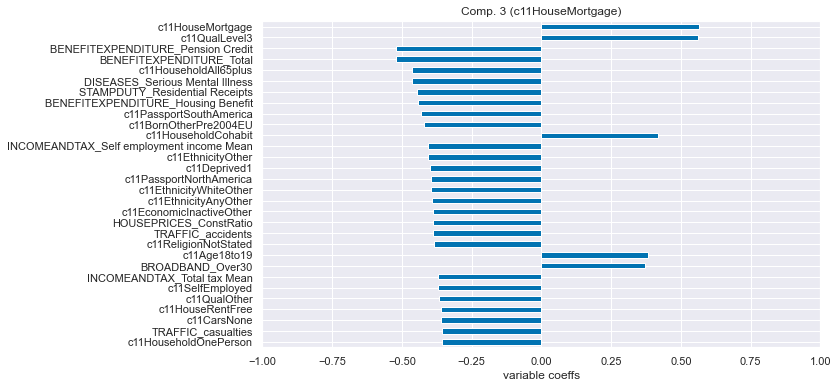

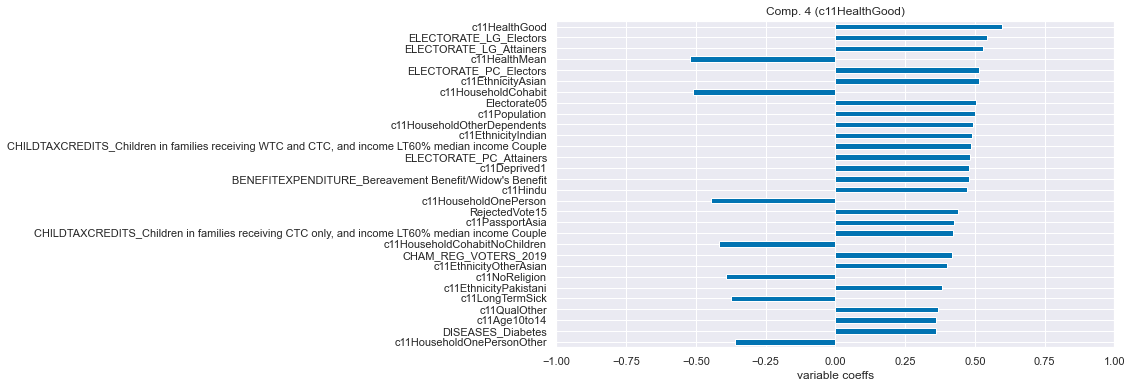

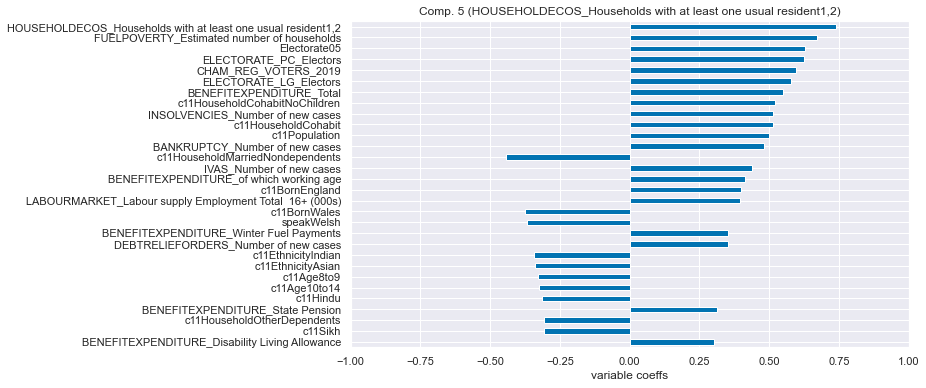

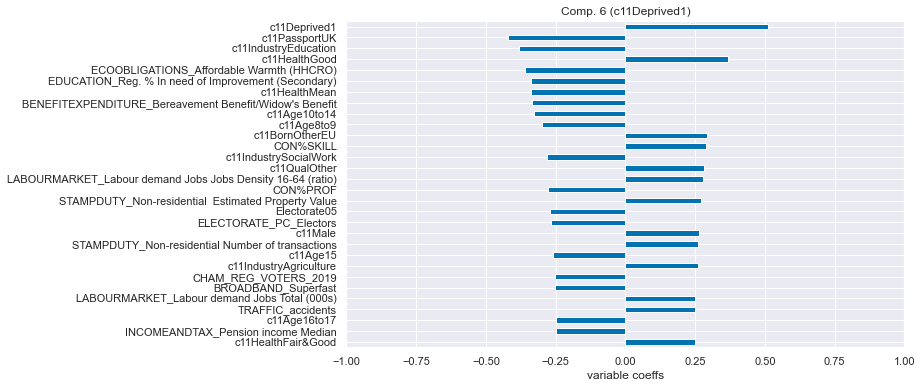

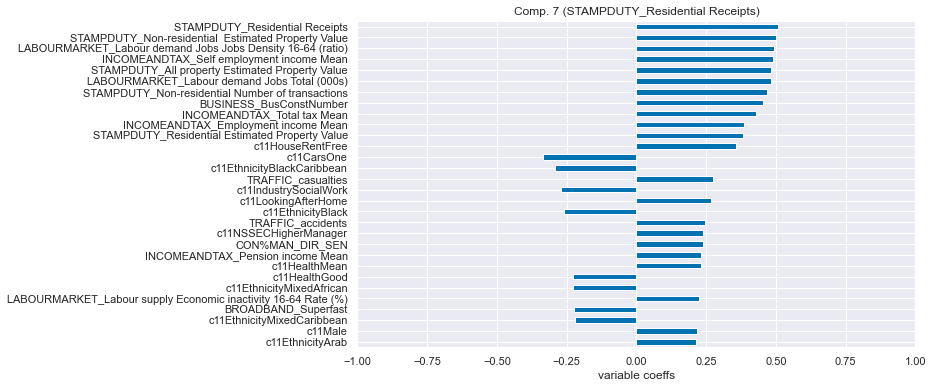

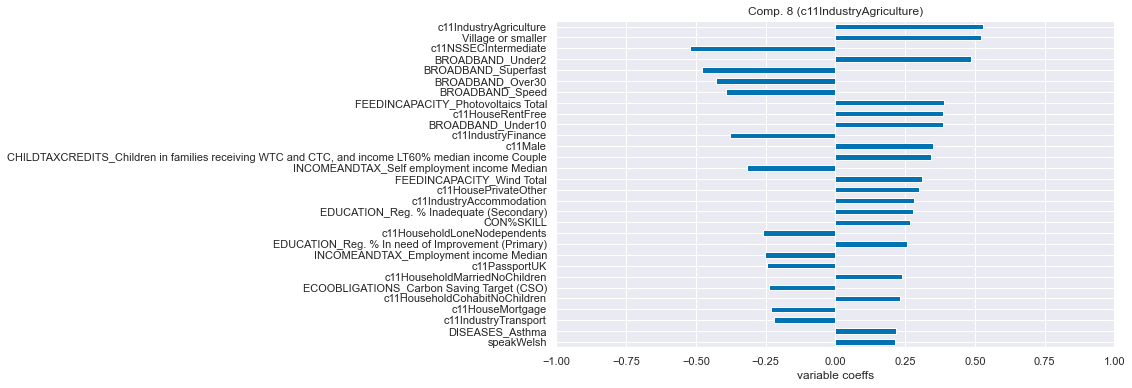

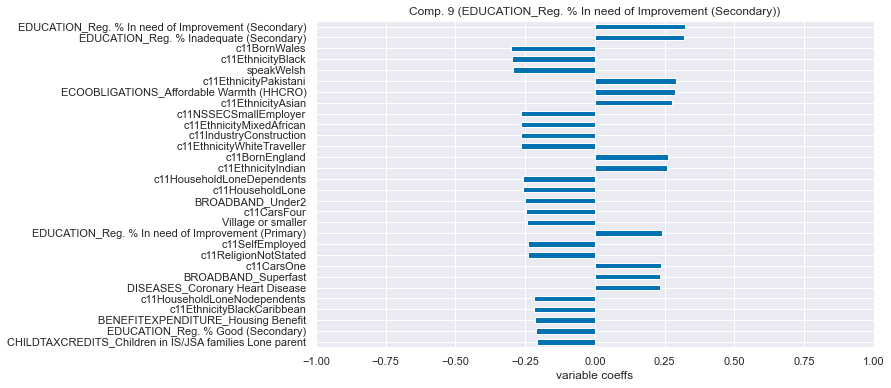

In [368]:
threshold = 0.05

predictions = alg.predict(df_simp.drop(var_stub,axis=1))
MSE = mean_squared_error(df_simp[var_stub], predictions)
MAE = mean_absolute_error(df_simp[var_stub], predictions)
EV = explained_variance_score(df_simp[var_stub], predictions)
R2 = r2_score(df_simp[var_stub], predictions)

dist = pd.DataFrame(shap_values).abs().mean(axis=0).sort_values(ascending=False)
print( train_columns[dist[dist>=threshold].index].shape,df_simp.shape )
print(MSE,MAE,EV,R2)

df = df_simp[train_columns[dist[dist>threshold].index]][geomask]
df = df.fillna(df.mean())

BES_decomp, comp_labels, comp_dict = dim_red(df, n_components=n_comp,
                                               red_type="Factor Analysis",show_first_x_comps=14,display_comp=True)
n_components = min(n_comp,BES_decomp.shape[1])
BES_decomp.columns = list(comp_labels.values())
Y = df_simp[var_stub]
X = BES_decomp.loc[:,BES_decomp.columns[0:n_components]]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

In [ ]:
# .001: R-squared:	0.853
# .005: R-squared:	0.862
# .01:R-squared:	0.872
# .02:R-squared:	0.874
# .03:R-squared:	0.865
# .04:R-squared:	0.882
# .05:R-squared:	0.877
# .06:R-squared:	0.878

# .1:R-squared:	0.868

In [352]:
# threshold = 0
# R-squared:	0.849

(324,)

In [350]:
# alg = XGBRegressor(n_estimators=500)
dist[dist!=0].shape
# R-squared:	0.868

(324,)

In [346]:
# alg = XGBRegressor()
dist[dist!=0].shape
# R-squared:	0.868

(324,)

In [342]:
# alg.min_child_weight=1
dist[dist!=0].shape
# R-squared: R-squared:	0.880

(434,)

In [339]:
# alg.max_depth=10
dist[dist!=0].shape
# R-squared: R-squared:	0.881

(428,)

In [335]:
dist[dist!=0].shape
# n_est x10
# R-squared:	0.882

(437,)

In [326]:
dist[dist!=0].shape
# n_est x2

(435,)

In [322]:
dist[dist!=0].shape
# n_est
# 430

(430,)

In [375]:
train_columns[dist[dist>threshold].index]

Index(['c11CarsNone', 'c11CarsFour', 'c11HouseholdMarriedNoChildren',
       'BENEFITEXPENDITURE_State Pension', 'c11HealthGood', 'c11CarsThree',
       'c11NSSECNeverWorked', 'c11Deprived3',
       'DISEASES_Serious Mental Illness', 'c11CarsMean',
       ...
       'CON%OPS', 'c11HealthBad', 'TRAFFIC_accidents', 'c11BornNI',
       'INSOLVENCIES_Number of new cases', 'ELECTORATE_PC_Electors',
       'EDUCATION_Reg. % In need of Improvement (Primary)',
       'LABOURMARKET_Labour demand Jobs Total (000s)', 'c11Jewish',
       'c11EthnicityChinese'],
      dtype='object', length=267)

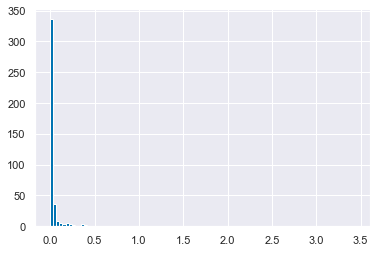

In [378]:
dist[dist>0].hist(bins=100)

In [319]:
(dist==0).sum()

5994

In [ ]:
########################################

# build a model *over multiple ges*

In [393]:
df_simp

RejectedVote17  RejectedVote15  Electorate05  c11Population  \
0                57              57         51080          66133   
1                78              59         43976          56415   
6               102             114         65971         103922   
7                87             105         58262          76974   
8               132             158         63969          96591   
..              ...             ...           ...            ...   
627              94             163         79306         106783   
628              40              67         52512          69751   
629             213             224         65817         104359   
630             146             154         71464          93692   
631              97             227         77121         100377   

     c11PopulationDensity    c11Male  c11Female  c11Households  c11Communal  \
0                3.751395  48.766879  51.233121      99.287799     0.712201   
1                0.935424  48.334663  51.665337      97.594611     2.405389   
6               19.614660  49.898963  50.101037      98.047574     1.952426   
7               17.483482  48.929509  51.070491      99.425780     0.574220   
8               18.709288  48.906213  51.093787      99.355012     0.644988   
..                    ...        ...        ...            ...          ...   
627              2.662853  49.362726  50.637274      97.991253     2.008747   
628              0.980694  49.137647  50.862353      98.838726     1.161274   
629             44.501633  49.314386  50.685614      97.369657     2.630343   
630              3.770519  47.805576  52.194424      94.755155     5.244845   
631              0.953157  48.793050  51.206950      97.804278     2.195722   

     c11Age0to4  ...  ldPriorities_noneW2_Yes  ldPriorities_schoolW2_Yes  \
0      5.511621  ...                 0.020246                   0.016478   
1      4.956129  ...                 0.025153                   0.029798   
6      7.038933  ...                 0.000000                   0.000000   
7      5.186167  ...                 0.000000                   0.000000   
8      6.305971  ...                 0.000000                   0.000000   
..          ...  ...                      ...                        ...   
627    5.811787  ...                 0.000000                   0.000000   
628    5.559777  ...                 0.000000                   0.000000   
629    5.827001  ...                 0.032875                   0.014546   
630    4.905435  ...                 0.016708                   0.065959   
631    4.818833  ...                 0.000000                   0.041115   

     RV2W2_factory worker  ldPriorities_crimeW2_Yes  \
0                0.014123                  0.000000   
1                0.020295                  0.000000   
6                0.043844                  0.000000   
7                0.091969                  0.000000   
8                0.078495                  0.000000   
..                    ...                       ...   
627              0.072050                  0.000000   
628              0.000000                  0.000000   
629              0.018100                  0.014546   
630              0.017185                  0.065959   
631              0.031073                  0.011862   

     achieveReduceImmigGrnW12_Yes  scotReferendumIntentionW12_Will vote 'Yes'  \
0                             0.0                                     0.04293   
1                             0.0                                     0.00000   
6                             0.0                                     0.00000   
7                             0.0                                     0.00000   
8                             0.0                                     0.00000   
..                            ...                                         ...   
627                           0.0                                     0.00000   
628              

In [444]:
%%time
# var_stub = "Auth_Right17_elec"
geomask = (BES_census_data["Country"]!="Scotland")&(BES_census_data["Winner17"]!="Speaker")
df_simp = pd.get_dummies(BES_census_data.drop(drop_cols,axis=1))
# df_simp[var_stub] = BES_census_data[var_stub]

# BES_agg_cols = BES_constituency_aggregates.drop(search(BES_constituency_aggregates,"|".join(["winConstituency","profile_past","ashcroft","partyContact",
#                                                        "partyId","localElection","localTurnout","^map",
#                                                        "generalElectionVote","euroElectionVote",
#                                                        "^prefer[^M]","ptv"])).index,axis=1).columns
# df_simp[BES_agg_cols] = BES_constituency_aggregates[BES_agg_cols].values

# df_simp.loc[BES_census_data["Country"]!="Scotland",nomis_dump.columns] = nomis_dump.values

df_simp = df_simp[geomask]


Wall time: 39.7 ms


In [446]:
df_simp = df_simp.loc[BES_census_data[["Auth_Right10_elec","Auth_Right15_elec"]][geomask].reset_index().melt(id_vars='index')["index"]]

temp = BES_census_data[["Con10_elec","Con15_elec"]][geomask].melt(var_name="GE",value_name="Voteshare")
temp["GE"] = temp["GE"].replace({"Con10_elec":"10","Con17_elec":"15"}).astype('category')
temp = pd.get_dummies(temp)
df_simp[temp.columns] = temp

# temp["variable"].value_counts()

In [448]:
# df_simp["Voteshare"].value_counts()

In [449]:
var_stub = "Voteshare"

MSE: 38.51, MAE: 3.02, EV: 0.65, R2: 0.65


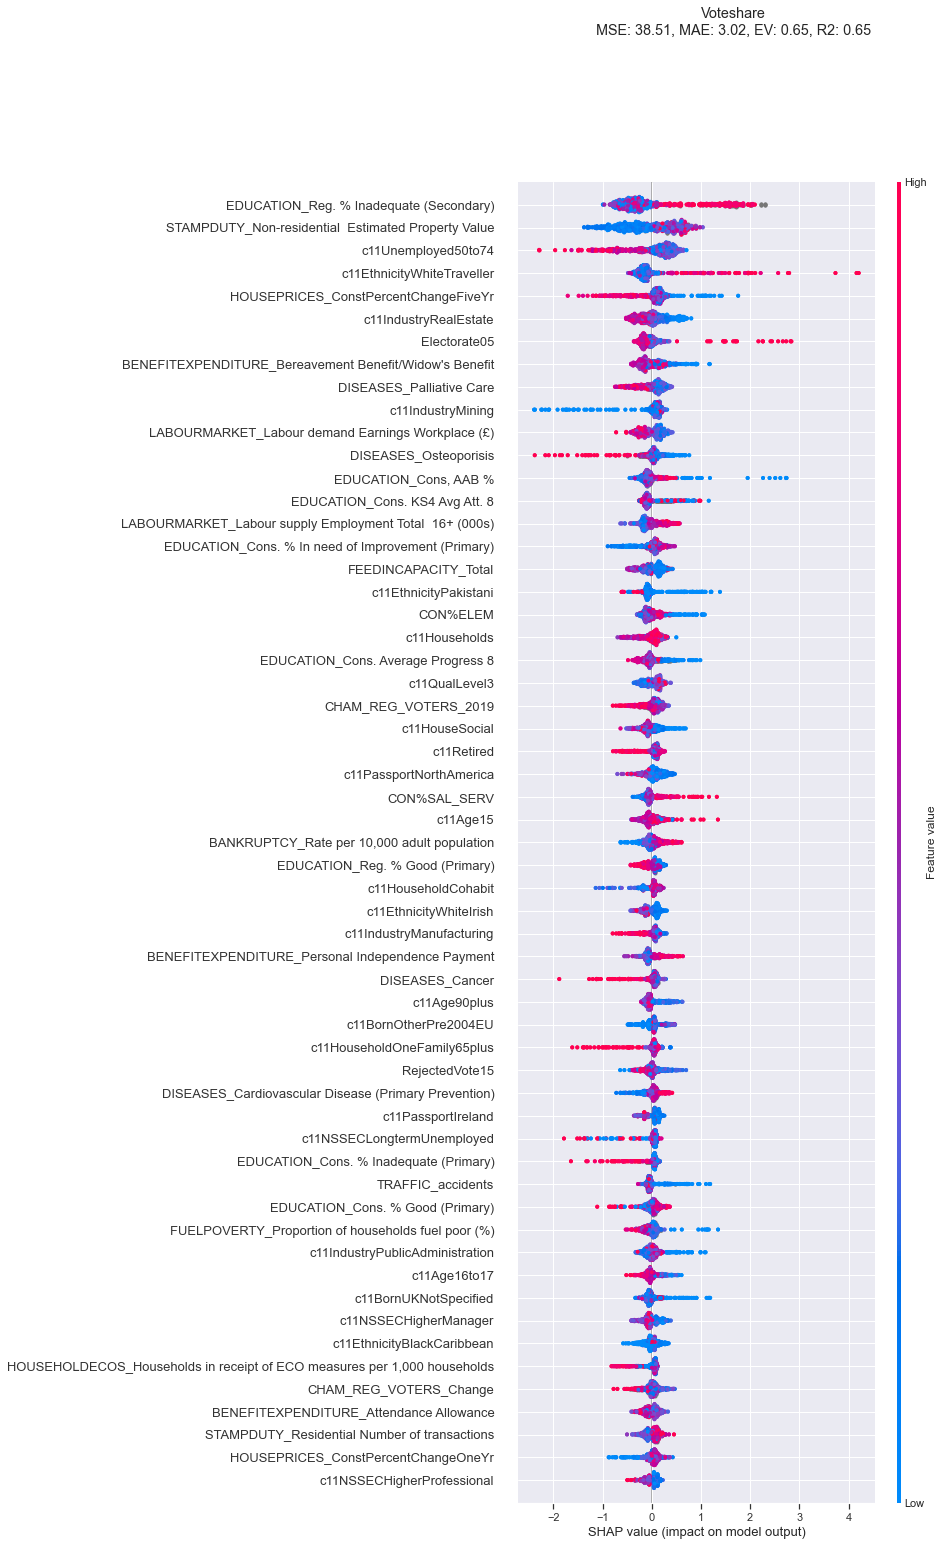

Wall time: 10.4 s


In [450]:
%%time
Treatment = var_stub

var_list = [var_stub]
var_stub_list = [var_stub,]
mask = df_simp[var_stub].notnull()
wt_cols = []
min_features = 30
colname = var_stub
dependence_plots = False

alg = get_xgboost_alg(classification_problem=False)
title = var_stub

(explainer, shap_values, train_columns, train_index, alg,output_subfolder)=\
    xgboost_run(subdir=colname,dataset=df_simp[mask].drop(wt_cols,axis=1),
            var_list=var_list,var_stub_list=var_stub_list,
            use_specific_weights=None,
            min_features = min(df_simp.shape[1]-1,min_features),verbosity=0,
            skip_bar_plot=True,dependence_plots=dependence_plots,alg=alg,eval_metric=eval_metric,                    
            title = title)

(139,) (1144, 469)
0.0019504731384732577 0.02975140363308511 0.9999818852577572 0.9999818844438916


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Voteshare   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     3.490
Date:                Sat, 29 Jan 2022   Prob (F-statistic):           8.12e-05
Time:                        20:43:47   Log-Likelihood:                -4280.6
No. Observations:                1144   AIC:                             8585.
Df Residuals:                    1132   BIC:                             8646.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
const                                                     23.0929      0.942     24.517      0.000      21.245      24.941
Comp. 0 (c11BornWales)                                     0.9726      0.304      3.202      0.001       0.377       1.569
Comp. 1 (c11AgeMean)                                       0.3402      0.304      1.119      0.263      -0.256       0.937
Comp. 2 (c11NSSECHigherProfessional)                      -0.0395      0.304     -0.130      0.897      -0.636       0.557
Comp. 3 (c11HouseholdMarriedDependents)                   -0.5338      0.306     -1.747      0.081      -1.133       0.066
Comp. 4 (c11HouseholdCohabit)                              1.1193      0.306      3.661      0.000       0.519       1.719
Comp. 5 (STAMPDUTY_Residential Number of transactions)     0.1896      0.307      0.617      0.538      -0.414       0.793
Comp. 6 (FUELPOVERTY_Estimated number of households)       0.4489      0.308      1.456      0.146      -0.156       1.054
Comp. 7 (c11Households)                                   -0.5515      0.309     -1.785      0.074      -1.158       0.055
Comp. 8 (c11HealthMean)                                   -0.2881      0.312     -0.923      0.356      -0.901       0.325
Comp. 9 (c11EthnicityPakistani)                            0.0575      0.317      0.181      0.856      -0.564       0.679
GE_10                                                      1.6382      0.996      1.644      0.100      -0.317       3.593
==============================================================================
Omnibus:                      236.828   Durbin-Watson:                   1.591
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.547
Skew:                          -0.143   Prob(JB):                     1.06e-11
Kurtosis:                       2.011   Cond. No.                         6.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

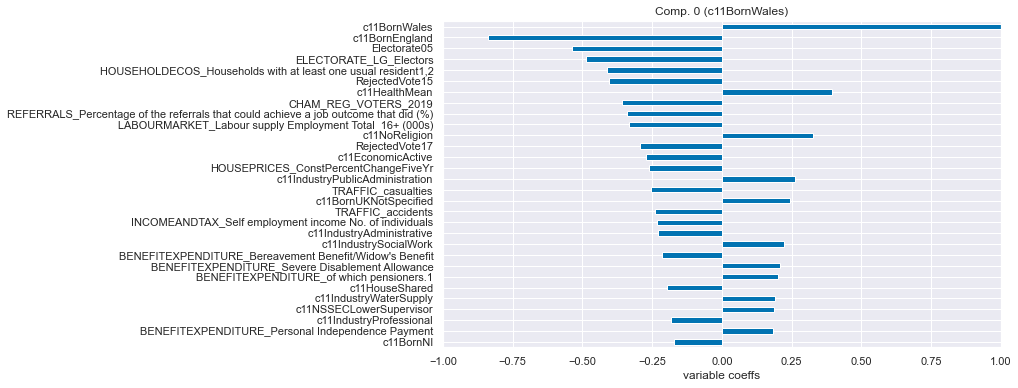

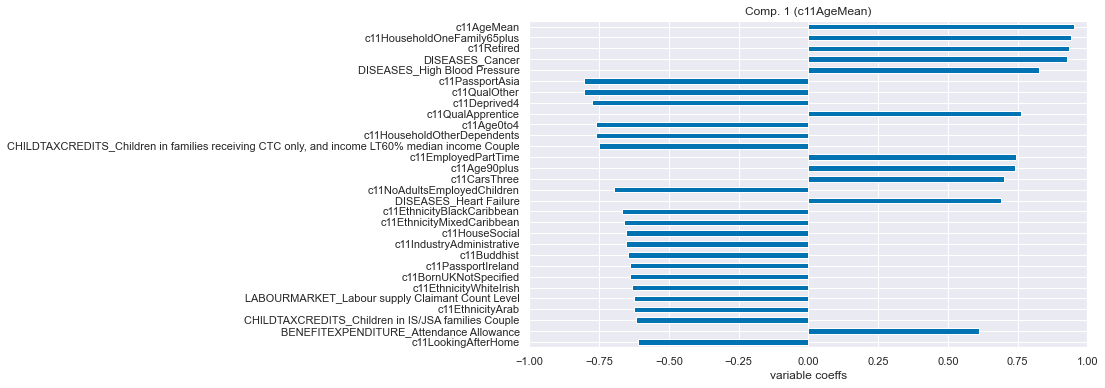

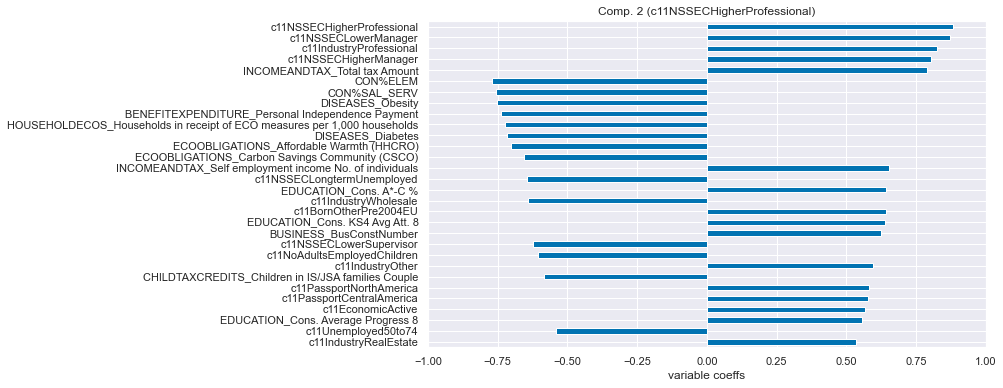

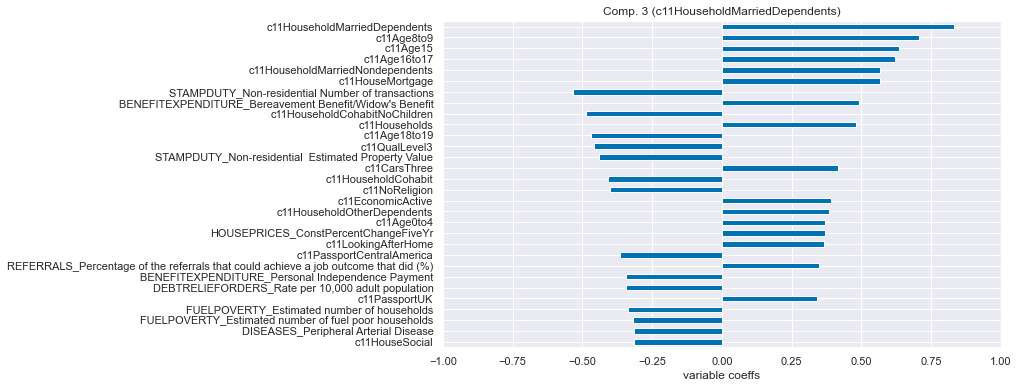

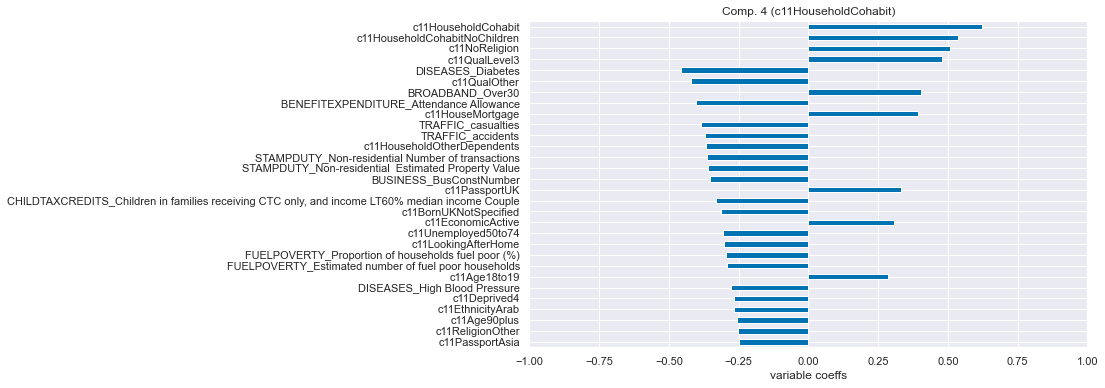

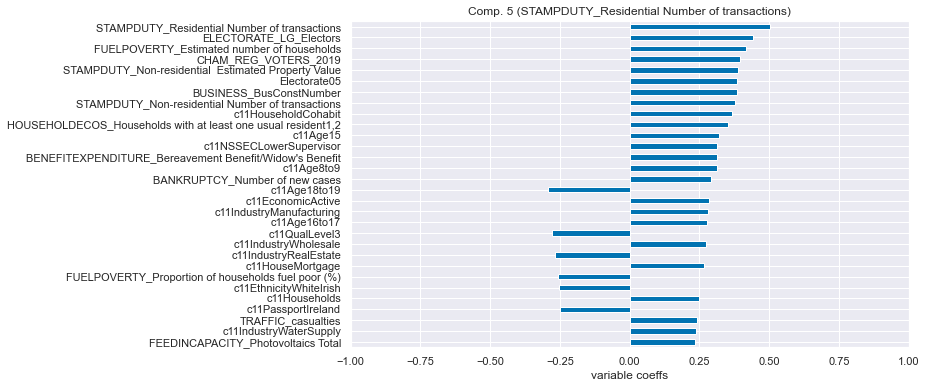

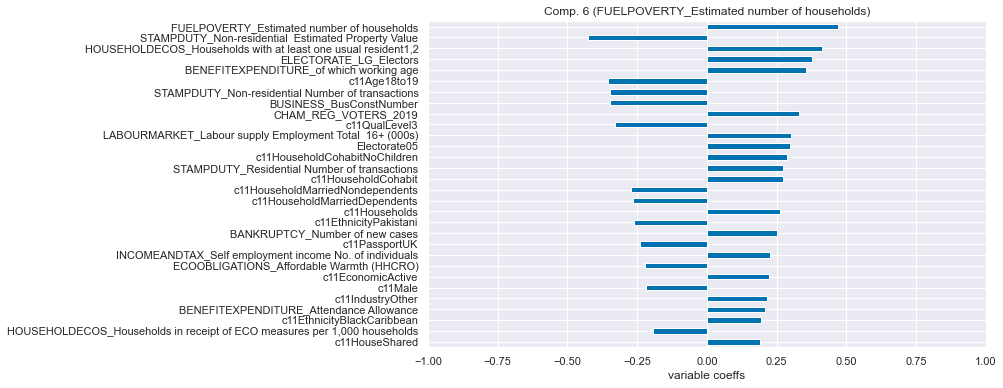

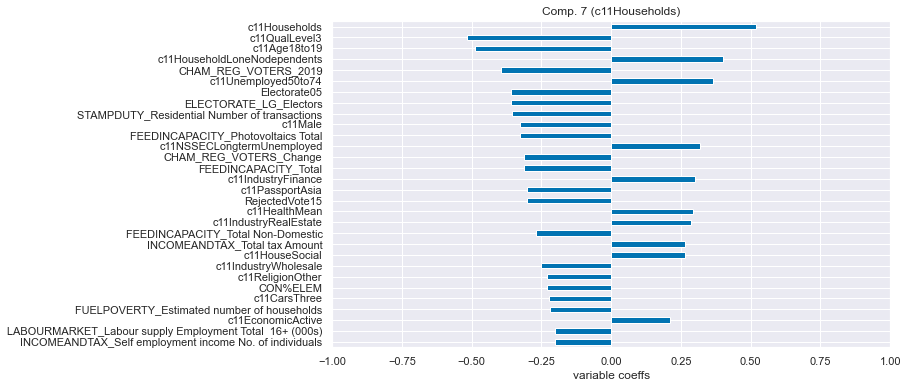

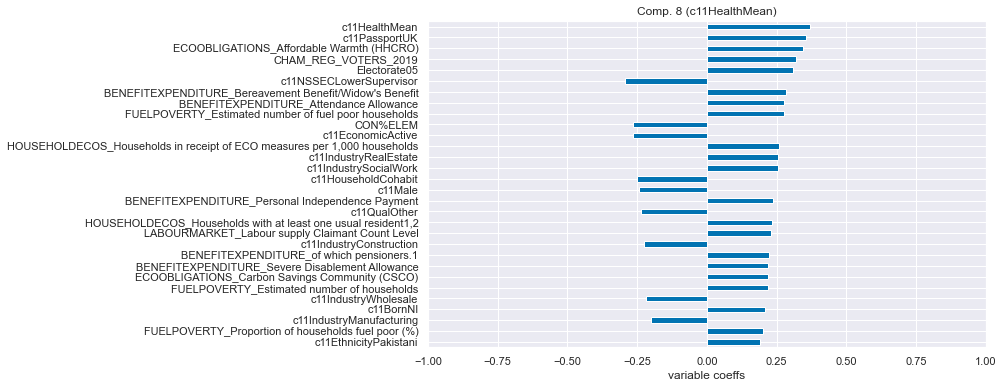

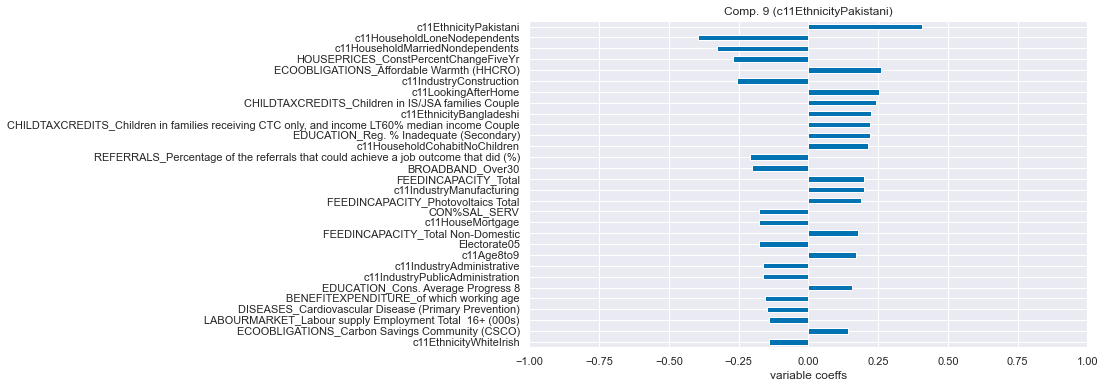

In [452]:
threshold = 0.05

predictions = alg.predict(df_simp.drop(var_stub,axis=1))
MSE = mean_squared_error(df_simp[var_stub], predictions)
MAE = mean_absolute_error(df_simp[var_stub], predictions)
EV = explained_variance_score(df_simp[var_stub], predictions)
R2 = r2_score(df_simp[var_stub], predictions)

dist = pd.DataFrame(shap_values).abs().mean(axis=0).sort_values(ascending=False)
print( train_columns[dist[dist>=threshold].index].shape,df_simp.shape )
print(MSE,MAE,EV,R2)

selected_features = train_columns[dist[dist>=threshold].index]
selected_features = [x for x in selected_features if x not in ["GE_10","GE_15"]]

df = df_simp[train_columns[dist[dist>threshold].index]][geomask]
df = df.fillna(df.mean())

BES_decomp, comp_labels, comp_dict = dim_red(df, n_components=n_comp,
                                               red_type="Factor Analysis",show_first_x_comps=14,display_comp=True)
n_components = min(n_comp,BES_decomp.shape[1])
BES_decomp.columns = list(comp_labels.values())
BES_decomp["GE_10"] = df_simp["GE_10"]

Y = df_simp[var_stub]
X = BES_decomp.loc[:,BES_decomp.columns[0:n_components+1]]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

In [ ]:
### oof!
# how about doing it manually for Con15 and Con17 and looking at the two models?

In [458]:
%%time
# var_stub = "Auth_Right17_elec"
geomask = (BES_census_data["Country"]!="Scotland")&(BES_census_data["Winner17"]!="Speaker")
df_simp = pd.get_dummies(BES_census_data.drop(drop_cols,axis=1))
# df_simp[var_stub] = BES_census_data[var_stub]

# BES_agg_cols = BES_constituency_aggregates.drop(search(BES_constituency_aggregates,"|".join(["winConstituency","profile_past","ashcroft","partyContact",
#                                                        "partyId","localElection","localTurnout","^map",
#                                                        "generalElectionVote","euroElectionVote",
#                                                        "^prefer[^M]","ptv"])).index,axis=1).columns
# df_simp[BES_agg_cols] = BES_constituency_aggregates[BES_agg_cols].values

# df_simp.loc[BES_census_data["Country"]!="Scotland",nomis_dump.columns] = nomis_dump.values

df_simp = df_simp[geomask]


Wall time: 37.7 ms


In [464]:
specific_vars = ["c11Deprived3","c11QualLevel4","c11Age60to64","CON%MAN_DIR_SEN","CON%SAL_SERV",
                 "Merseyside",
                 "speakWelsh",
                ]
var_stub = "Con17_elec"
Y = BES_census_data[var_stub][geomask]
X = df_simp[specific_vars]
# BES_decomp.loc[:,BES_decomp.columns[0:n_components+1]]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Con17_elec   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     631.7
Date:                Sun, 30 Jan 2022   Prob (F-statistic):          3.76e-262
Time:                        13:09:07   Log-Likelihood:                -1571.1
No. Observations:                 572   AIC:                             3158.
Df Residuals:                     564   BIC:                             3193.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              54.5798      3.325     16.417      0.000      48.050      61.110
c11Deprived3       -3.3325      0.127    -26.244      0.000      -3.582      -3.083
c11QualLevel4      -0.6828      0.040    -17.284      0.000      -0.760      -0.605
c11Age60to64        0.1860      0.209      0.890      0.374      -0.225       0.597
CON%MAN_DIR_SEN     1.8239      0.140     13.063      0.000       1.550       2.098
CON%SAL_SERV       -0.9815      0.163     -6.012      0.000      -1.302      -0.661
Merseyside         -5.0367      1.039     -4.847      0.000      -7.078      -2.996
speakWelsh        -20.4544      2.583     -7.918      0.000     -25.528     -15.380
==============================================================================
Omnibus:                       55.850   Durbin-Watson:                   1.781
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.060
Skew:                          -0.685   Prob(JB):                     5.58e-19
Kurtosis:                       4.285   Cond. No.                         675.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [465]:
specific_vars = ["c11Deprived3","c11QualLevel4","c11Age60to64","CON%MAN_DIR_SEN","CON%SAL_SERV",
                 "Merseyside",
                 "speakWelsh",
                ]
var_stub = "Con15_elec"
Y = BES_census_data[var_stub][geomask]
X = df_simp[specific_vars]
# BES_decomp.loc[:,BES_decomp.columns[0:n_components+1]]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Con15_elec   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     427.3
Date:                Sun, 30 Jan 2022   Prob (F-statistic):          8.73e-221
Time:                        13:09:18   Log-Likelihood:                -1663.1
No. Observations:                 572   AIC:                             3342.
Df Residuals:                     564   BIC:                             3377.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              45.1028      3.905     11.550      0.000      37.433      52.773
c11Deprived3       -3.2424      0.149    -21.739      0.000      -3.535      -2.949
c11QualLevel4      -0.4527      0.046     -9.757      0.000      -0.544      -0.362
c11Age60to64       -0.7969      0.246     -3.245      0.001      -1.279      -0.314
CON%MAN_DIR_SEN     2.0662      0.164     12.599      0.000       1.744       2.388
CON%SAL_SERV       -0.7896      0.192     -4.118      0.000      -1.166      -0.413
Merseyside         -2.3658      1.221     -1.938      0.053      -4.763       0.032
speakWelsh        -16.6951      3.034     -5.502      0.000     -22.655     -10.735
==============================================================================
Omnibus:                       80.274   Durbin-Watson:                   1.839
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.962
Skew:                          -0.837   Prob(JB):                     1.22e-32
Kurtosis:                       4.834   Cond. No.                         675.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

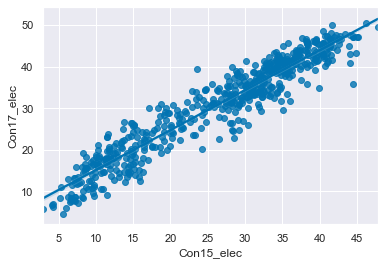

In [467]:
sns.regplot(BES_census_data["Con15_elec"][geomask],BES_census_data["Con17_elec"][geomask])

In [470]:
BES_census_data["Con15_elec"][geomask].corr(BES_census_data["Con17_elec"][geomask])

0.954129860141082

In [472]:
df_simp_orig = df_simp.copy()
df_simp_15 = df_simp.copy()
df_simp_15["Con%"] = BES_census_data["Con15_elec"][geomask]
df_simp_15["GE15"] = 1

df_simp_17 = df_simp.copy()
df_simp_17["Con%"] = BES_census_data["Con17_elec"][geomask]
df_simp_17["GE15"] = 0

In [474]:
df_simp = df_simp_15.append(df_simp_17)

In [475]:
specific_vars = ["c11Deprived3","c11QualLevel4","c11Age60to64","CON%MAN_DIR_SEN","CON%SAL_SERV",
                 "Merseyside",
                 "speakWelsh",
                ]
var_stub = "Con%"
Y = df_simp[var_stub]
X = df_simp[specific_vars]
# BES_decomp.loc[:,BES_decomp.columns[0:n_components+1]]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Con%   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     720.9
Date:                Sun, 30 Jan 2022   Prob (F-statistic):               0.00
Time:                        13:20:28   Log-Likelihood:                -3438.0
No. Observations:                1144   AIC:                             6892.
Df Residuals:                    1136   BIC:                             6932.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              49.8413      3.034     16.428      0.000      43.888      55.794
c11Deprived3       -3.2875      0.116    -28.369      0.000      -3.515      -3.060
c11QualLevel4      -0.5677      0.036    -15.749      0.000      -0.638      -0.497
c11Age60to64       -0.3054      0.191     -1.601      0.110      -0.680       0.069
CON%MAN_DIR_SEN     1.9450      0.127     15.265      0.000       1.695       2.195
CON%SAL_SERV       -0.8856      0.149     -5.944      0.000      -1.178      -0.593
Merseyside         -3.7012      0.948     -3.903      0.000      -5.562      -1.841
speakWelsh        -18.5748      2.357     -7.879      0.000     -23.200     -13.949
==============================================================================
Omnibus:                       90.811   Durbin-Watson:                   1.425
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.017
Skew:                          -0.633   Prob(JB):                     1.59e-28
Kurtosis:                       4.041   Cond. No.                         675.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [476]:
specific_vars = ["c11Deprived3","c11QualLevel4","c11Age60to64","CON%MAN_DIR_SEN","CON%SAL_SERV",
                 "Merseyside",
                 "speakWelsh","GE15",
                ]
var_stub = "Con%"
Y = df_simp[var_stub]
X = df_simp[specific_vars]
# BES_decomp.loc[:,BES_decomp.columns[0:n_components+1]]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Con%   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     841.7
Date:                Sun, 30 Jan 2022   Prob (F-statistic):               0.00
Time:                        13:21:36   Log-Likelihood:                -3299.5
No. Observations:                1144   AIC:                             6617.
Df Residuals:                    1135   BIC:                             6662.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              52.1067      2.692     19.353      0.000      46.824      57.389
c11Deprived3       -3.2875      0.103    -32.005      0.000      -3.489      -3.086
c11QualLevel4      -0.5677      0.032    -17.768      0.000      -0.630      -0.505
c11Age60to64       -0.3054      0.169     -1.806      0.071      -0.637       0.026
CON%MAN_DIR_SEN     1.9450      0.113     17.221      0.000       1.723       2.167
CON%SAL_SERV       -0.8856      0.132     -6.706      0.000      -1.145      -0.626
Merseyside         -3.7012      0.841     -4.403      0.000      -5.350      -2.052
speakWelsh        -18.5748      2.090     -8.889      0.000     -22.675     -14.475
GE15               -4.5307      0.257    -17.631      0.000      -5.035      -4.026
==============================================================================
Omnibus:                      113.550   Durbin-Watson:                   1.813
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              189.289
Skew:                          -0.684   Prob(JB):                     7.88e-42
Kurtosis:                       4.449   Cond. No.                         676.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
const	54.5798	3.325	16.417	0.000	48.050	61.110
c11Deprived3	-3.3325	0.127	-26.244	0.000	-3.582	-3.083
c11QualLevel4	-0.6828	0.040	-17.284	0.000	-0.760	-0.605
c11Age60to64	0.1860	0.209	0.890	0.374	-0.225	0.597
CON%MAN_DIR_SEN	1.8239	0.140	13.063	0.000	1.550	2.098
CON%SAL_SERV	-0.9815	0.163	-6.012	0.000	-1.302	-0.661
Merseyside	-5.0367	1.039	-4.847	0.000	-7.078	-2.996
speakWelsh	-20.4544	2.583	-7.918	0.000	-25.528	-15.380

In [531]:
%%time
geomask = (BES_census_data["Country"]!="Scotland")&(BES_census_data["Winner17"]!="Speaker")
df_simp = pd.get_dummies(BES_census_data.drop(drop_cols,axis=1))
df_simp = df_simp[geomask]


Wall time: 43.2 ms


In [532]:
base = "Auth_Right"
year_list = ["05","10","15","17","19"]
var_set = [base+x+"_elec" for x in year_list]

df_simp = df_simp.loc[BES_census_data[var_set][geomask].reset_index().melt(id_vars='index')["index"]]
temp = BES_census_data[var_set][geomask].melt(var_name="GE",value_name="Voteshare")
temp["GE"] = temp["GE"].astype('category')
temp = pd.get_dummies(temp)
df_simp[["Voteshare"]+year_list] = temp.values
df_simp=df_simp.reset_index().drop("index",axis=1)

In [530]:
# df_simp

In [535]:
# df_simp

In [536]:
specific_vars = ["c11Deprived3","c11QualLevel4","c11Age60to64","CON%MAN_DIR_SEN","CON%SAL_SERV",
                 "Merseyside",
                 "speakWelsh",]
specific_vars = specific_vars+year_list[1:]
var_stub = "Voteshare"
Y = df_simp[var_stub]
X = df_simp[specific_vars]
# BES_decomp.loc[:,BES_decomp.columns[0:n_components+1]]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Voteshare   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     1504.
Date:                Sun, 30 Jan 2022   Prob (F-statistic):               0.00
Time:                        21:42:47   Log-Likelihood:                -8337.9
No. Observations:                2860   AIC:                         1.670e+04
Df Residuals:                    2848   BIC:                         1.677e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              48.2884      1.759     27.445      0.000      44.838      51.738
c11Deprived3       -3.1000      0.067    -46.340      0.000      -3.231      -2.969
c11QualLevel4      -0.7515      0.021    -36.111      0.000      -0.792      -0.711
c11Age60to64       -0.3121      0.110     -2.833      0.005      -0.528      -0.096
CON%MAN_DIR_SEN     1.9819      0.074     26.945      0.000       1.838       2.126
CON%SAL_SERV       -0.9609      0.086    -11.173      0.000      -1.130      -0.792
Merseyside         -4.5365      0.547     -8.287      0.000      -5.610      -3.463
speakWelsh        -19.0377      1.361    -13.989      0.000     -21.706     -16.369
10                  6.0817      0.265     22.983      0.000       5.563       6.601
15                 12.8758      0.265     48.658      0.000      12.357      13.395
17                  9.5070      0.265     35.927      0.000       8.988      10.026
19                 10.2017      0.265     38.553      0.000       9.683      10.721
==============================================================================
Omnibus:                      309.351   Durbin-Watson:                   1.826
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              735.855
Skew:                          -0.635   Prob(JB):                    1.63e-160
Kurtosis:                       5.136   Cond. No.                         678.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
### run through reasonable combinations???
# store R2(results?) as a quick
## No - use the pre-existing code, the point is to auto-find good models covering given pairs of years/coalitions

# all 10 adjacent combos
## 05-10,10-15,15-17,17-19,05-10-15,10-15-17,15-17-19,05-10-15-17,10-15-17-19,05-10-15-17-19

## Con,Auth-Right,Lab,Lib-Left

In [580]:
res_df_2 = pd.DataFrame()

In [617]:
# %%time

country = "Wales"
geomask = (BES_census_data["Country"]==country)&(BES_census_data["Winner17"]!="Speaker")
df_simp_base = pd.get_dummies(BES_census_data.drop(drop_cols,axis=1))
df_simp_base = df_simp_base[geomask]
# df_simp_base = pd.get_dummies(BES_census_data.drop(drop_cols+['Con17','LL17_elec', 'G-L-L17_elec','G-L17_elec',
#                                                              "LL15_elec","LL10_elec","LL05_elec",
#                                                              "G-L15_elec","G-L10_elec","G-L05_elec"],axis=1))
# df_simp[var_stub] = BES_census_data[var_stub][geomask].values
# var_stub = "Con17_elec"

# country_dict = {"England":["England"],"Wales":["Wales"],"Scotland":["Scotland"],"England&Wales":["England","Wales"],
#                "Scotland&Wales":["Scotland","Wales"],"England&Scotland":["England","Scotland"],
#                 "Britain":["England","Scotland","Wales"]} #7

# country_dict = {'The Norf': ['North East','North West','Yorkshire and The Humber'],
#  'Middle Earth': ['East Midlands','West Midlands'],
#  'Great Sarfeast': ['South East','London'],
#  'Southlands': ['East of England','London','South East','South West'],
# }

target_pol_var_list = ["Lab","Lib_Left","PC"]
# target_pol_var_list = target_pol_var_list[:1]
year_combo_list = [["05","10"],["10","15"],["15","17"],["17","19"],["05","10","15"],["10","15","17"],
                   ["15","17","19"],["05","10","15","17"],["10","15","17","19"],["05","10","15","17","19"]]
    #"Con05_elec","Con10_elec","Con15_elec","Con19_elec"]
# ["Con17_elec","Auth_Right17_elec","Lab17_elec","Lib_Left17_elec","LD17_elec",
#                        'DNV17_elec','LL17_elec','G-L-L17_elec']
       
# year_combo_list = year_combo_list[:1]
    
n_comp=10
threshold=.1
repeat_no =10



# for n_comp in [5,10]:
# for threshold in [0,.1,.2,.3,.4,.5,.6,.7]:
for year_combo in year_combo_list:
#     country = country_dict[country_label]
    
    for pol_var in target_pol_var_list:
        print(year_combo,pol_var)
        var_set = [pol_var+x+"_elec" for x in year_combo]
        df_simp = df_simp_base.loc[BES_census_data[var_set][geomask].reset_index().melt(id_vars='index')["index"]].copy()
        temp = BES_census_data[var_set][geomask].melt(var_name="GE",value_name="Voteshare")
        temp["GE"] = temp["GE"].astype('category')
        temp = pd.get_dummies(temp)
        df_simp[["Voteshare"]+year_combo] = temp.values
        df_simp=df_simp.reset_index().drop("index",axis=1)        
        
        
#         geomask = (BES_census_data["Region"].isin(country))&(BES_census_data["Winner17"]!="Speaker")
#         df_simp = df_simp_base[geomask].copy()

#         df_simp[var_stub] = BES_census_data[geomask][var_stub]
        var_stub = "Voteshare"


#         print(var_stub)
        #,0.01,.02,.05,.1
        for repeat in range(repeat_no):
            start = time.time()

            Treatment = var_stub

            var_list = [var_stub]
            var_stub_list = [var_stub,]
            mask = df_simp[var_stub].notnull()
            wt_cols = []
            min_features = 30
            colname = var_stub
            dependence_plots = False

            alg = get_xgboost_alg(classification_problem=False)
            alg.random_state = randint(0, 1000)
            # alg.n_estimators=1000
            title = var_stub

            (explainer, shap_values, train_columns, train_index, alg,output_subfolder)=\
                xgboost_run(subdir=colname,dataset=df_simp[mask].drop(wt_cols,axis=1),
                        var_list=var_list,var_stub_list=var_stub_list,
                        use_specific_weights=None,
                        min_features = min(df_simp.shape[1]-1,min_features),verbosity=0,
                        skip_bar_plot=True,dependence_plots=dependence_plots,alg=alg,eval_metric=eval_metric,                    
                        title = title,print_shap_chart=False,minimum_sample=28)

#             predictions = alg.predict(df_simp.drop(var_stub,axis=1))
#             MSE = mean_squared_error(df_simp[var_stub], predictions)
#             MAE = mean_absolute_error(df_simp[var_stub], predictions)
#             EV = explained_variance_score(df_simp[var_stub], predictions)
#             R2 = r2_score(df_simp[var_stub], predictions)

            dist = pd.DataFrame(shap_values).abs().mean(axis=0).sort_values(ascending=False)
            selected_features = train_columns[dist[dist>=threshold].index]
            print( selected_features.shape,df_simp.shape )
            # drop year combo variables
            selected_features = [x for x in selected_features if x not in year_combo]
            
        

            df = df_simp[selected_features]#[geomask]
            df = df.fillna(df.mean())

            BES_decomp = dim_red(df, n_components=n_comp,
                                                           red_type="Factor Analysis",show_first_x_comps=14,display_comp=False)
            n_components = min(n_comp,BES_decomp.shape[1])
            Y = df_simp[var_stub]
            year_df = df_simp[year_combo[1:]]
            year_df.columns = "GE"+year_df.columns
            X = pd.concat([BES_decomp.loc[:,0:n_components],year_df],axis=1)
            X = sm.add_constant(X)
            model = sm.OLS(Y,X)
            results = model.fit()
#             display(results.summary())

            ind = res_df_2.index.max()
            if pd.isnull(ind):
                ind = 0
            else:
                ind = ind+1
            end = time.time()
            res_df_2.loc[ind,["duration","n_components","n_components_act",
                                "variables","year_combo","pol_var",
                                "threshold","repeats","results","country"]] = [end-start,n_comp,n_components,
                                                                                                           df.columns,
                                                                                                    "|".join(year_combo),pol_var,
                                                                                                    threshold,repeat,results,country]
            
            
res_df_2["rsquared"] = res_df_2["results"].apply(lambda x: x.rsquared)            

['05', '10'] Lab
MSE: 13.04, MAE: 2.58, EV: 0.77, R2: 0.77
(29,) (80, 469)
MSE: 11.97, MAE: 2.50, EV: 0.79, R2: 0.79
(27,) (80, 469)
MSE: 12.87, MAE: 2.72, EV: 0.77, R2: 0.77
(26,) (80, 469)
MSE: 12.52, MAE: 2.53, EV: 0.78, R2: 0.78
(23,) (80, 469)
MSE: 12.31, MAE: 2.46, EV: 0.78, R2: 0.78
(24,) (80, 469)
MSE: 11.44, MAE: 2.44, EV: 0.80, R2: 0.80
(28,) (80, 469)
MSE: 12.65, MAE: 2.61, EV: 0.78, R2: 0.78
(26,) (80, 469)
MSE: 12.96, MAE: 2.61, EV: 0.77, R2: 0.77
(26,) (80, 469)
MSE: 12.64, MAE: 2.54, EV: 0.78, R2: 0.78
(31,) (80, 469)
MSE: 12.84, MAE: 2.63, EV: 0.77, R2: 0.77
(27,) (80, 469)
['05', '10'] Lib_Left
MSE: 21.40, MAE: 3.69, EV: 0.42, R2: 0.38
(26,) (80, 469)
MSE: 23.54, MAE: 3.79, EV: 0.36, R2: 0.32
(24,) (80, 469)
MSE: 21.42, MAE: 3.61, EV: 0.42, R2: 0.38
(19,) (80, 469)
MSE: 18.23, MAE: 3.44, EV: 0.51, R2: 0.47
(24,) (80, 469)
MSE: 20.35, MAE: 3.44, EV: 0.45, R2: 0.41
(29,) (80, 469)
MSE: 21.69, MAE: 3.64, EV: 0.40, R2: 0.37
(30,) (80, 469)
MSE: 19.81, MAE: 3.44, EV: 0.48, 

(24,) (120, 470)
MSE: 16.78, MAE: 3.45, EV: 0.66, R2: 0.66
(18,) (120, 470)
MSE: 14.98, MAE: 3.26, EV: 0.70, R2: 0.70
(24,) (120, 470)
['05', '10', '15'] PC
MSE: 3.81, MAE: 1.52, EV: 0.93, R2: 0.93
(15,) (120, 470)
MSE: 4.13, MAE: 1.56, EV: 0.92, R2: 0.92
(16,) (120, 470)
MSE: 4.13, MAE: 1.55, EV: 0.92, R2: 0.92
(17,) (120, 470)
MSE: 3.95, MAE: 1.56, EV: 0.93, R2: 0.93
(16,) (120, 470)
MSE: 3.98, MAE: 1.51, EV: 0.93, R2: 0.93
(19,) (120, 470)
MSE: 3.93, MAE: 1.53, EV: 0.93, R2: 0.93
(16,) (120, 470)
MSE: 3.98, MAE: 1.53, EV: 0.93, R2: 0.93
(17,) (120, 470)
MSE: 4.10, MAE: 1.53, EV: 0.92, R2: 0.92
(21,) (120, 470)
MSE: 4.48, MAE: 1.65, EV: 0.92, R2: 0.92
(20,) (120, 470)
MSE: 4.23, MAE: 1.58, EV: 0.92, R2: 0.92
(13,) (120, 470)
['10', '15', '17'] Lab
MSE: 6.43, MAE: 1.87, EV: 0.91, R2: 0.91
(24,) (120, 470)
MSE: 5.65, MAE: 1.78, EV: 0.92, R2: 0.92
(21,) (120, 470)
MSE: 6.42, MAE: 1.90, EV: 0.91, R2: 0.91
(20,) (120, 470)
MSE: 5.98, MAE: 1.80, EV: 0.91, R2: 0.91
(22,) (120, 470)
MSE: 6.4

MSE: 10.34, MAE: 2.42, EV: 0.83, R2: 0.83
(21,) (200, 472)
MSE: 9.05, MAE: 2.17, EV: 0.85, R2: 0.85
(25,) (200, 472)
MSE: 10.14, MAE: 2.37, EV: 0.83, R2: 0.83
(23,) (200, 472)
MSE: 8.62, MAE: 2.07, EV: 0.86, R2: 0.86
(26,) (200, 472)
MSE: 9.01, MAE: 2.13, EV: 0.85, R2: 0.85
(23,) (200, 472)
MSE: 8.81, MAE: 2.11, EV: 0.86, R2: 0.85
(20,) (200, 472)
MSE: 10.28, MAE: 2.43, EV: 0.83, R2: 0.83
(20,) (200, 472)
MSE: 9.52, MAE: 2.32, EV: 0.84, R2: 0.84
(20,) (200, 472)
['05', '10', '15', '17', '19'] Lib_Left
MSE: 6.06, MAE: 2.05, EV: 0.87, R2: 0.87
(20,) (200, 472)
MSE: 7.34, MAE: 2.18, EV: 0.84, R2: 0.84
(22,) (200, 472)
MSE: 6.84, MAE: 2.13, EV: 0.85, R2: 0.85
(24,) (200, 472)
MSE: 6.80, MAE: 2.07, EV: 0.85, R2: 0.85
(21,) (200, 472)
MSE: 7.50, MAE: 2.21, EV: 0.84, R2: 0.84
(25,) (200, 472)
MSE: 7.21, MAE: 2.15, EV: 0.84, R2: 0.84
(20,) (200, 472)
MSE: 7.30, MAE: 2.15, EV: 0.84, R2: 0.84
(22,) (200, 472)
MSE: 7.12, MAE: 2.12, EV: 0.84, R2: 0.84
(22,) (200, 472)
MSE: 6.75, MAE: 2.10, EV: 0.8

In [612]:
# search(BES_census_data,"PC")

In [588]:
res_df_2["duration"].sum()

38536.40484833717

In [587]:
res_df_2["duration"].sum()

38536.40484833717

In [596]:
res_df_2.groupby(['pol_var','year_combo'])["rsquared"].apply(lambda x: (round(x.mean(),2),round(x.std(),2),"N="+str(len(x))))

pol_var     year_combo    
Auth_Right  05|10             (0.84, 0.01, N=20)
            05|10|15          (0.86, 0.01, N=20)
            05|10|15|17        (0.86, 0.0, N=20)
            05|10|15|17|19     (0.84, 0.0, N=20)
            10|15              (0.85, 0.0, N=20)
            10|15|17           (0.85, 0.0, N=20)
            10|15|17|19        (0.83, 0.0, N=20)
            15|17             (0.86, 0.01, N=20)
            15|17|19           (0.84, 0.0, N=20)
            17|19             (0.84, 0.01, N=20)
Con         05|10              (0.85, 0.0, N=20)
            05|10|15           (0.86, 0.0, N=10)
            05|10|15|17        (0.86, 0.0, N=10)
            05|10|15|17|19    (0.84, 0.01, N=10)
            10|15              (0.86, 0.0, N=10)
            10|15|17           (0.86, 0.0, N=10)
            10|15|17|19        (0.84, 0.0, N=10)
            15|17              (0.87, 0.0, N=10)
            15|17|19           (0.84, 0.0, N=10)
            17|19             (0.85, 0.01,

In [602]:
res_df_2[res_df_2["country"]=="England"].groupby(['pol_var','year_combo'])["rsquared"].apply(lambda x: (round(x.mean(),2),round(x.std(),2),"N="+str(len(x))))
# res_df_2.groupby(['pol_var','year_combo'])["rsquared"].apply(lambda x: (round(x.mean(),2),round(x.std(),2),"N="+str(len(x))))

pol_var   year_combo    
Lab       05|10             (0.68, 0.01, N=10)
          05|10|15           (0.7, 0.01, N=10)
          05|10|15|17       (0.71, 0.01, N=10)
          05|10|15|17|19     (0.7, 0.01, N=10)
          10|15             (0.75, 0.01, N=10)
          10|15|17           (0.77, 0.0, N=10)
          10|15|17|19       (0.75, 0.01, N=10)
          15|17             (0.78, 0.01, N=10)
          15|17|19          (0.74, 0.01, N=10)
          17|19             (0.72, 0.01, N=10)
Lib_Left  05|10              (0.5, 0.02, N=10)
          05|10|15           (0.6, 0.01, N=10)
          05|10|15|17       (0.61, 0.02, N=10)
          05|10|15|17|19    (0.57, 0.02, N=10)
          10|15             (0.66, 0.02, N=10)
          10|15|17          (0.66, 0.03, N=10)
          10|15|17|19       (0.63, 0.02, N=10)
          15|17             (0.71, 0.03, N=10)
          15|17|19          (0.69, 0.02, N=10)
          17|19             (0.69, 0.01, N=10)
Name: rsquared, dtype: object

In [615]:
res_df_2[res_df_2["country"]=="Scotland"].groupby(['pol_var','year_combo'])["rsquared"].apply(lambda x: (round(x.mean(),2),round(x.std(),2),"N="+str(len(x))))

pol_var   year_combo    
Lab       05|10             (0.75, 0.01, N=10)
          05|10|15          (0.75, 0.01, N=10)
          05|10|15|17       (0.73, 0.01, N=10)
          05|10|15|17|19    (0.75, 0.01, N=10)
          10|15             (0.76, 0.02, N=10)
          10|15|17          (0.72, 0.01, N=10)
          10|15|17|19       (0.74, 0.02, N=10)
          15|17             (0.65, 0.02, N=10)
          15|17|19          (0.67, 0.01, N=10)
          17|19              (0.7, 0.01, N=10)
Lib_Left  05|10             (0.66, 0.03, N=10)
          05|10|15          (0.73, 0.02, N=10)
          05|10|15|17        (0.7, 0.02, N=10)
          05|10|15|17|19    (0.67, 0.02, N=10)
          10|15              (0.7, 0.03, N=10)
          10|15|17          (0.74, 0.02, N=10)
          10|15|17|19       (0.71, 0.02, N=10)
          15|17             (0.77, 0.01, N=10)
          15|17|19          (0.75, 0.01, N=10)
          17|19             (0.73, 0.03, N=10)
SNP       05|10               (nan,

In [609]:
res_df_2[res_df_2["country"]=="Wales"].groupby(['pol_var','year_combo'])["rsquared"].apply(lambda x: (round(x.mean(),2),round(x.std(),2),"N="+str(len(x))))

pol_var   year_combo    
Lab       05|10             (0.75, 0.02, N=10)
          05|10|15          (0.75, 0.02, N=10)
          05|10|15|17       (0.74, 0.01, N=10)
          05|10|15|17|19    (0.74, 0.01, N=10)
          10|15             (0.75, 0.01, N=10)
          10|15|17          (0.72, 0.01, N=10)
          10|15|17|19       (0.74, 0.01, N=10)
          15|17             (0.65, 0.02, N=10)
          15|17|19          (0.66, 0.01, N=10)
          17|19             (0.71, 0.02, N=10)
Lib_Left  05|10             (0.66, 0.03, N=10)
          05|10|15          (0.72, 0.01, N=10)
          05|10|15|17        (0.7, 0.01, N=10)
          05|10|15|17|19    (0.68, 0.02, N=10)
          10|15             (0.69, 0.03, N=10)
          10|15|17          (0.74, 0.02, N=10)
          10|15|17|19       (0.71, 0.02, N=10)
          15|17             (0.77, 0.01, N=10)
          15|17|19          (0.75, 0.01, N=10)
          17|19             (0.72, 0.02, N=10)
Name: rsquared, dtype: object